In [209]:
from models import BiLSTM, BiRNN
import modal
import torch 
import lab
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## 14/01

### Added negative $a_n$ to transfer function generation, see if this makes any difference

#### New parameter 'neg_an' in generate_data function, first try without normalisation (only 3 epochs)

In [2]:
# try without normalisation for now (normalise=None by default)
X, y, ws, __ = modal.generate_data(num_data=32*300, num_w_points=200, neg_an=True)  # sigma_max = 0.15, max_modes = 7 (defaults)
valX, valy, _, __ = modal.generate_data(num_data=32*50, num_w_points=200, neg_an=True)

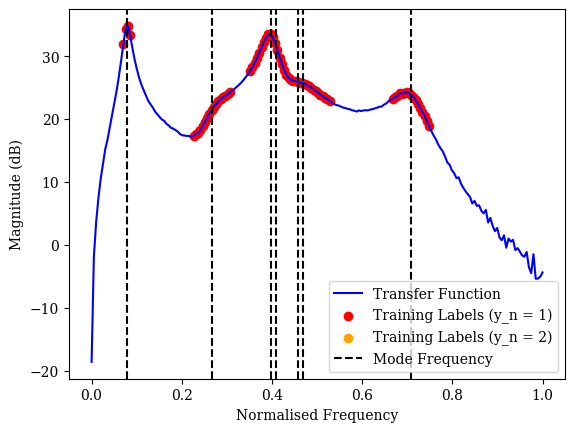

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [52]:
# visualise the generated training data
idx = np.random.randint(0, X.shape[0])
modal.plot_tf(X[idx], y[idx], ws=ws[idx], todb=True)

In [5]:
# train a model (binary classification)
neg_an_model = BiLSTM(input_size=2, hidden_size=100, num_layers=3, num_classes=1)
neg_an_model_results = modal.train_model_binary(neg_an_model, X, y, valX, valy, name='neg_an_model(14.01)', num_epochs=3)

Epoch [1/3], Loss: 0.7900508171319962, Precision: 0.7090640370658099, Recall: 0.5834607871054158
Validation Precision: 0.8585230135153288, Validation Recall: 0.8163369785301972
Epoch [2/3], Loss: 0.6736880071957906, Precision: 0.8076333148306264, Recall: 0.6168581234547968
Validation Precision: 0.8148635019415157, Validation Recall: 0.8973519166664339
Epoch [3/3], Loss: 0.6404190302888553, Precision: 0.8295835821841735, Recall: 0.6262986655805157
Validation Precision: 0.9130905696431687, Validation Recall: 0.8497669189113293


In [27]:
modal.plot_results(neg_an_model_results)

AttributeError: module 'modal' has no attribute 'plot_results'

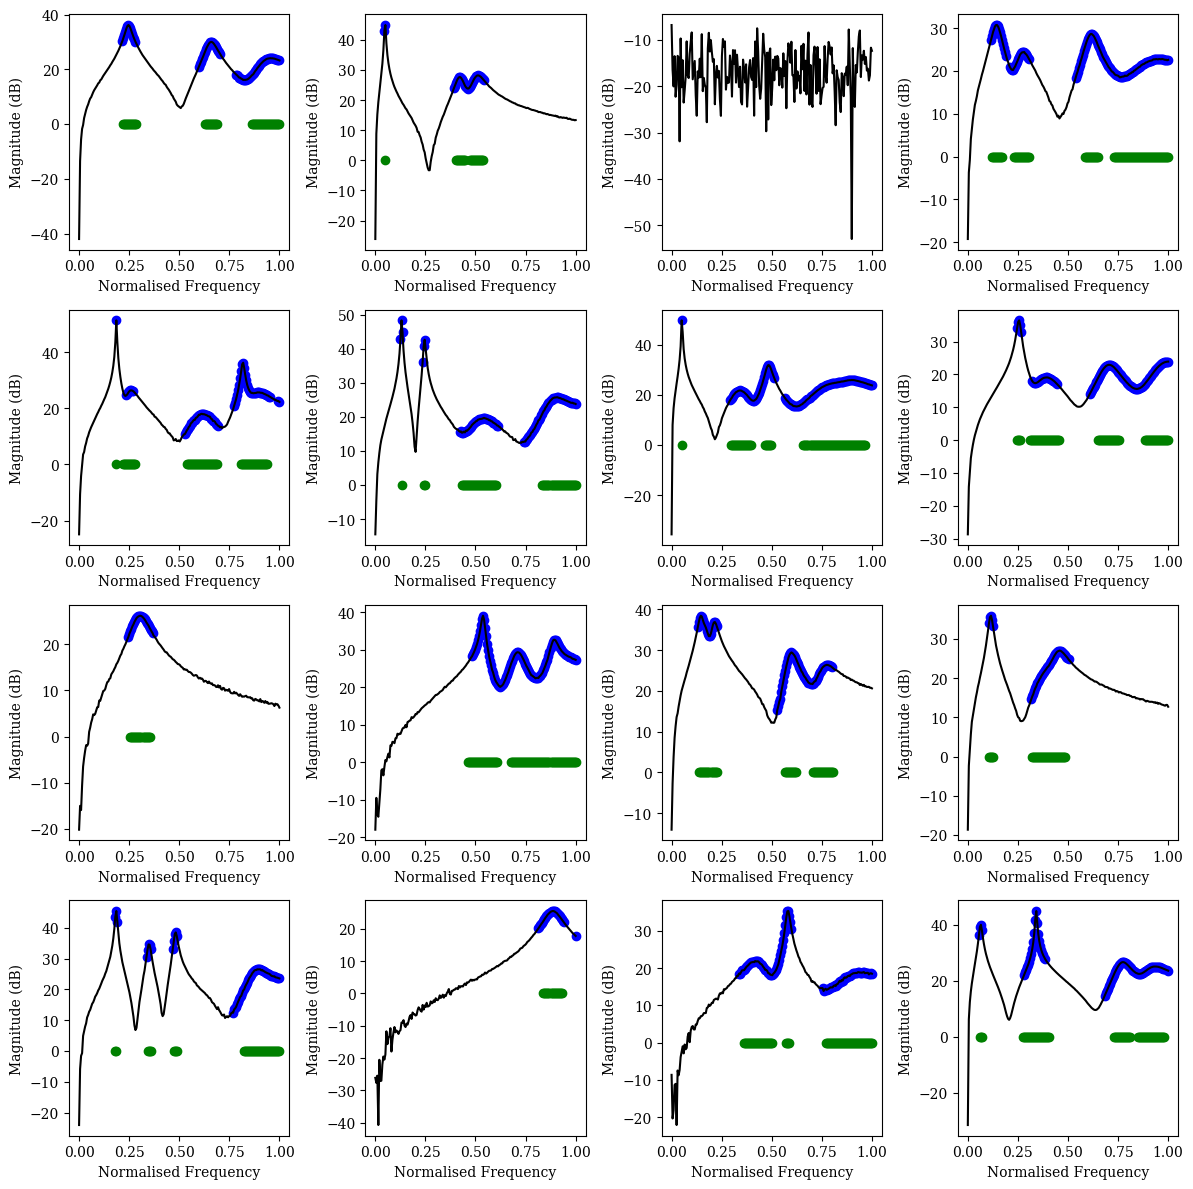

In [28]:
modal.validate_model(neg_an_model)

In [2]:
# load lab data
lab_tf = lab.load_data()

2024-01-14 15:44:00.760 python[30266:12446113] +[CATransaction synchronize] called within transaction


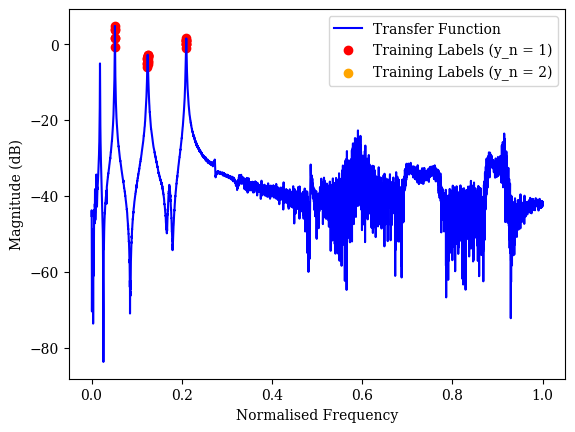

In [30]:
lab.lab_predictions(neg_an_model, lab_tf)

#### Now try with normalisation

In [3]:
X, y, ws, __ = modal.generate_data(num_data=32*300, num_w_points=200, neg_an=True, normalise=modal.normalise_rms)  # sigma_max = 0.15, max_modes = 7 (defaults)
valX, valy, _, __ = modal.generate_data(num_data=32*50, num_w_points=200, neg_an=True, normalise=modal.normalise_rms)

In [7]:
print( 1/(np.sum(y) / (y.shape[0] * y.shape[1])))

3.6678880224352484


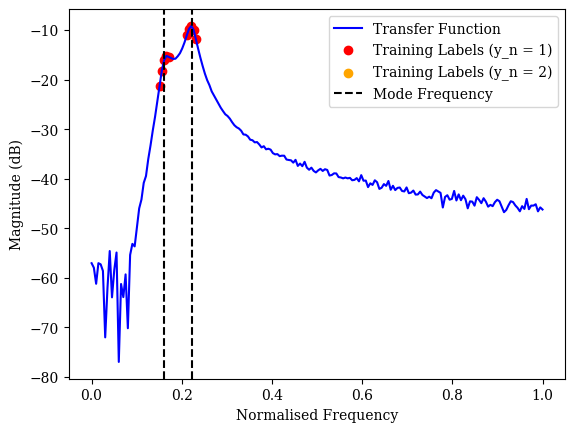

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [5]:
# visualise the generated training data
idx = np.random.randint(0, X.shape[0])
modal.plot_tf(X[idx], y[idx], ws=ws[idx], todb=True)

In [13]:
neg_an_model_norm = BiLSTM(input_size=2, hidden_size=100, num_layers=3, num_classes=1)
neg_an_model_norm_results = modal.train_model_binary(neg_an_model_norm, X, y, valX, valy, name='neg_an_model_norm(14.01)', num_epochs=10, weight=2.0)

Epoch [1/10], Loss: 0.8732882324854533, Precision: 0.0010759075907590759, Recall: 0.0003788935378893538
Validation Precision: 0.0, Validation Recall: 0.0
Epoch [2/10], Loss: 0.7776329813400904, Precision: 0.5183614985615435, Recall: 0.21851916853728284
Validation Precision: 0.8073119132274565, Validation Recall: 0.7038004409681498
Epoch [3/10], Loss: 0.5443490215142568, Precision: 0.8389997592854043, Recall: 0.5276270193214053
Validation Precision: 0.8855733307194339, Validation Recall: 0.73266955970326
Epoch [4/10], Loss: 0.4857099301616351, Precision: 0.87404979545437, Recall: 0.5693410046897487
Validation Precision: 0.9271710445789517, Validation Recall: 0.757135685186322
Epoch [5/10], Loss: 0.48647664219141007, Precision: 0.8761814002975823, Recall: 0.565926545062695
Validation Precision: 0.7517382774923692, Validation Recall: 0.7215468313012614
Epoch [6/10], Loss: 0.4975539619723956, Precision: 0.8643836159801674, Recall: 0.5582741882603097
Validation Precision: 0.9126149953375091

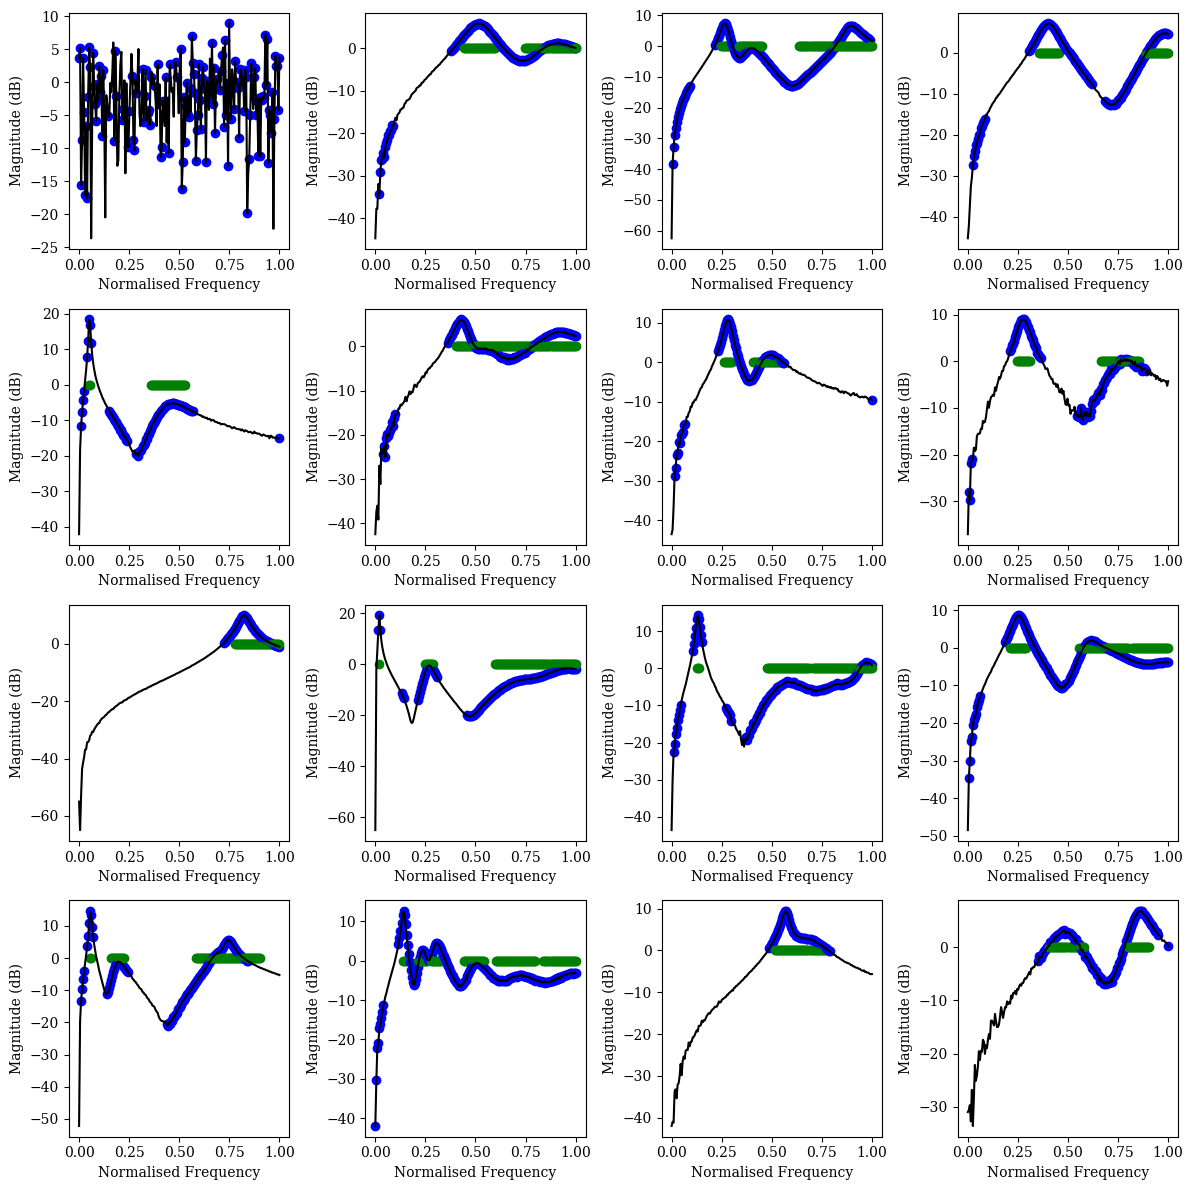

In [14]:
modal.validate_model(neg_an_model_norm, normalise=modal.normalise_rms)

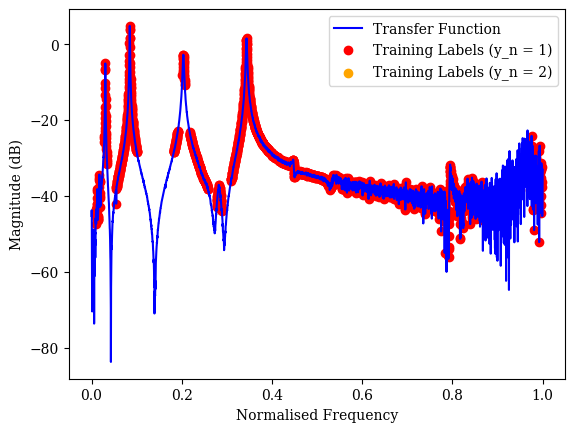

In [64]:
lab.lab_predictions(neg_an_model_norm, lab_tf[:5000])

#### Plotting predictive probabilities alongside transfer functions

In [23]:
def to_db(x):
    """Converts a vector (split or not) to dB"""
    if x.shape[-1] == 2:
        return 20 * np.log10(np.linalg.norm(x, axis=-1))
    return 20 * np.log10(np.abs(x))  

In [24]:
from torch.utils.data import DataLoader, TensorDataset

In [25]:
def modal_sum(w, a_n, z_n, w_n, sigma=0.1, multiclass = False):
    """Returns transfer function and labels for a modal sum system.
    Additive Gaussian noise added independently to real and imaginary parts."""
    tf = np.zeros_like(w, dtype=np.complex128)
    for i in range(len(a_n)):
        tf += a_n[i] *1j * w / (w_n[i]**2 - w**2 + 1j * 2 * z_n[i] * w * w_n[i])
    noise = np.random.normal(0, sigma, len(w)) + 1j * np.random.normal(0, sigma, len(w))
    tf += noise

    y = np.zeros(len(w))
    for i, w_n_value in enumerate(w_n):
        closest_index = np.argmin(np.abs(w - w_n_value))        
        dw = w_n_value * z_n[i] # Half power bandwidth
        indices_in_range = np.where((w > w_n_value - dw) & (w < w_n_value + dw))
        combined_indices = np.concatenate((indices_in_range[0], [closest_index]))

        if multiclass:
            y[combined_indices] = np.where(y[combined_indices] == 0, 1, 2)
        else:
            y[combined_indices] = 1
    return tf, y

In [26]:
def split_real_imag(x: np.ndarray) -> np.ndarray:
    """Splits a complex vector into real and imaginary parts.
    Input: (N, 1)
    Output: (N, 2)
    """
    return np.column_stack((np.real(x), np.imag(x)))

In [27]:
def generate_data(num_data, num_w_points, sigma_max = 0.15, max_modes = 7,
                multiclass = False, normalise = None, neg_an=False):
    """Generate num_data training examples with num_w_points frequency points.
    Pass normalisation function as a parameter.
    X: (num_data, num_w_points, 2)
    Y: (num_data, num_w_points)
    ws: (num_data, max_modes)
    zs: (num_data, max_modes)"""
    X = []
    Y = []
    ws = []
    zs = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, max_modes + 1)
        w_n = np.random.uniform(0, 1, num_modes)
        if neg_an:
            a_n = np.random.uniform(-2, 2, num_modes)
        else:
            a_n = np.random.uniform(1, 2, num_modes)
        z_n = np.random.uniform(0.01, 0.20, num_modes)
        sigma = np.random.uniform(0.01, sigma_max)
        out, y = modal_sum(w, a_n, z_n, w_n, sigma, multiclass)

        if normalise is not None:
            out = normalise(out)
        ws.append(w_n)
        zs.append(z_n)
        X.append(split_real_imag(out))
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs

In [28]:
def plot_predictions_with_probs(model, normalise=None, multiclass=False, sigma_max=0.15, num_w_points=200):
    """Plot 4x4 grid of predictions on a validation set of data.
    val_inputs: (num_data, num_w_points, 2)
    val_outputs: (num_data, num_w_points)
    val_targets: (num_data, num_w_points)"""

    valX, valy, _, __ = generate_data(32*1, num_w_points, multiclass=multiclass, normalise=normalise, sigma_max=sigma_max)
    val_X = torch.from_numpy(valX).to(torch.float32)
    if multiclass:
        val_y = torch.from_numpy(valy).to(torch.long)
    else:
        val_y = torch.from_numpy(valy).to(torch.float32)

    if normalise is not None:
        val_X = normalise(val_X)
    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs = model(val_inputs)

    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,8))
    w = np.linspace(0, 1, len(val_targets[0]))
    index = np.random.randint(0, len(val_targets))
    targets = np.array(val_targets[index].numpy())
    test_op = np.array(val_outputs[index].numpy())

    predicted = (test_op > 0.0).astype(int)
    ax[0].plot(w, to_db(val_inputs[index].numpy()), c='black')

    for i in range(len(w)):
        if i==0:
            if predicted[i] == 1:
                ax[0].scatter(w[i], to_db(val_inputs[index].numpy())[i], c='blue', marker='o', label = 'Model Predictions')
            if targets[i] == 1:
                ax[0].scatter(w[i], 0, c='green', marker='o', label='Training Labels (y_n = 1)')
        else:
            if predicted[i] == 1:
                ax[0].scatter(w[i], to_db(val_inputs[index].numpy())[i], c='blue', marker='o')
                # ax.legend()
            if targets[i] == 1:
                ax[0].scatter(w[i], 0, c='green', marker='o')
            
        ax[0].set_xlabel('Normalised Frequency')
        ax[0].set_ylabel('Magnitude (dB)')
    
    model_probs = 1 / (1 + np.exp(-test_op))
    ax[1].plot(w, targets, c='green', label='Training Labels (y_n = 1)')
    ax[1].plot(w, model_probs, c='blue', linestyle='--', label='Raw Model Predictions')
    # ax[1].plot(w, predicted, c='green',linestyle='--', label='Model Predictions')
    ax[1].set_xlabel('Normalised Frequency')
    ax[1].set_ylabel(r'$p(y_n = 1)$')
            
    plt.legend()
    plt.tight_layout()

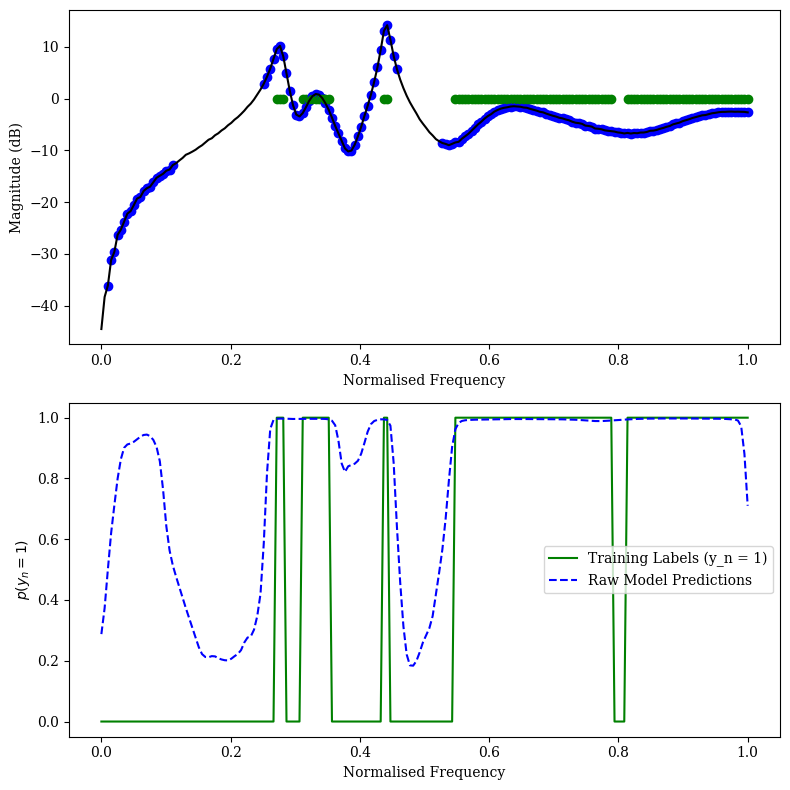

In [60]:
plot_predictions_with_probs(neg_an_model_norm, normalise=modal.normalise_rms, multiclass=False, sigma_max=0.15)

#### Trying again, more epochs

In [4]:
neg_an_model_longer = BiLSTM(input_size=2, hidden_size=100, num_layers=3, num_classes=1)
results_longer1 = modal.train(num_batches = 450, num_epochs=50, num_w_points=300, model=neg_an_model_longer, name='neg_an_model_longer(14.01)', neg_an=True)

  2%|▏         | 1/50 [04:03<3:18:41, 243.30s/it]

Epoch [1/50], Loss: 0.7731828513410356, Precision: 0.7299569270879985, Recall: 0.5845769915106378
Validation Precision: 0.8197035520656174, Validation Recall: 0.8642121585161012


  4%|▍         | 2/50 [08:07<3:14:50, 243.55s/it]

Epoch [2/50], Loss: 0.6664639641178979, Precision: 0.8128748346457466, Recall: 0.6194983708396161
Validation Precision: 0.886575851330317, Validation Recall: 0.8661641164728671


  6%|▌         | 3/50 [12:09<3:10:17, 242.92s/it]

Epoch [3/50], Loss: 0.6335414255327648, Precision: 0.8377505200961005, Recall: 0.6292858331782122
Validation Precision: 0.8455088893032993, Validation Recall: 0.8983984088122418


  8%|▊         | 4/50 [16:19<3:08:25, 245.77s/it]

Epoch [4/50], Loss: 0.6155815997388627, Precision: 0.8516009827552388, Recall: 0.6339419024600026
Validation Precision: 0.8796737773894568, Validation Recall: 0.8901827804598893


 10%|█         | 5/50 [20:22<3:03:37, 244.83s/it]

Epoch [5/50], Loss: 0.6046417527066337, Precision: 0.8588954310295033, Recall: 0.6361307081017946
Validation Precision: 0.9109915909881963, Validation Recall: 0.884946004742461


 12%|█▏        | 6/50 [24:19<2:57:41, 242.30s/it]

Epoch [6/50], Loss: 0.5928107506036758, Precision: 0.8674256100266104, Recall: 0.6393446424774779
Validation Precision: 0.8995667946693556, Validation Recall: 0.8986361176737483


 14%|█▍        | 7/50 [28:21<2:53:31, 242.14s/it]

Epoch [7/50], Loss: 0.5890866829951604, Precision: 0.8716794384306565, Recall: 0.640389816739902
Validation Precision: 0.8910272640659235, Validation Recall: 0.9149003240228101


 16%|█▌        | 8/50 [32:24<2:49:39, 242.37s/it]

Epoch [8/50], Loss: 0.5808435612254672, Precision: 0.8765732955235473, Recall: 0.6434195435911152
Validation Precision: 0.8928339395942724, Validation Recall: 0.9166373642879551


 18%|█▊        | 9/50 [36:20<2:44:11, 240.27s/it]

Epoch [9/50], Loss: 0.5795134019189411, Precision: 0.8825615480531237, Recall: 0.6430523789511776
Validation Precision: 0.8676824144197305, Validation Recall: 0.9259205696037965


 20%|██        | 10/50 [40:11<2:38:15, 237.39s/it]

Epoch [10/50], Loss: 0.5701703207360374, Precision: 0.885074349628048, Recall: 0.64676639273728
Validation Precision: 0.8734813535205087, Validation Recall: 0.9307080599852395


 22%|██▏       | 11/50 [44:06<2:33:48, 236.62s/it]

Epoch [11/50], Loss: 0.5655253733528985, Precision: 0.8870172711869071, Recall: 0.6471057807445357
Validation Precision: 0.9137721918971515, Validation Recall: 0.9161796414730639


 24%|██▍       | 12/50 [48:06<2:30:39, 237.87s/it]

Epoch [12/50], Loss: 0.5602638696961932, Precision: 0.8915315752193017, Recall: 0.648551237311244
Validation Precision: 0.927675913840381, Validation Recall: 0.9046640321955695


 26%|██▌       | 13/50 [52:07<2:27:07, 238.59s/it]

Epoch [13/50], Loss: 0.5668661703003778, Precision: 0.8865733703885362, Recall: 0.6460728503897453
Validation Precision: 0.9151700126838312, Validation Recall: 0.9132758760634346


 28%|██▊       | 14/50 [56:19<2:25:45, 242.92s/it]

Epoch [14/50], Loss: 0.5565079567167494, Precision: 0.8942864307923256, Recall: 0.6494365424191959
Validation Precision: 0.914751735540193, Validation Recall: 0.9200655520152087


 30%|███       | 15/50 [1:00:23<2:21:48, 243.11s/it]

Epoch [15/50], Loss: 0.5506851360532973, Precision: 0.8988418549663436, Recall: 0.6505861988392948
Validation Precision: 0.9261738892029765, Validation Recall: 0.9210724158717217


 32%|███▏      | 16/50 [1:04:27<2:17:53, 243.35s/it]

Epoch [16/50], Loss: 0.5450921448734072, Precision: 0.90112941798174, Recall: 0.6532480572982524
Validation Precision: 0.8930989048907448, Validation Recall: 0.9342766922378474


 34%|███▍      | 17/50 [1:08:34<2:14:27, 244.48s/it]

Epoch [17/50], Loss: 0.5433103593852785, Precision: 0.9020007009307903, Recall: 0.6541232515282059
Validation Precision: 0.9060097576516764, Validation Recall: 0.931630654078554


 36%|███▌      | 18/50 [1:12:43<2:11:02, 245.70s/it]

Epoch [18/50], Loss: 0.5422483889924156, Precision: 0.9027402100551782, Recall: 0.6545702752163327
Validation Precision: 0.9165995487082911, Validation Recall: 0.9291980352562597


 38%|███▊      | 19/50 [1:16:45<2:06:26, 244.74s/it]

Epoch [19/50], Loss: 0.5423188679748111, Precision: 0.9022803394800664, Recall: 0.6548823994566505
Validation Precision: 0.9064453215852815, Validation Recall: 0.9286850170881069


 40%|████      | 20/50 [1:20:43<2:01:18, 242.61s/it]

Epoch [20/50], Loss: 0.5393186285760667, Precision: 0.904322740454086, Recall: 0.6550858749287699
Validation Precision: 0.9193888639955436, Validation Recall: 0.9284958909195187


 42%|████▏     | 21/50 [1:24:43<1:56:53, 241.83s/it]

Epoch [21/50], Loss: 0.5353280221091377, Precision: 0.9074301072803547, Recall: 0.65615468918358
Validation Precision: 0.9174027714023769, Validation Recall: 0.9270069426859878


 44%|████▍     | 22/50 [1:28:42<1:52:33, 241.21s/it]

Epoch [22/50], Loss: 0.5341174572043949, Precision: 0.9085790377914496, Recall: 0.6565477796885051
Validation Precision: 0.9174241104733147, Validation Recall: 0.9296073051568915


 46%|████▌     | 23/50 [1:32:41<1:48:13, 240.50s/it]

Epoch [23/50], Loss: 0.5318073058128356, Precision: 0.9088311941275098, Recall: 0.6571560045461825
Validation Precision: 0.9294043387583603, Validation Recall: 0.9236032055989405


 48%|████▊     | 24/50 [1:36:38<1:43:44, 239.40s/it]

Epoch [24/50], Loss: 0.5300972064336141, Precision: 0.910351812855837, Recall: 0.6582615582739092
Validation Precision: 0.9155249770692578, Validation Recall: 0.9337883088098534


 50%|█████     | 25/50 [1:40:37<1:39:42, 239.28s/it]

Epoch [25/50], Loss: 0.5262086388137606, Precision: 0.9113022700776905, Recall: 0.6588077102690203
Validation Precision: 0.9361521272306458, Validation Recall: 0.9224892727477124


 52%|█████▏    | 26/50 [1:44:35<1:35:34, 238.94s/it]

Epoch [26/50], Loss: 0.5280086070299148, Precision: 0.9112256179361709, Recall: 0.6576940502281967
Validation Precision: 0.9072832843488322, Validation Recall: 0.9409444727723044


 54%|█████▍    | 27/50 [1:48:45<1:32:49, 242.16s/it]

Epoch [27/50], Loss: 0.52226860596074, Precision: 0.9138459375852939, Recall: 0.6601230962428054
Validation Precision: 0.9120674400171974, Validation Recall: 0.9358643126627436


 56%|█████▌    | 28/50 [1:52:57<1:29:52, 245.10s/it]

Epoch [28/50], Loss: 0.5231694920195473, Precision: 0.9135395872674832, Recall: 0.6596776127553208
Validation Precision: 0.9144344148111271, Validation Recall: 0.9292476705874207


 58%|█████▊    | 29/50 [1:57:09<1:26:30, 247.16s/it]

Epoch [29/50], Loss: 0.5179131580723657, Precision: 0.9144402121148442, Recall: 0.66189161375836
Validation Precision: 0.9308807437644078, Validation Recall: 0.9251399324187856


 60%|██████    | 30/50 [2:01:23<1:23:04, 249.22s/it]

Epoch [30/50], Loss: 0.5168745951520072, Precision: 0.9154718348999518, Recall: 0.6616200028833932
Validation Precision: 0.9275089713060177, Validation Recall: 0.9312242119319246


 62%|██████▏   | 31/50 [2:05:25<1:18:12, 246.95s/it]

Epoch [31/50], Loss: 0.5133207035726971, Precision: 0.916696051390769, Recall: 0.663306129790344
Validation Precision: 0.9084174442979718, Validation Recall: 0.9386055217781196


 64%|██████▍   | 32/50 [2:09:27<1:13:40, 245.59s/it]

Epoch [32/50], Loss: 0.5120271886057324, Precision: 0.9158214994400434, Recall: 0.662934226488168
Validation Precision: 0.9221769174829294, Validation Recall: 0.936581603767955


 66%|██████▌   | 33/50 [2:13:29<1:09:18, 244.64s/it]

Epoch [33/50], Loss: 0.5115049833059311, Precision: 0.9173717694388032, Recall: 0.6632024215817408
Validation Precision: 0.9102639102258475, Validation Recall: 0.9398766962562187


 68%|██████▊   | 34/50 [2:17:33<1:05:08, 244.28s/it]

Epoch [34/50], Loss: 0.5113624183336893, Precision: 0.9171712531530612, Recall: 0.6636851422004799
Validation Precision: 0.9278751203676875, Validation Recall: 0.9327063313260208


 70%|███████   | 35/50 [2:21:34<1:00:50, 243.38s/it]

Epoch [35/50], Loss: 0.5065213277604845, Precision: 0.9193755681603911, Recall: 0.6646815557237973
Validation Precision: 0.9308874189069147, Validation Recall: 0.9333435329280115


 72%|███████▏  | 36/50 [2:25:39<56:52, 243.74s/it]  

Epoch [36/50], Loss: 0.5039586802323659, Precision: 0.920520022627792, Recall: 0.6658663090380639
Validation Precision: 0.9113520280481456, Validation Recall: 0.9418242906861122


 74%|███████▍  | 37/50 [2:29:42<52:47, 243.62s/it]

Epoch [37/50], Loss: 0.5042873932255639, Precision: 0.920077616260217, Recall: 0.6660915631960355
Validation Precision: 0.9216887677995272, Validation Recall: 0.9359743121604791


 76%|███████▌  | 38/50 [2:33:45<48:41, 243.47s/it]

Epoch [38/50], Loss: 0.5036852234601974, Precision: 0.9210875243376695, Recall: 0.6671565168409673
Validation Precision: 0.9317275612547389, Validation Recall: 0.9350621433151323


 78%|███████▊  | 39/50 [2:37:46<44:28, 242.63s/it]

Epoch [39/50], Loss: 0.4985727353228463, Precision: 0.9224792983249162, Recall: 0.6678063935044587
Validation Precision: 0.922791954728679, Validation Recall: 0.9399549075945668


 80%|████████  | 40/50 [2:41:50<40:29, 242.99s/it]

Epoch [40/50], Loss: 0.49881620082590317, Precision: 0.9220868233687244, Recall: 0.6678243584801723
Validation Precision: 0.9256386379984626, Validation Recall: 0.9372473267948785


 82%|████████▏ | 41/50 [2:45:52<36:24, 242.69s/it]

Epoch [41/50], Loss: 0.49661978383859, Precision: 0.9228414076406218, Recall: 0.6690721198440445
Validation Precision: 0.9124123423775164, Validation Recall: 0.9381659453619436


 84%|████████▍ | 42/50 [2:49:54<32:21, 242.71s/it]

Epoch [42/50], Loss: 0.4991858768463135, Precision: 0.9201596496223188, Recall: 0.6684010797849428
Validation Precision: 0.9104586933746492, Validation Recall: 0.9431627851938088


 86%|████████▌ | 43/50 [2:53:57<28:19, 242.82s/it]

Epoch [43/50], Loss: 0.4968210983938641, Precision: 0.9227344206208732, Recall: 0.6684810731033339
Validation Precision: 0.9293659191617991, Validation Recall: 0.9322348701708869


 88%|████████▊ | 44/50 [2:57:59<24:14, 242.44s/it]

Epoch [44/50], Loss: 0.49959238330523176, Precision: 0.9222900349097154, Recall: 0.6673223419258337
Validation Precision: 0.9208183665088625, Validation Recall: 0.9395113249582916


 90%|█████████ | 45/50 [3:02:04<20:15, 243.11s/it]

Epoch [45/50], Loss: 0.4910268392165502, Precision: 0.9244710451727811, Recall: 0.6699532125134305
Validation Precision: 0.931404470642158, Validation Recall: 0.9334366757076837


 92%|█████████▏| 46/50 [3:06:09<16:14, 243.75s/it]

Epoch [46/50], Loss: 0.4908220238155789, Precision: 0.9250598144058717, Recall: 0.6707031259065444
Validation Precision: 0.9239517876966088, Validation Recall: 0.939150492540747


 94%|█████████▍| 47/50 [3:10:10<12:08, 242.99s/it]

Epoch [47/50], Loss: 0.48829621103074816, Precision: 0.9263281365235442, Recall: 0.6709415056344058
Validation Precision: 0.9210572790231872, Validation Recall: 0.937484350381684


 96%|█████████▌| 48/50 [3:14:13<08:05, 242.90s/it]

Epoch [48/50], Loss: 0.48656597435474397, Precision: 0.925361157200142, Recall: 0.6722619011947786
Validation Precision: 0.9298439034711234, Validation Recall: 0.9331955425347372


 98%|█████████▊| 49/50 [3:18:22<04:04, 244.85s/it]

Epoch [49/50], Loss: 0.48860522700680625, Precision: 0.9251637684840585, Recall: 0.6703410963121017
Validation Precision: 0.9204596505868958, Validation Recall: 0.9412450958417676


100%|██████████| 50/50 [3:22:29<00:00, 243.00s/it]

Epoch [50/50], Loss: 0.48183303303188746, Precision: 0.9281740077913968, Recall: 0.672730879148627
Validation Precision: 0.9228494111533935, Validation Recall: 0.9248274862755894


In [5]:
neg_an_model_norm_longer = BiLSTM(input_size=2, hidden_size=100, num_layers=3, num_classes=1)
results_longer2 = modal.train(num_batches = 450, num_epochs=50, num_w_points=300, model=neg_an_model_norm_longer, name='neg_an_model_norm_longer(14.01)', neg_an=True, normalise=modal.normalise_rms)

  2%|▏         | 1/50 [03:35<2:55:56, 215.43s/it]

Epoch [1/50], Loss: 1.229942016336653, Precision: 0.08083984587673758, Recall: 0.1319271513215061
Validation Precision: 0.0, Validation Recall: 0.0


  4%|▍         | 2/50 [07:14<2:54:06, 217.64s/it]

Epoch [2/50], Loss: 1.2286324879858228, Precision: 0.06776052934471537, Recall: 0.08575278687607454
Validation Precision: 0.0, Validation Recall: 0.0


  6%|▌         | 3/50 [10:53<2:51:01, 218.34s/it]

Epoch [3/50], Loss: 1.166248620086246, Precision: 0.319509585454352, Recall: 0.43668673545051534
Validation Precision: 0.3898618580750256, Validation Recall: 0.5425590667188375


  8%|▊         | 4/50 [14:30<2:47:02, 217.88s/it]

Epoch [4/50], Loss: 1.1533383703231812, Precision: 0.369038808860972, Recall: 0.5138281648176495
Validation Precision: 0.39076652579185206, Validation Recall: 0.5287301350093948


 10%|█         | 5/50 [18:08<2:43:19, 217.77s/it]

Epoch [5/50], Loss: 1.1523309151331584, Precision: 0.3732600285861726, Recall: 0.5019137250446815
Validation Precision: 0.3890763853825565, Validation Recall: 0.5555676919573282


 12%|█▏        | 6/50 [21:48<2:40:21, 218.67s/it]

Epoch [6/50], Loss: 1.1526458292537265, Precision: 0.37200546023531916, Recall: 0.5008306335194961
Validation Precision: 0.3810822809012732, Validation Recall: 0.6645713349345928


 14%|█▍        | 7/50 [25:25<2:36:19, 218.12s/it]

Epoch [7/50], Loss: 1.1527808719211154, Precision: 0.3719772711739856, Recall: 0.5014973287984973
Validation Precision: 0.3903270290331138, Validation Recall: 0.533767228895565


 16%|█▌        | 8/50 [29:08<2:33:37, 219.47s/it]

Epoch [8/50], Loss: 1.0614751509825389, Precision: 0.47212398878041567, Recall: 0.5084638356290474
Validation Precision: 0.763975977677239, Validation Recall: 0.7007809406492241


 18%|█▊        | 9/50 [32:49<2:30:26, 220.16s/it]

Epoch [9/50], Loss: 0.7869130370352003, Precision: 0.7186688534726551, Recall: 0.5785070550382626
Validation Precision: 0.8000021531995698, Validation Recall: 0.8287209604427946


 20%|██        | 10/50 [36:31<2:27:06, 220.67s/it]

Epoch [10/50], Loss: 0.711661863591936, Precision: 0.776494789395351, Recall: 0.5989125264574603
Validation Precision: 0.8600635054728424, Validation Recall: 0.8222758596255473


 22%|██▏       | 11/50 [40:11<2:23:17, 220.45s/it]

Epoch [11/50], Loss: 0.6608741594023174, Precision: 0.8100390326853133, Recall: 0.6169561369017363
Validation Precision: 0.8937371054714726, Validation Recall: 0.8383149114872561


 24%|██▍       | 12/50 [43:54<2:20:01, 221.09s/it]

Epoch [12/50], Loss: 0.6402417984273698, Precision: 0.8294439569654988, Recall: 0.6223189828622518
Validation Precision: 0.8817003119957858, Validation Recall: 0.8753449606380798


 26%|██▌       | 13/50 [47:39<2:17:11, 222.46s/it]

Epoch [13/50], Loss: 0.6195949796835581, Precision: 0.8443655956977267, Recall: 0.6294948658600861
Validation Precision: 0.8999443472145431, Validation Recall: 0.8893047223462006


 28%|██▊       | 14/50 [51:25<2:13:58, 223.30s/it]

Epoch [14/50], Loss: 0.607405750685268, Precision: 0.8535585256323646, Recall: 0.6331382180612564
Validation Precision: 0.8985918464117895, Validation Recall: 0.8856075647389093


 30%|███       | 15/50 [55:08<2:10:17, 223.36s/it]

Epoch [15/50], Loss: 0.5982423567109638, Precision: 0.8592861282483286, Recall: 0.6368005531348666
Validation Precision: 0.8843280343191138, Validation Recall: 0.9136785118272535


 32%|███▏      | 16/50 [58:53<2:06:46, 223.74s/it]

Epoch [16/50], Loss: 0.587776194413503, Precision: 0.8672063497932866, Recall: 0.639370588486415
Validation Precision: 0.8949358593970408, Validation Recall: 0.9019167879037674


 34%|███▍      | 17/50 [1:02:37<2:03:03, 223.76s/it]

Epoch [17/50], Loss: 0.5807439178890652, Precision: 0.8726567149378045, Recall: 0.6421253382897066
Validation Precision: 0.9111734138684796, Validation Recall: 0.9143752811310939


 36%|███▌      | 18/50 [1:06:22<1:59:33, 224.16s/it]

Epoch [18/50], Loss: 0.5753636778063245, Precision: 0.8766871050790226, Recall: 0.6430826020087255
Validation Precision: 0.9026775311595093, Validation Recall: 0.914691000944813


 38%|███▊      | 19/50 [1:10:06<1:55:48, 224.15s/it]

Epoch [19/50], Loss: 0.5761864974101385, Precision: 0.8763908606855959, Recall: 0.6431036980698782
Validation Precision: 0.9080184070440825, Validation Recall: 0.8876367436044456


 40%|████      | 20/50 [1:13:49<1:51:54, 223.80s/it]

Epoch [20/50], Loss: 0.5663174555699031, Precision: 0.885793141674996, Recall: 0.6457292765953863
Validation Precision: 0.9211538798983692, Validation Recall: 0.9118224096834713


 42%|████▏     | 21/50 [1:17:34<1:48:21, 224.17s/it]

Epoch [21/50], Loss: 0.5604294649097654, Precision: 0.8884771841718888, Recall: 0.6478582779965187
Validation Precision: 0.9136602789669309, Validation Recall: 0.9223157354691979


 44%|████▍     | 22/50 [1:21:20<1:44:54, 224.81s/it]

Epoch [22/50], Loss: 0.5552149832248687, Precision: 0.8912034653934704, Recall: 0.6505251700281791
Validation Precision: 0.9238466821211366, Validation Recall: 0.9157040489926509


 46%|████▌     | 23/50 [1:25:05<1:41:07, 224.72s/it]

Epoch [23/50], Loss: 0.5510785032643212, Precision: 0.8944085662867683, Recall: 0.6505235296745667
Validation Precision: 0.9360016971569549, Validation Recall: 0.9138110298484755


 48%|████▊     | 24/50 [1:28:50<1:37:28, 224.92s/it]

Epoch [24/50], Loss: 0.549152174393336, Precision: 0.8971815099627118, Recall: 0.6510238145507842
Validation Precision: 0.9075436141698499, Validation Recall: 0.9211866125089154


 50%|█████     | 25/50 [1:32:36<1:33:51, 225.26s/it]

Epoch [25/50], Loss: 0.5444001818365521, Precision: 0.899703119777711, Recall: 0.6533983627556009
Validation Precision: 0.9442126747653348, Validation Recall: 0.9131401366778242


 52%|█████▏    | 26/50 [1:36:20<1:29:58, 224.93s/it]

Epoch [26/50], Loss: 0.543143032391866, Precision: 0.9002107561142632, Recall: 0.6534582354277514
Validation Precision: 0.8922500490522717, Validation Recall: 0.937925195586342


 54%|█████▍    | 27/50 [1:40:08<1:26:36, 225.92s/it]

Epoch [27/50], Loss: 0.542138588031133, Precision: 0.9019001643543934, Recall: 0.6537269594295917
Validation Precision: 0.9304143633213322, Validation Recall: 0.9237614512106334


 56%|█████▌    | 28/50 [1:43:55<1:22:52, 226.04s/it]

Epoch [28/50], Loss: 0.5379615223407745, Precision: 0.9020289382026424, Recall: 0.6552505516184312
Validation Precision: 0.9311629926311517, Validation Recall: 0.9166337197234079


 58%|█████▊    | 29/50 [1:47:39<1:18:58, 225.64s/it]

Epoch [29/50], Loss: 0.5368917719523112, Precision: 0.9046795275565668, Recall: 0.6550040198976669
Validation Precision: 0.9383878195670629, Validation Recall: 0.9219836401396531


 60%|██████    | 30/50 [1:51:24<1:15:07, 225.39s/it]

Epoch [30/50], Loss: 0.5390494300921758, Precision: 0.903486674713131, Recall: 0.6544287289265234
Validation Precision: 0.9404483245466616, Validation Recall: 0.9215103888714339


 62%|██████▏   | 31/50 [1:55:14<1:11:45, 226.62s/it]

Epoch [31/50], Loss: 0.5344963567124472, Precision: 0.9056192749194477, Recall: 0.6552710571683845
Validation Precision: 0.9260624036804338, Validation Recall: 0.9359908267279511


 64%|██████▍   | 32/50 [1:59:02<1:08:06, 227.00s/it]

Epoch [32/50], Loss: 0.5289356666141086, Precision: 0.9086595163097478, Recall: 0.6576408897677152
Validation Precision: 0.9175056081490901, Validation Recall: 0.9339646414797136


 66%|██████▌   | 33/50 [2:02:49<1:04:19, 227.00s/it]

Epoch [33/50], Loss: 0.5289618604713016, Precision: 0.909733856180139, Recall: 0.6574536305139266
Validation Precision: 0.9236110536196208, Validation Recall: 0.9359723405325241


 68%|██████▊   | 34/50 [2:06:37<1:00:38, 227.42s/it]

Epoch [34/50], Loss: 0.5264236964119805, Precision: 0.9090746227790145, Recall: 0.6582747508461532
Validation Precision: 0.9404666964591475, Validation Recall: 0.9324584744104619


 70%|███████   | 35/50 [2:10:25<56:53, 227.60s/it]  

Epoch [35/50], Loss: 0.5284535326560338, Precision: 0.9100448646679752, Recall: 0.6578418775933518
Validation Precision: 0.9317967732271759, Validation Recall: 0.9375124333903704


 72%|███████▏  | 36/50 [2:14:11<53:00, 227.20s/it]

Epoch [36/50], Loss: 0.5213012682067023, Precision: 0.9143834168805328, Recall: 0.65993469919797
Validation Precision: 0.9162157574766668, Validation Recall: 0.9427098365889517


 74%|███████▍  | 37/50 [2:17:58<49:11, 227.03s/it]

Epoch [37/50], Loss: 0.5220841103792191, Precision: 0.9134042669337742, Recall: 0.6593620102879317
Validation Precision: 0.9466398134578657, Validation Recall: 0.922698590898791


 76%|███████▌  | 38/50 [2:21:45<45:25, 227.13s/it]

Epoch [38/50], Loss: 0.5208323001861572, Precision: 0.9133819065194777, Recall: 0.6604551051757893
Validation Precision: 0.9357740059387262, Validation Recall: 0.939577089132509


 78%|███████▊  | 39/50 [2:25:34<41:43, 227.59s/it]

Epoch [39/50], Loss: 0.5199193682273229, Precision: 0.9147241965854764, Recall: 0.660609764963137
Validation Precision: 0.921148420647262, Validation Recall: 0.9431573470572847


 80%|████████  | 40/50 [2:29:22<37:57, 227.76s/it]

Epoch [40/50], Loss: 0.5158103000455433, Precision: 0.9169238140820976, Recall: 0.66139195968363
Validation Precision: 0.9254511939790215, Validation Recall: 0.940639130362942


 82%|████████▏ | 41/50 [2:33:09<34:07, 227.53s/it]

Epoch [41/50], Loss: 0.5209152091211743, Precision: 0.9137115219901617, Recall: 0.6600916408452733
Validation Precision: 0.9475387902845972, Validation Recall: 0.923141352978395


 84%|████████▍ | 42/50 [2:36:57<30:20, 227.58s/it]

Epoch [42/50], Loss: 0.5180202901363373, Precision: 0.9152941582688129, Recall: 0.660803031026571
Validation Precision: 0.9308698639919608, Validation Recall: 0.9399449414541028


 86%|████████▌ | 43/50 [2:40:44<26:31, 227.39s/it]

Epoch [43/50], Loss: 0.5144381375445259, Precision: 0.9168388110160548, Recall: 0.6627795447273872
Validation Precision: 0.9383002542522558, Validation Recall: 0.9264180730288101


 88%|████████▊ | 44/50 [2:44:32<22:44, 227.50s/it]

Epoch [44/50], Loss: 0.5149678964085049, Precision: 0.9167073997472216, Recall: 0.6626391852749217
Validation Precision: 0.9322512562226517, Validation Recall: 0.938385231372473


 90%|█████████ | 45/50 [2:48:21<19:00, 228.06s/it]

Epoch [45/50], Loss: 0.5103487711482578, Precision: 0.9187807621563089, Recall: 0.6629952723695486
Validation Precision: 0.9352578321096117, Validation Recall: 0.9414607952932452


 92%|█████████▏| 46/50 [2:52:09<15:12, 228.10s/it]

Epoch [46/50], Loss: 0.5092653396394518, Precision: 0.9202579656545473, Recall: 0.6636711996385086
Validation Precision: 0.9425342462039142, Validation Recall: 0.9369607723211417


 94%|█████████▍| 47/50 [2:55:56<11:22, 227.60s/it]

Epoch [47/50], Loss: 0.5087487048572964, Precision: 0.9197826684915082, Recall: 0.6639214824800757
Validation Precision: 0.9490085185705475, Validation Recall: 0.9343150500856339


 96%|█████████▌| 48/50 [2:59:41<07:33, 226.87s/it]

Epoch [48/50], Loss: 0.5072670737902324, Precision: 0.9193697283021957, Recall: 0.6649029259767867
Validation Precision: 0.9206503463473739, Validation Recall: 0.9466059612670102


 98%|█████████▊| 49/50 [3:03:28<03:46, 226.94s/it]

Epoch [49/50], Loss: 0.5063038220008215, Precision: 0.9207639494410793, Recall: 0.6644443206616136
Validation Precision: 0.9275515962256766, Validation Recall: 0.9413826890653999


100%|██████████| 50/50 [3:07:12<00:00, 224.66s/it]

Epoch [50/50], Loss: 0.5130965903070238, Precision: 0.9174942894604343, Recall: 0.6626155162336349
Validation Precision: 0.940737736913707, Validation Recall: 0.9380524377994377


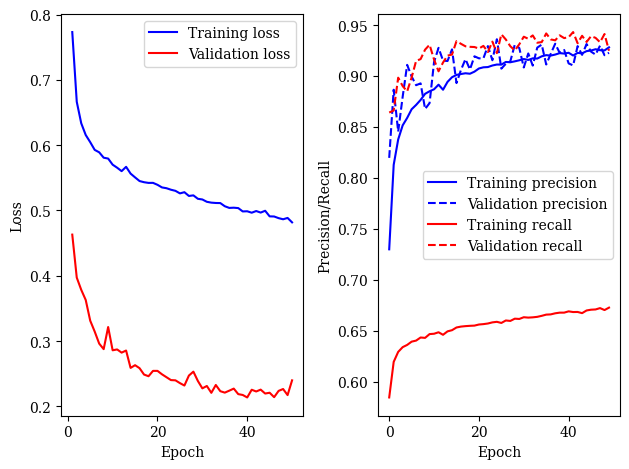

In [6]:
modal.plot_results(results_longer1)

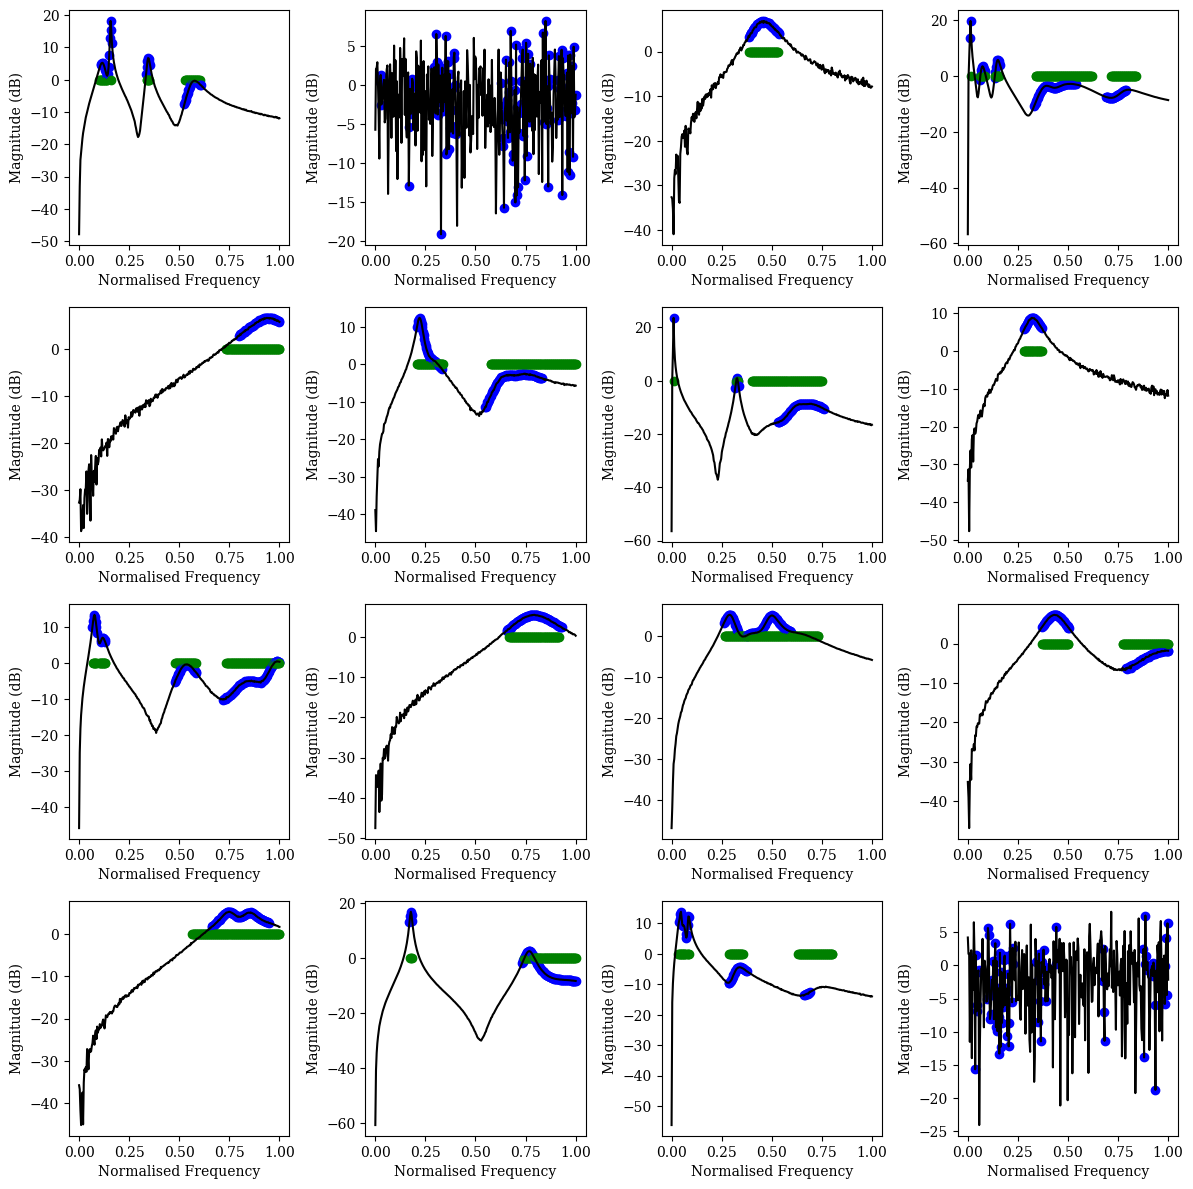

In [12]:
modal.validate_model(neg_an_model_longer, num_w_points=300, normalise=modal.normalise_rms)

In [63]:
lab_tf = lab.load_data()

2024-01-15 14:43:44.602 python[48792:12733242] +[CATransaction synchronize] called within transaction


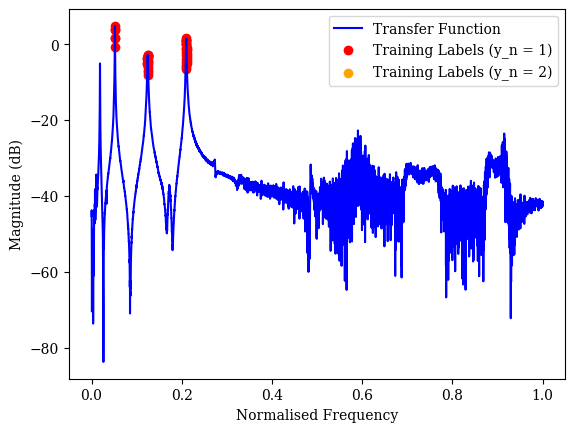

In [15]:
lab.lab_predictions(neg_an_model_longer, lab_tf)

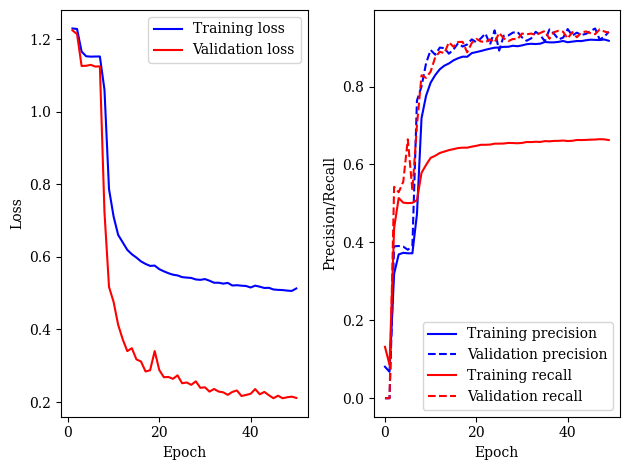

In [7]:
modal.plot_results(results_longer2)

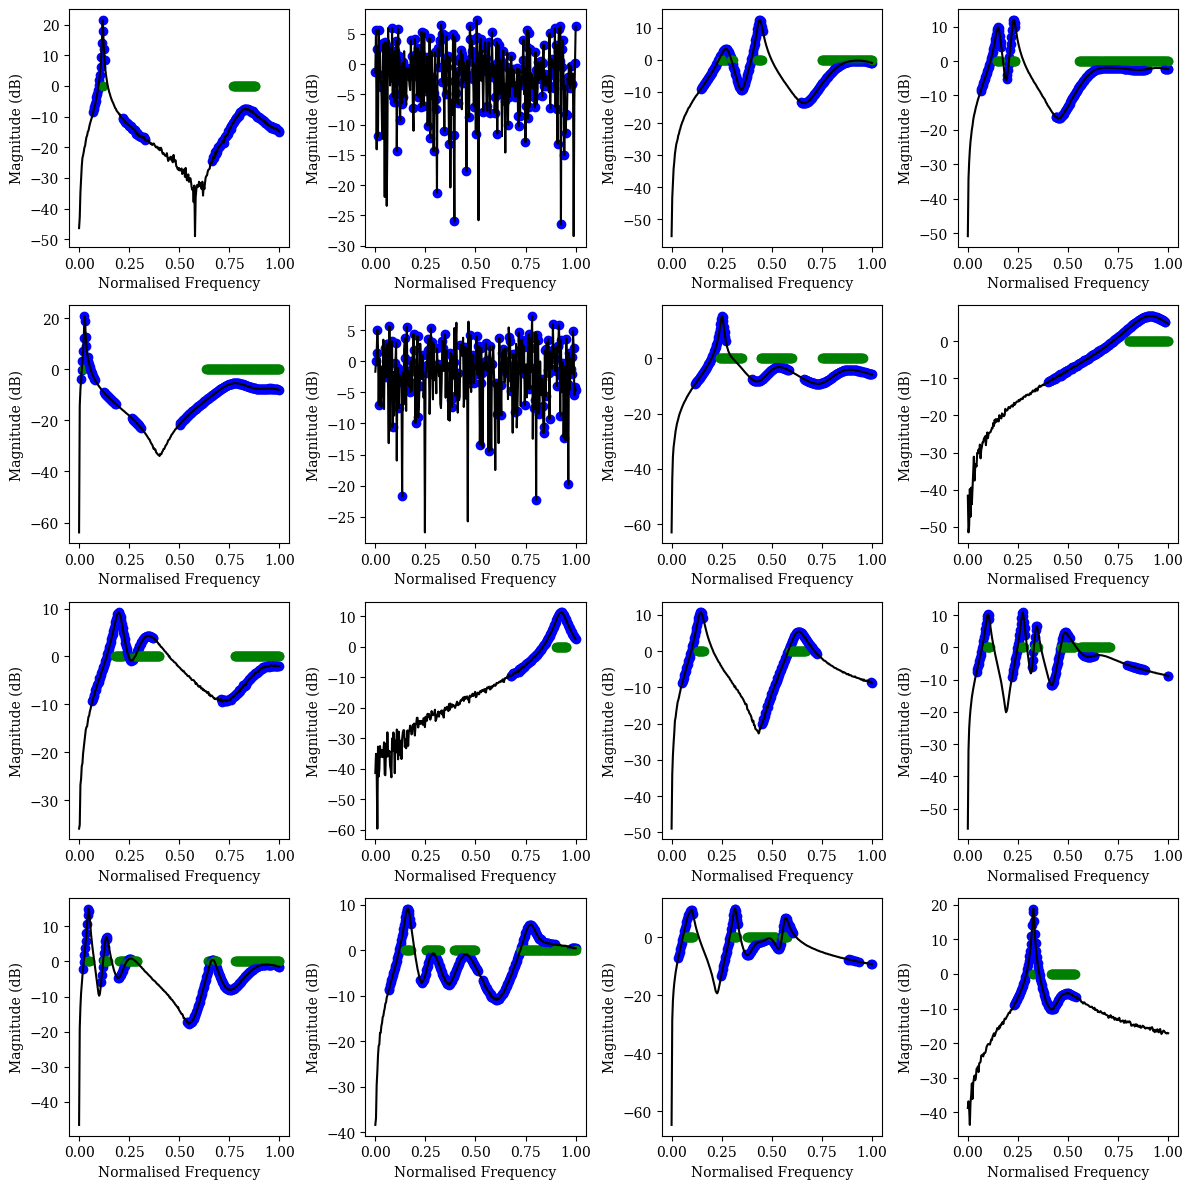

In [11]:
modal.validate_model(neg_an_model_norm_longer, num_w_points=300, normalise=modal.normalise_rms)

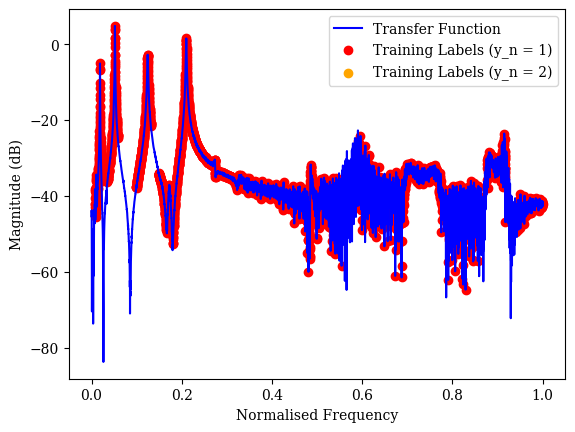

In [16]:
lab.lab_predictions(neg_an_model_norm_longer, lab_tf)

## 15/01

### Adding phased and magnitude information into model to see if that impacts anything

In [45]:
def generate_dat_extended(num_data, num_w_points, sigma_max = 0.15, max_modes = 7,
                multiclass = False, normalise = None, neg_an=False):
    """Generate num_data training examples with num_w_points frequency points.
    Pass normalisation function as a parameter. Include phase and magnintude 
    information in the output.
    X: (num_data, num_w_points, 4)
    Y: (num_data, num_w_points)
    ws: (num_data, max_modes)
    zs: (num_data, max_modes)"""
    X = []
    Y = []
    ws = []
    zs = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, max_modes + 1)
        w_n = np.random.uniform(0, 1, num_modes)
        if neg_an:
            a_n = np.random.uniform(-2, 2, num_modes)
        else:
            a_n = np.random.uniform(1, 2, num_modes)
        z_n = np.random.uniform(0.01, 0.20, num_modes)
        sigma = np.random.uniform(0.01, sigma_max)
        out, y = modal_sum(w, a_n, z_n, w_n, sigma, multiclass)

        if normalise is not None:
            out = normalise(out)

        real_imag = split_real_imag(out)
        phase = np.arctan(np.imag(out)/np.real(out))
        mag = np.abs(out)
        extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1)), axis=1)

        ws.append(w_n)
        zs.append(z_n)
        X.append(extended_op)
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs

In [224]:
def plot_predictions_extended(model, num_w_points=200, normalise=None, neg_an=True, multiclass=False, nrows=4, ncols=4,s=20):
    """Plot 4x4 grid of predictions on a validation set of data.
    val_inputs: (num_data, num_w_points, 2)
    val_outputs: (num_data, num_w_points)
    val_targets: (num_data, num_w_points)"""

    valX, valy, _, __ = generate_dat_extended(32*1, num_w_points, multiclass=multiclass, normalise=normalise, neg_an=neg_an)
    val_X = torch.from_numpy(valX).to(torch.float32)
    if multiclass:
        val_y = torch.from_numpy(valy).to(torch.long)
    else:
        val_y = torch.from_numpy(valy).to(torch.float32)

    if normalise is not None:
        val_X = normalise(val_X)
    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs = model(val_inputs)

    fig, axs = plt.subplots(nrows =nrows, ncols = ncols, figsize=(12,12))

    w = np.linspace(0, 1, len(val_targets[0]))
    for index, ax in enumerate(axs.flat):

        targets = np.array(val_targets[index].numpy())
        test_op = np.array(val_outputs[index].numpy())

        tf = val_inputs[index].numpy()[:,:2]

        if multiclass:
            predicted = np.argmax(test_op, axis=-1)
            ax.plot(w, to_db(tf), c='black')

            for i in range(len(w)):
                if predicted[i] == 1:
                    ax.scatter(w[i], to_db(tf)[i], c='red', marker='o', label = 'Model Predictions', s=s)
                if predicted[i] == 2:
                    ax.scatter(w[i], to_db(tf)[i], c='orange', marker='o', s=s)
                if targets[i] == 1:
                    ax.scatter(w[i], 0, c='green', marker='o', label=r'Training Labels ($y_n = 1$)', s=s)
                if targets[i] == 2:
                    ax.scatter(w[i], 0, c='blue', marker='o',s=s)

            ax.set_xlabel('Normalised Frequency')
            ax.set_ylabel('Magnitude (dB)')
            # ax.legend()
        else:
            predicted = (test_op > 0.0).astype(int)
            ax.plot(w, to_db(tf), c='black')

            for i in range(len(w)):
                if i==0:
                    if predicted[i] == 1:
                        ax.scatter(w[i], to_db(tf)[i], c='blue', marker='o', label = 'Model Predictions')
                    if targets[i] == 1:
                        ax.scatter(w[i], 0, c='green', marker='o', label=r'Training Labels ($y_n = 1$)')
                else:
                    if predicted[i] == 1:
                        ax.scatter(w[i], to_db(tf)[i], c='blue', marker='o')
                        # ax.legend()
                    if targets[i] == 1:
                        ax.scatter(w[i], 0, c='green', marker='o')
                
            ax.set_xlabel('Normalised Frequency')
            ax.set_ylabel('Magnitude (dB)')
            
    # plt.legend()
    plt.tight_layout()

In [52]:
X, y, _, __ = generate_dat_extended(num_data=32*450, num_w_points=200, neg_an=True)  # sigma_max = 0.15, max_modes = 7 (defaults)
valX, valy, _, __ = generate_dat_extended(num_data=32*50, num_w_points=200, neg_an=True)

In [53]:
extended_model = BiLSTM(input_size=4, hidden_size=100, num_layers=3, num_classes=1)
extended_model_results = modal.train_model_binary(extended_model, X, y, valX, valy, name='extended_model(15.01)', num_epochs=10)

 10%|█         | 1/10 [02:37<23:35, 157.24s/it]

Epoch [1/10], Loss: 0.7722085373931461, Precision: 0.7304059251728835, Recall: 0.5841276070628799
Validation Precision: 0.7844951260914479, Validation Recall: 0.8916162878767914


 20%|██        | 2/10 [05:19<21:20, 160.11s/it]

Epoch [2/10], Loss: 0.6658843388822344, Precision: 0.8196375840874353, Recall: 0.6161505368044179
Validation Precision: 0.8575500846355244, Validation Recall: 0.8849992593462894


 30%|███       | 3/10 [07:58<18:38, 159.77s/it]

Epoch [3/10], Loss: 0.6304549827840593, Precision: 0.8414139935207495, Recall: 0.6254470999384559
Validation Precision: 0.9119209480470909, Validation Recall: 0.8628053959628681


 40%|████      | 4/10 [10:39<16:01, 160.20s/it]

Epoch [4/10], Loss: 0.6103276820977529, Precision: 0.8579338553754983, Recall: 0.6336165170995081
Validation Precision: 0.8933402870716268, Validation Recall: 0.8910571633048608


 50%|█████     | 5/10 [13:16<13:15, 159.06s/it]

Epoch [5/10], Loss: 0.6085919590128792, Precision: 0.8623650102257839, Recall: 0.6339573661106255
Validation Precision: 0.8831659754026479, Validation Recall: 0.9079222781004507


 60%|██████    | 6/10 [15:49<10:27, 156.97s/it]

Epoch [6/10], Loss: 0.5895748168230057, Precision: 0.870432758042704, Recall: 0.6404909387184211
Validation Precision: 0.8989666605854104, Validation Recall: 0.9078803881489402


 70%|███████   | 7/10 [18:18<07:43, 154.39s/it]

Epoch [7/10], Loss: 0.5766431656810972, Precision: 0.877868864867636, Recall: 0.6437704694691738
Validation Precision: 0.9135683757573618, Validation Recall: 0.905872412874219


 80%|████████  | 8/10 [20:47<05:05, 152.55s/it]

Epoch [8/10], Loss: 0.5707202488183976, Precision: 0.8844227937952501, Recall: 0.646162040235342
Validation Precision: 0.8977524423485064, Validation Recall: 0.9163975557619432


 90%|█████████ | 9/10 [23:18<02:32, 152.22s/it]

Epoch [9/10], Loss: 0.5633634134795931, Precision: 0.8879590786155224, Recall: 0.6481124408449166
Validation Precision: 0.8977507285140734, Validation Recall: 0.9215460323504658


100%|██████████| 10/10 [25:53<00:00, 155.33s/it]

Epoch [10/10], Loss: 0.5575364220142365, Precision: 0.8929785902391876, Recall: 0.6495889889667087
Validation Precision: 0.8943156346680994, Validation Recall: 0.9248979590875247


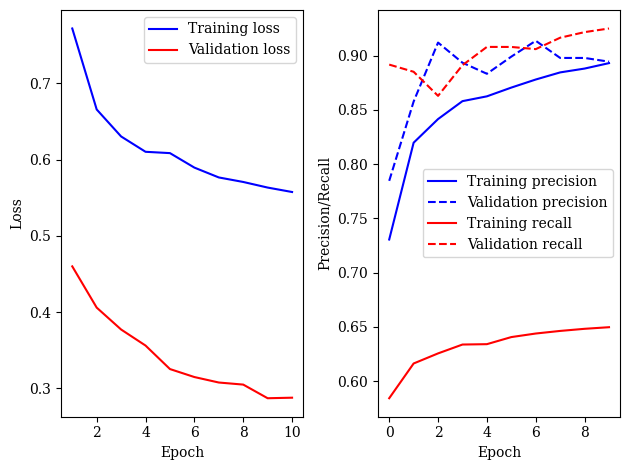

In [77]:
modal.plot_results(extended_model_results)

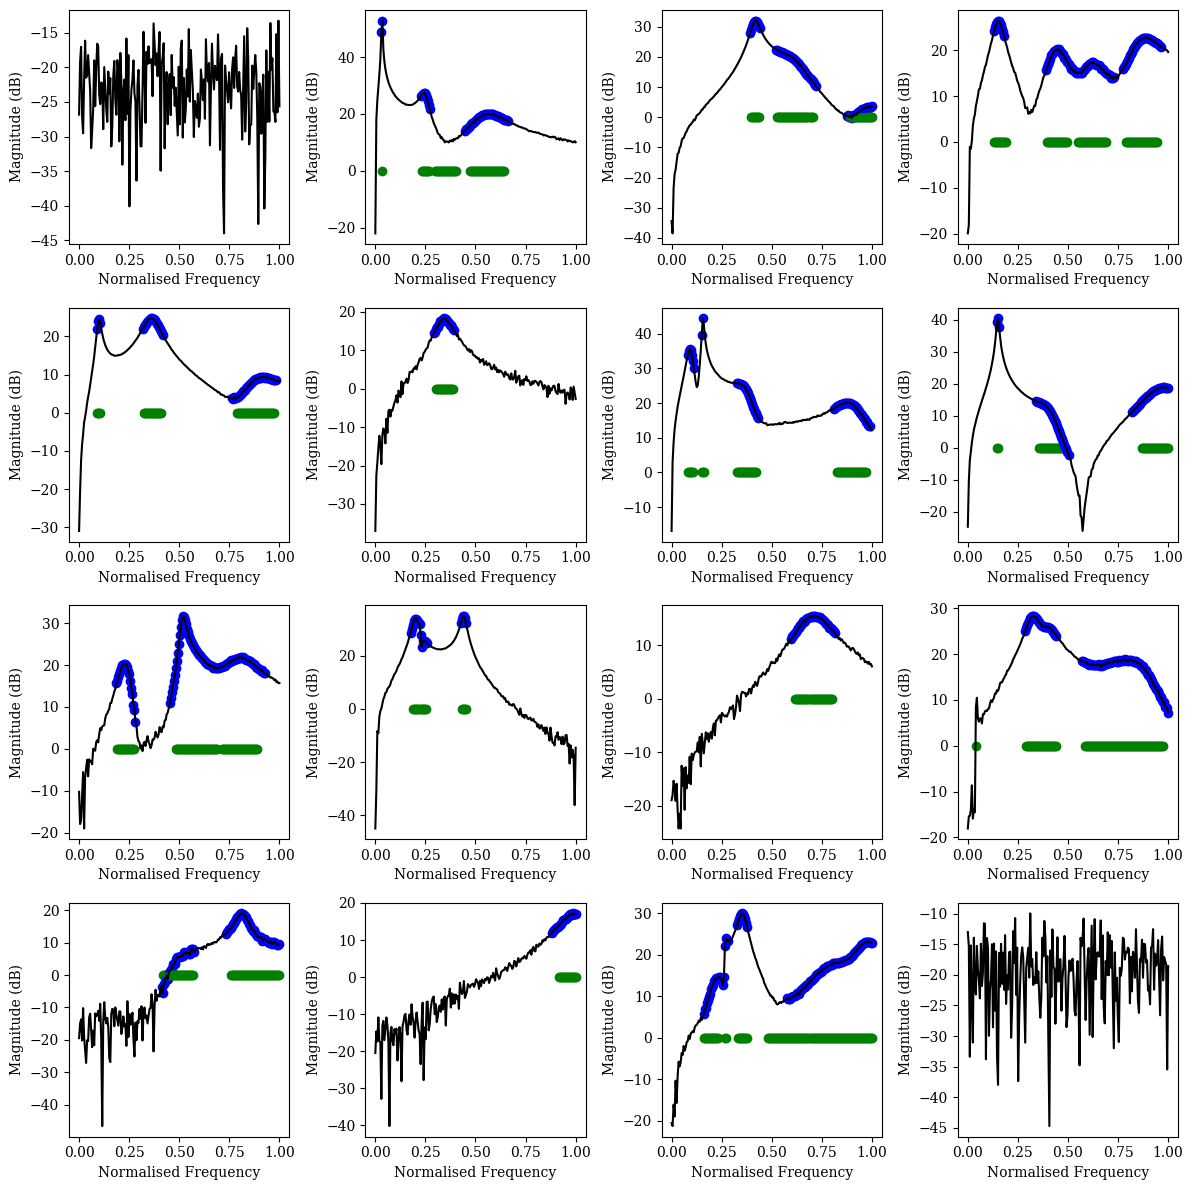

In [62]:
plot_predictions_extended(extended_model, num_w_points=200, normalise=None, neg_an=True, multiclass=False, nrows=4, ncols=4)

In [64]:
lab_tf = lab.load_data()

2024-01-15 14:44:56.457 python[48792:12733242] +[CATransaction synchronize] called within transaction


In [68]:
def extend_lab_tf(lab_tf):
    """Extend lab_tf with phase and magnitude information."""
    real_imag = split_real_imag(lab_tf)
    phase = np.arctan(np.imag(lab_tf)/np.real(lab_tf))
    mag = np.abs(lab_tf)
    extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1)), axis=1)
    return extended_op

In [75]:
def lab_predictions_extended(model, tf_arr, extended_tf, multiclass=False, normalise = None):
    lab_tf = split_real_imag(tf_arr).reshape(1, -1, 2)
    if normalise is not None:
        lab_tf = normalise(lab_tf)

    lab_tf_tensor = torch.from_numpy(extended_tf).to(torch.float32)

    model.eval()
    with torch.no_grad():
        lab_tf_output = model(lab_tf_tensor)
    
    if multiclass:
        test_op = np.array(lab_tf_output.numpy())
        predictions = np.argmax(test_op, axis=-1).reshape(-1)
    else:
        test_op = lab_tf_output.numpy().reshape(-1)
        predictions = (test_op > 0.0).astype(int)
    
    input_tf = split_real_imag(tf_arr)
    modal.plot_tf(input_tf, predictions) # todb = True

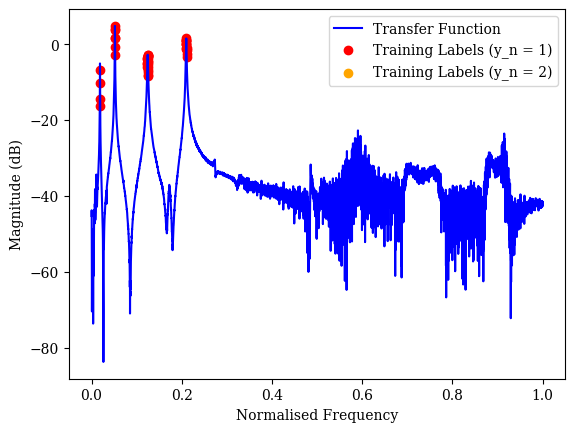

In [76]:
extended_lab_tf = extend_lab_tf(lab_tf)
lab_predictions_extended(extended_model, lab_tf, extended_lab_tf, multiclass=False, normalise=None)

##### Continuing training to try get further improvements

In [78]:
extended_model_results2 = modal.train_model_binary(extended_model, X, y, valX, valy, name='extended_model(15.01)_20epochs', num_epochs=10)

 10%|█         | 1/10 [02:27<22:11, 147.95s/it]

Epoch [1/10], Loss: 0.5558746980958514, Precision: 0.8920657403899007, Recall: 0.650438719321657
Validation Precision: 0.9136709284177859, Validation Recall: 0.9127364821531446


 20%|██        | 2/10 [04:58<19:56, 149.58s/it]

Epoch [2/10], Loss: 0.5494941019349628, Precision: 0.898161115435931, Recall: 0.6515942696459109
Validation Precision: 0.9235849916380618, Validation Recall: 0.9134645064808287


 30%|███       | 3/10 [07:30<17:34, 150.61s/it]

Epoch [3/10], Loss: 0.5480915333827336, Precision: 0.8967034248288539, Recall: 0.6534637815215462
Validation Precision: 0.9358994708326435, Validation Recall: 0.9048578138111969


 40%|████      | 4/10 [10:04<15:10, 151.80s/it]

Epoch [4/10], Loss: 0.5405868232912487, Precision: 0.9025144807065003, Recall: 0.6545896691986371
Validation Precision: 0.9095152605109911, Validation Recall: 0.9274142573066585


 50%|█████     | 5/10 [12:36<12:40, 152.09s/it]

Epoch [5/10], Loss: 0.5377868974871106, Precision: 0.9031878229554705, Recall: 0.6561963572749878
Validation Precision: 0.9247563674271789, Validation Recall: 0.9201004828303055


 60%|██████    | 6/10 [15:07<10:05, 151.47s/it]

Epoch [6/10], Loss: 0.5349070233106613, Precision: 0.9053815737545275, Recall: 0.656736760686391
Validation Precision: 0.9181454376623265, Validation Recall: 0.9297558021612042


 70%|███████   | 7/10 [17:35<07:31, 150.58s/it]

Epoch [7/10], Loss: 0.5308238432142469, Precision: 0.9070071016039313, Recall: 0.6582952928392927
Validation Precision: 0.9224662132135941, Validation Recall: 0.9244943215173947


 80%|████████  | 8/10 [20:03<04:59, 149.56s/it]

Epoch [8/10], Loss: 0.5278218430280686, Precision: 0.9094375238336705, Recall: 0.6596031350746758
Validation Precision: 0.9182796571036773, Validation Recall: 0.9288529638453231


 90%|█████████ | 9/10 [22:33<02:29, 149.90s/it]

Epoch [9/10], Loss: 0.5263509052991867, Precision: 0.9099984614182266, Recall: 0.6595196419760246
Validation Precision: 0.917281974481288, Validation Recall: 0.9323109973516437


100%|██████████| 10/10 [25:10<00:00, 151.08s/it]

Epoch [10/10], Loss: 0.5231632981697718, Precision: 0.911666081396142, Recall: 0.661006548306103
Validation Precision: 0.9274871274126842, Validation Recall: 0.9269958312143225


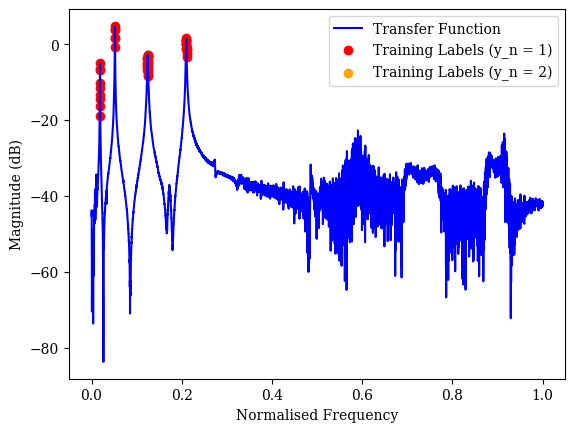

In [79]:
lab_predictions_extended(extended_model, lab_tf, extended_lab_tf, multiclass=False, normalise=None)

In [80]:
lab_tf_2 = lab.load_data()

2024-01-15 15:50:21.697 python[48792:12733242] +[CATransaction synchronize] called within transaction


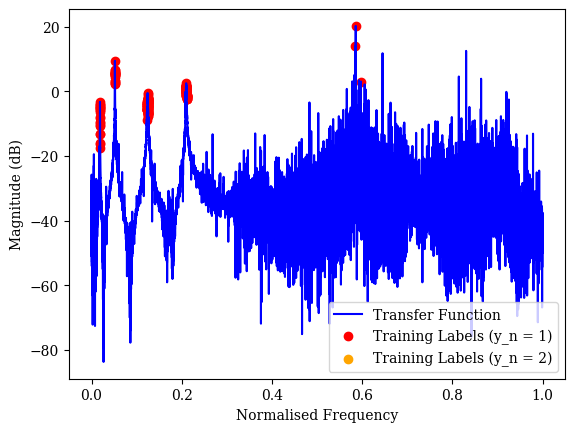

In [220]:
extended_lab_tf_2 = extend_lab_tf(lab_tf_2)
lab_predictions_extended(extended_model, lab_tf_2, extended_lab_tf_2, multiclass=False, normalise=None)

##### Now trying with normalisation

In [85]:
Xnorm, ynorm, _, __ = generate_dat_extended(num_data=32*450, num_w_points=200, neg_an=True, normalise=modal.normalise_rms)  # sigma_max = 0.15, max_modes = 7 (defaults)
valXnorm, valynorm, _, __ = generate_dat_extended(num_data=32*50, num_w_points=200, neg_an=True, normalise=modal.normalise_rms)

In [86]:
extended_model_norm = BiLSTM(input_size=4, hidden_size=100, num_layers=3, num_classes=1)
extended_model_norm_results = modal.train_model_binary(extended_model_norm, Xnorm, ynorm, valXnorm, valynorm, name='extended_model_norm(15.01)', num_epochs=20)

  5%|▌         | 1/20 [02:28<47:00, 148.46s/it]

Epoch [1/20], Loss: 0.8841469992531671, Precision: 0.6464426470438777, Recall: 0.5399226470795788
Validation Precision: 0.7890786944808434, Validation Recall: 0.8187011067243349


 10%|█         | 2/20 [05:00<45:13, 150.77s/it]

Epoch [2/20], Loss: 0.7176419043540955, Precision: 0.7620261503944191, Recall: 0.6054177839362422
Validation Precision: 0.8080441029087734, Validation Recall: 0.8768431805333408


 15%|█▌        | 3/20 [07:31<42:39, 150.54s/it]

Epoch [3/20], Loss: 0.6763117325305938, Precision: 0.7963804328406214, Recall: 0.616654659215473
Validation Precision: 0.8609653922594895, Validation Recall: 0.8618119860639986


 20%|██        | 4/20 [09:58<39:49, 149.32s/it]

Epoch [4/20], Loss: 0.6563702627685335, Precision: 0.8173734472836802, Recall: 0.6218492790180764
Validation Precision: 0.8643929375212029, Validation Recall: 0.8824449739610081


 25%|██▌       | 5/20 [12:25<37:06, 148.42s/it]

Epoch [5/20], Loss: 0.6408054797516929, Precision: 0.8294387740347317, Recall: 0.6269177384599819
Validation Precision: 0.8530942297248716, Validation Recall: 0.9047773432106818


 30%|███       | 6/20 [14:53<34:36, 148.32s/it]

Epoch [6/20], Loss: 0.6196815471516716, Precision: 0.8454659137381897, Recall: 0.6335478677932357
Validation Precision: 0.8744704304522796, Validation Recall: 0.9003484760966289


 35%|███▌      | 7/20 [17:19<31:59, 147.64s/it]

Epoch [7/20], Loss: 0.6093996271822187, Precision: 0.8521631623784116, Recall: 0.6359466574995961
Validation Precision: 0.8887432267819357, Validation Recall: 0.8952567754241297


 40%|████      | 8/20 [19:52<29:49, 149.16s/it]

Epoch [8/20], Loss: 0.5960867505603367, Precision: 0.8606545320684017, Recall: 0.6400499066863493
Validation Precision: 0.8795314687102812, Validation Recall: 0.9117659452221412


 45%|████▌     | 9/20 [22:22<27:23, 149.40s/it]

Epoch [9/20], Loss: 0.5905085526572333, Precision: 0.8660617547088368, Recall: 0.6415055161340482
Validation Precision: 0.9054873467706418, Validation Recall: 0.9037864284889894


 50%|█████     | 10/20 [24:50<24:52, 149.20s/it]

Epoch [10/20], Loss: 0.5819913848903444, Precision: 0.8718310004931972, Recall: 0.6434042403474193
Validation Precision: 0.895306798398848, Validation Recall: 0.9251356402250398


 55%|█████▌    | 11/20 [27:21<22:25, 149.53s/it]

Epoch [11/20], Loss: 0.5744901244507895, Precision: 0.8762056958280726, Recall: 0.6462643673222636
Validation Precision: 0.9067662826266882, Validation Recall: 0.9147464861272034


 60%|██████    | 12/20 [29:53<20:02, 150.32s/it]

Epoch [12/20], Loss: 0.5696926103035609, Precision: 0.8800846913302447, Recall: 0.6480117078323642
Validation Precision: 0.906629944651869, Validation Recall: 0.9203688583240505


 65%|██████▌   | 13/20 [32:21<17:28, 149.77s/it]

Epoch [13/20], Loss: 0.5670375175608529, Precision: 0.8823939975465256, Recall: 0.6482912365619605
Validation Precision: 0.9081552149238254, Validation Recall: 0.9205010748594623


 70%|███████   | 14/20 [34:50<14:57, 149.50s/it]

Epoch [14/20], Loss: 0.5603999410735236, Precision: 0.8883165878699808, Recall: 0.6510817814386146
Validation Precision: 0.9083121392370426, Validation Recall: 0.9290056170003761


 75%|███████▌  | 15/20 [37:18<12:24, 148.88s/it]

Epoch [15/20], Loss: 0.558926576309734, Precision: 0.8901831734587656, Recall: 0.6496938910356796
Validation Precision: 0.9291210138770238, Validation Recall: 0.9114049854651072


 80%|████████  | 16/20 [39:50<09:59, 149.80s/it]

Epoch [16/20], Loss: 0.552008203069369, Precision: 0.8945913156601748, Recall: 0.652271513943905
Validation Precision: 0.8902752601892006, Validation Recall: 0.9324686078673439


 85%|████████▌ | 17/20 [42:18<07:28, 149.38s/it]

Epoch [17/20], Loss: 0.5501310974359512, Precision: 0.8936124983963164, Recall: 0.6538194750162065
Validation Precision: 0.8670469530311193, Validation Recall: 0.9396315700280908


 90%|█████████ | 18/20 [44:49<05:00, 150.03s/it]

Epoch [18/20], Loss: 0.5480634617143207, Precision: 0.8950615066695699, Recall: 0.654205041642491
Validation Precision: 0.9122322300202333, Validation Recall: 0.9298698587093135


 95%|█████████▌| 19/20 [47:20<02:30, 150.05s/it]

Epoch [19/20], Loss: 0.5408912858035829, Precision: 0.9005496322541691, Recall: 0.6557410872089156
Validation Precision: 0.9250033629137423, Validation Recall: 0.9280154051928352


100%|██████████| 20/20 [49:51<00:00, 149.56s/it]

Epoch [20/20], Loss: 0.5368644710381826, Precision: 0.9028220174829101, Recall: 0.6571380089165229
Validation Precision: 0.9083742020183898, Validation Recall: 0.9406799728114508


In [92]:
extended_model_norm_results = modal.train_model_binary(extended_model_norm, Xnorm, ynorm, valXnorm, valynorm, name='extended_model_norm(15.01)_30epochs', num_epochs=10)

 10%|█         | 1/10 [02:27<22:06, 147.42s/it]

Epoch [1/10], Loss: 0.534724924630589, Precision: 0.9032363509713831, Recall: 0.6575265542040236
Validation Precision: 0.9250890210145343, Validation Recall: 0.935188525665041


 20%|██        | 2/10 [04:57<19:50, 148.80s/it]

Epoch [2/10], Loss: 0.5304092595312331, Precision: 0.907352824631307, Recall: 0.6587578255498289
Validation Precision: 0.9383982152331075, Validation Recall: 0.9274361042627843


 30%|███       | 3/10 [07:24<17:17, 148.17s/it]

Epoch [3/10], Loss: 0.5254320265849431, Precision: 0.9097029798407934, Recall: 0.6607113982326408
Validation Precision: 0.9104267817966921, Validation Recall: 0.9407360320099367


 40%|████      | 4/10 [09:56<14:58, 149.78s/it]

Epoch [4/10], Loss: 0.5254539199670156, Precision: 0.9095070841337886, Recall: 0.6604975481138569
Validation Precision: 0.9332552771927876, Validation Recall: 0.9286803938502082


 50%|█████     | 5/10 [12:27<12:30, 150.13s/it]

Epoch [5/10], Loss: 0.5239051224125756, Precision: 0.9113767092436402, Recall: 0.6606196829743675
Validation Precision: 0.9357990737336966, Validation Recall: 0.9311545212172209


 60%|██████    | 6/10 [14:55<09:58, 149.54s/it]

Epoch [6/10], Loss: 0.5211853117412991, Precision: 0.91217336918677, Recall: 0.6616063210428409
Validation Precision: 0.9239797941542989, Validation Recall: 0.9344586386187114


 70%|███████   | 7/10 [17:23<07:26, 148.86s/it]

Epoch [7/10], Loss: 0.5182295334339142, Precision: 0.9138000319138947, Recall: 0.6624257085226102
Validation Precision: 0.9364479593390489, Validation Recall: 0.9291645701381778


 80%|████████  | 8/10 [19:51<04:57, 148.69s/it]

Epoch [8/10], Loss: 0.5146674633026123, Precision: 0.915403825215348, Recall: 0.6637789282961972
Validation Precision: 0.9315934477695298, Validation Recall: 0.9353785808530856


 90%|█████████ | 9/10 [22:24<02:30, 150.02s/it]

Epoch [9/10], Loss: 0.5134423191679849, Precision: 0.9148551897720127, Recall: 0.6638040975604333
Validation Precision: 0.8914940116219883, Validation Recall: 0.9507913878711546


100%|██████████| 10/10 [24:56<00:00, 149.69s/it]

Epoch [10/10], Loss: 0.5107670111788644, Precision: 0.9156584582368293, Recall: 0.6645230415918041
Validation Precision: 0.9336745922671983, Validation Recall: 0.938203686703302


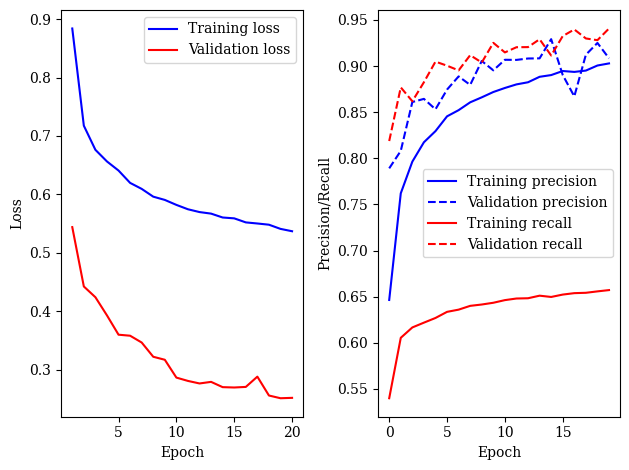

In [91]:
modal.plot_results(extended_model_norm_results) # first 20 epochs

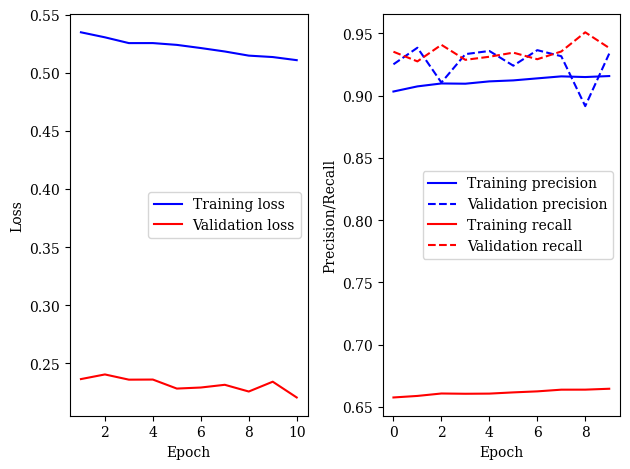

In [93]:
modal.plot_results(extended_model_norm_results) # additional 10 epochs

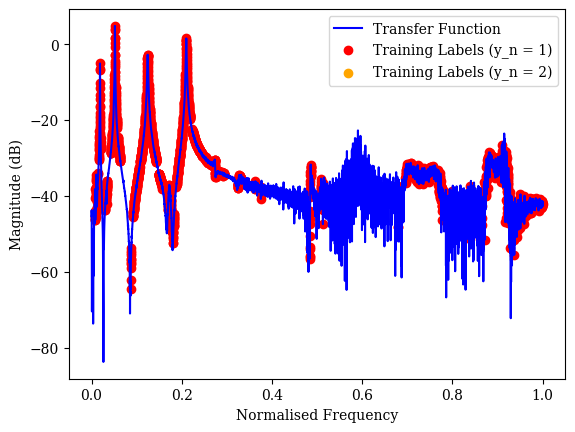

In [88]:
lab_predictions_extended(extended_model_norm, lab_tf, extended_lab_tf, multiclass=False, normalise=modal.normalise_rms) # first 20 epochs

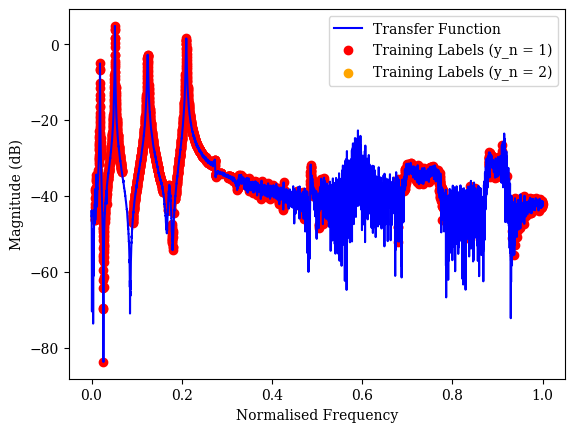

In [94]:
lab_predictions_extended(extended_model_norm, lab_tf, extended_lab_tf, multiclass=False, normalise=modal.normalise_rms) # additional 10 epochs

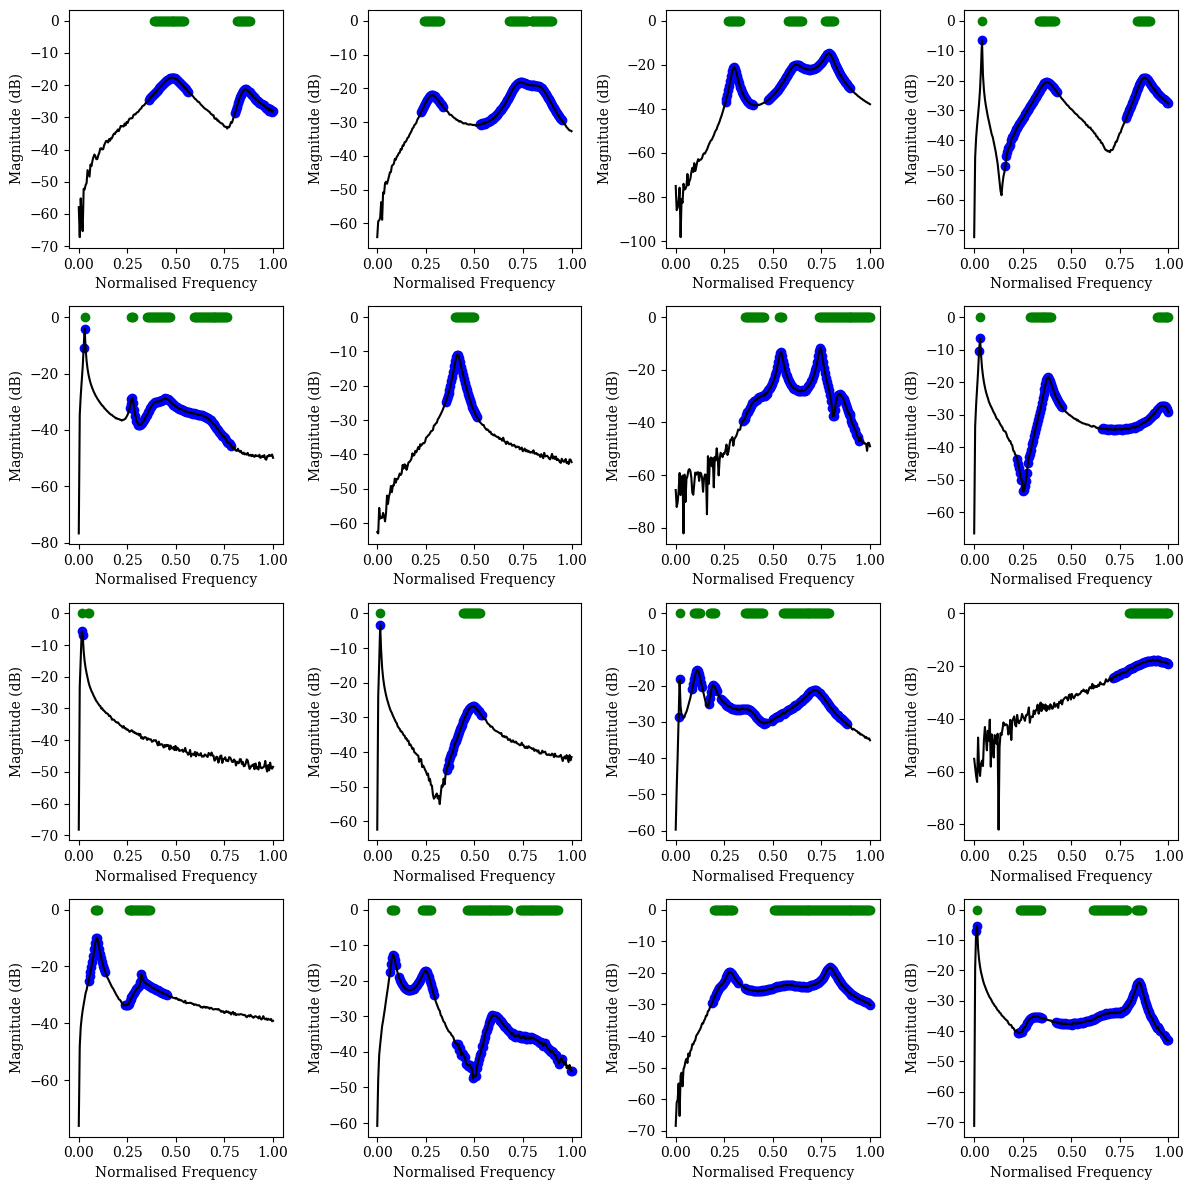

In [90]:
plot_predictions_extended(extended_model_norm, num_w_points=200, normalise=modal.normalise_rms, neg_an=True, multiclass=False, nrows=4, ncols=4) # first 20 epochs

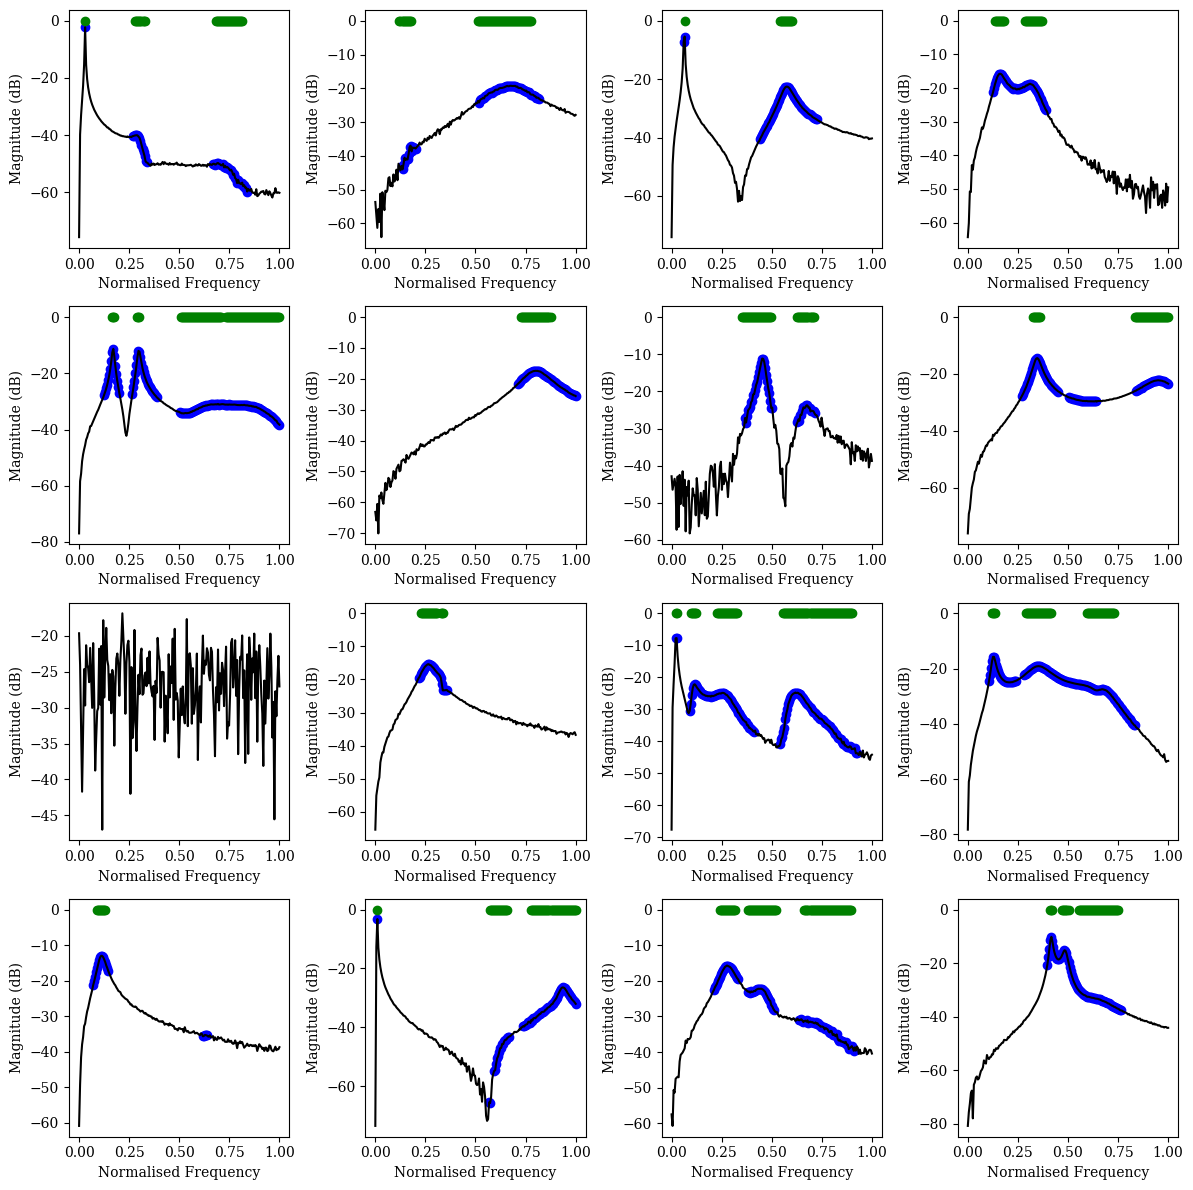

In [95]:
plot_predictions_extended(extended_model_norm, num_w_points=200, normalise=modal.normalise_rms, neg_an=True, multiclass=False, nrows=4, ncols=4) # additional 10 epochs

#### Running these for longer overnight to try see improvements

In [168]:
extended_model_results3 = modal.train_model_binary(extended_model, X, y, valX, valy, name='extended_model(15.01)_50epochs', num_epochs=30)

  3%|▎         | 1/30 [02:23<1:09:08, 143.04s/it]

Epoch [1/30], Loss: 0.5227923208475113, Precision: 0.912872338034088, Recall: 0.6607566178320704
Validation Precision: 0.9238901498444201, Validation Recall: 0.9298935272632672


  7%|▋         | 2/30 [04:46<1:06:51, 143.25s/it]

Epoch [2/30], Loss: 0.5192585342460209, Precision: 0.9138365472561797, Recall: 0.6612765379614959
Validation Precision: 0.9202197501200416, Validation Recall: 0.9332982095086488


 10%|█         | 3/30 [07:11<1:04:52, 144.16s/it]

Epoch [3/30], Loss: 0.5154928402105967, Precision: 0.913991399693245, Recall: 0.6624747279714696
Validation Precision: 0.9276867892372089, Validation Recall: 0.927360716825472


 13%|█▎        | 4/30 [09:38<1:02:52, 145.09s/it]

Epoch [4/30], Loss: 0.5176656074656381, Precision: 0.914019601823707, Recall: 0.661698501060626
Validation Precision: 0.9246560620334583, Validation Recall: 0.9274613066231662


 17%|█▋        | 5/30 [11:58<59:47, 143.52s/it]  

Epoch [5/30], Loss: 0.5135438017712699, Precision: 0.9174376448831557, Recall: 0.6621753405862825
Validation Precision: 0.9192134454329259, Validation Recall: 0.9380296595667498


 20%|██        | 6/30 [14:18<56:49, 142.05s/it]

Epoch [6/30], Loss: 0.510544426176283, Precision: 0.9157529726221797, Recall: 0.664680396896181
Validation Precision: 0.923991864774524, Validation Recall: 0.9269790201184321


 23%|██▎       | 7/30 [16:37<54:04, 141.05s/it]

Epoch [7/30], Loss: 0.5097374156448576, Precision: 0.9169899769606605, Recall: 0.6638122737763207
Validation Precision: 0.9253153151007985, Validation Recall: 0.9316391565223161


 27%|██▋       | 8/30 [18:57<51:40, 140.92s/it]

Epoch [8/30], Loss: 0.507075667447514, Precision: 0.9188071584741029, Recall: 0.6650846389069954
Validation Precision: 0.9184891447582894, Validation Recall: 0.9375610052580362


 30%|███       | 9/30 [21:18<49:21, 141.01s/it]

Epoch [9/30], Loss: 0.5050885550843345, Precision: 0.9197640417725919, Recall: 0.665990751409785
Validation Precision: 0.9216415624264578, Validation Recall: 0.9343786244779183


 33%|███▎      | 10/30 [23:39<46:54, 140.74s/it]

Epoch [10/30], Loss: 0.5039773314528995, Precision: 0.920550366010284, Recall: 0.6662781865915992
Validation Precision: 0.9224558541873816, Validation Recall: 0.9357793034365239


 37%|███▋      | 11/30 [26:03<44:53, 141.78s/it]

Epoch [11/30], Loss: 0.5018891368309657, Precision: 0.9195651638942254, Recall: 0.6668987576952801
Validation Precision: 0.938537210433904, Validation Recall: 0.9264400099012207


 40%|████      | 12/30 [28:27<42:43, 142.41s/it]

Epoch [12/30], Loss: 0.5017698800563812, Precision: 0.921583680990586, Recall: 0.6662759581486372
Validation Precision: 0.9175147525216508, Validation Recall: 0.9316526658362814


 43%|████▎     | 13/30 [30:51<40:31, 143.01s/it]

Epoch [13/30], Loss: 0.49860297388500635, Precision: 0.9223761499052886, Recall: 0.6681109379020128
Validation Precision: 0.9262958050561335, Validation Recall: 0.9281733435062606


 47%|████▋     | 14/30 [33:14<38:09, 143.09s/it]

Epoch [14/30], Loss: 0.4976075477732552, Precision: 0.9229869389154767, Recall: 0.6675968672179597
Validation Precision: 0.912520304096887, Validation Recall: 0.9362643746885798


 50%|█████     | 15/30 [35:34<35:32, 142.15s/it]

Epoch [15/30], Loss: 0.498746428820822, Precision: 0.9222392957442984, Recall: 0.6679773200050646
Validation Precision: 0.9212211872539774, Validation Recall: 0.9369325829552992


 53%|█████▎    | 16/30 [37:58<33:15, 142.54s/it]

Epoch [16/30], Loss: 0.4944482042392095, Precision: 0.9241991712356677, Recall: 0.6685361163046247
Validation Precision: 0.9162055991584019, Validation Recall: 0.9385385823769812


 57%|█████▋    | 17/30 [40:23<31:05, 143.52s/it]

Epoch [17/30], Loss: 0.4915361242161857, Precision: 0.925140941391132, Recall: 0.6699756764347218
Validation Precision: 0.9227519401105596, Validation Recall: 0.9385395868190818


 60%|██████    | 18/30 [42:48<28:45, 143.81s/it]

Epoch [18/30], Loss: 0.48935469773080614, Precision: 0.9263226475631751, Recall: 0.670709562510906
Validation Precision: 0.9202047057817494, Validation Recall: 0.9321140679975656


 63%|██████▎   | 19/30 [45:11<26:20, 143.64s/it]

Epoch [19/30], Loss: 0.4920400502284368, Precision: 0.9248819013813661, Recall: 0.6693136626397164
Validation Precision: 0.9318293978656572, Validation Recall: 0.9299920068155406


 67%|██████▋   | 20/30 [47:35<23:56, 143.62s/it]

Epoch [20/30], Loss: 0.48663877262009514, Precision: 0.9263787336601645, Recall: 0.671495212668198
Validation Precision: 0.9339389233700127, Validation Recall: 0.9353960348904016


 70%|███████   | 21/30 [49:59<21:32, 143.65s/it]

Epoch [21/30], Loss: 0.48351061701774595, Precision: 0.9273450056001225, Recall: 0.6736076518704369
Validation Precision: 0.9375252828780654, Validation Recall: 0.9306778252780495


 73%|███████▎  | 22/30 [52:26<19:18, 144.78s/it]

Epoch [22/30], Loss: 0.48554152409235635, Precision: 0.9264165309172868, Recall: 0.6721733981249455
Validation Precision: 0.9338038419573788, Validation Recall: 0.9327238119751199


 77%|███████▋  | 23/30 [54:53<16:59, 145.61s/it]

Epoch [23/30], Loss: 0.4846508542034361, Precision: 0.926291117324835, Recall: 0.6721961978291414
Validation Precision: 0.9365821993933426, Validation Recall: 0.930128198373211


 80%|████████  | 24/30 [57:22<14:39, 146.61s/it]

Epoch [24/30], Loss: 0.48344579027758705, Precision: 0.9283596635570087, Recall: 0.6724721434402121
Validation Precision: 0.9207907739288518, Validation Recall: 0.9401751742312789


 83%|████████▎ | 25/30 [59:51<12:16, 147.33s/it]

Epoch [25/30], Loss: 0.47947503381305273, Precision: 0.9279060985162623, Recall: 0.6745134933557452
Validation Precision: 0.9169865688407984, Validation Recall: 0.9357428573723972


 87%|████████▋ | 26/30 [1:02:17<09:46, 146.68s/it]

Epoch [26/30], Loss: 0.47899677336215973, Precision: 0.9284989316955279, Recall: 0.6741581566713285
Validation Precision: 0.9341525554163266, Validation Recall: 0.9342332436572495


 90%|█████████ | 27/30 [1:04:40<07:17, 145.73s/it]

Epoch [27/30], Loss: 0.47757029228740266, Precision: 0.9287575440775433, Recall: 0.6742257033645155
Validation Precision: 0.928393150533593, Validation Recall: 0.9305576212040659


 93%|█████████▎| 28/30 [1:07:05<04:50, 145.44s/it]

Epoch [28/30], Loss: 0.47697727580865223, Precision: 0.9289493321414951, Recall: 0.6751147062697513
Validation Precision: 0.9361121720706497, Validation Recall: 0.931415555710428


 97%|█████████▋| 29/30 [1:09:31<02:25, 145.75s/it]

Epoch [29/30], Loss: 0.48198623180389405, Precision: 0.9263634036600686, Recall: 0.6740303165815814
Validation Precision: 0.9266002129809463, Validation Recall: 0.9348607117933672


100%|██████████| 30/30 [1:11:55<00:00, 143.85s/it]

Epoch [30/30], Loss: 0.47397874236106874, Precision: 0.9298439294104294, Recall: 0.6756451015503492
Validation Precision: 0.9253683360107405, Validation Recall: 0.9361532761328517


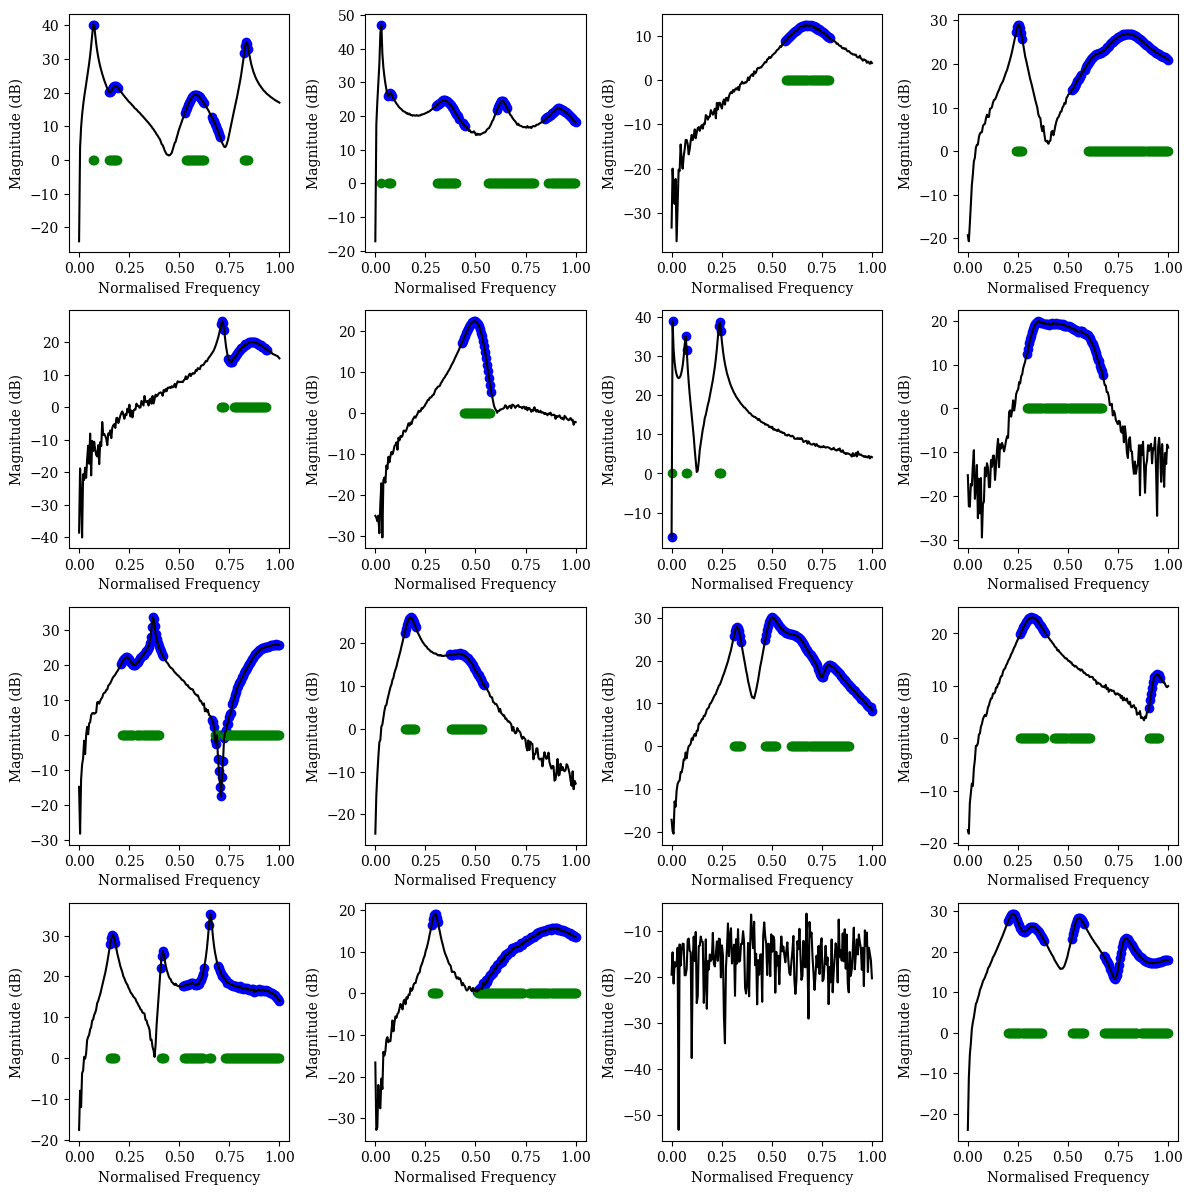

In [172]:
plot_predictions_extended(extended_model, num_w_points=200, normalise=None, neg_an=True, multiclass=False, nrows=4, ncols=4)

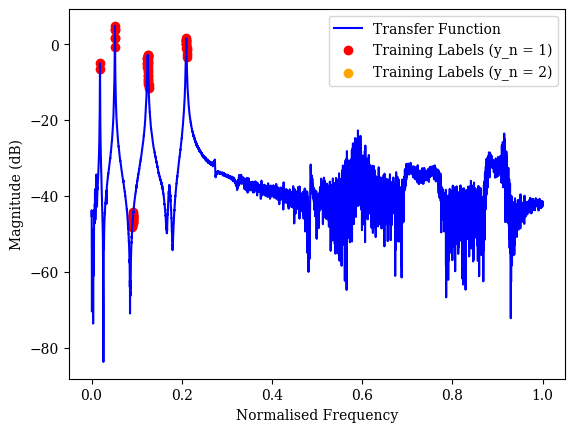

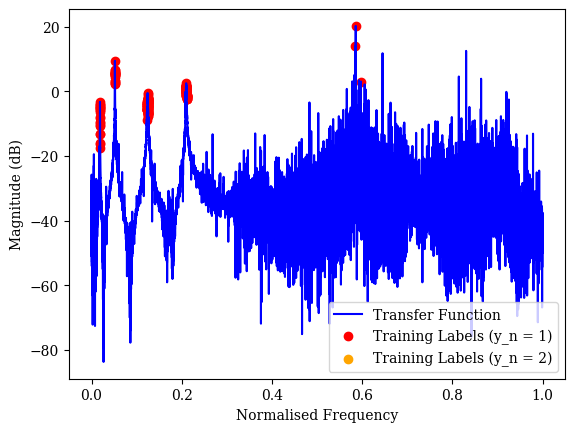

In [173]:
lab_predictions_extended(extended_model, lab_tf, extended_lab_tf, multiclass=False, normalise=None)
lab_predictions_extended(extended_model, lab_tf_2, extended_lab_tf_2, multiclass=False, normalise=None)

In [169]:
extended_model_norm_results3 = modal.train_model_binary(extended_model_norm, Xnorm, ynorm, valXnorm, valynorm, name='extended_model_norm(15.01)_50epochs', num_epochs=20)

  5%|▌         | 1/20 [02:21<44:48, 141.51s/it]

Epoch [1/20], Loss: 0.5091074075963762, Precision: 0.9163220410948122, Recall: 0.6653708593551781
Validation Precision: 0.9074859424582448, Validation Recall: 0.9449248944700073


 10%|█         | 2/20 [04:42<42:18, 141.05s/it]

Epoch [2/20], Loss: 0.5055529383818308, Precision: 0.9185951434333864, Recall: 0.665795282179682
Validation Precision: 0.9322160996946969, Validation Recall: 0.9389390786464549


 15%|█▌        | 3/20 [07:05<40:13, 141.95s/it]

Epoch [3/20], Loss: 0.5038859654135174, Precision: 0.9193121734035445, Recall: 0.66638962380368
Validation Precision: 0.9367152577222693, Validation Recall: 0.9384650704483041


 20%|██        | 4/20 [09:27<37:55, 142.20s/it]

Epoch [4/20], Loss: 0.5018509689966838, Precision: 0.9206332505792227, Recall: 0.6675527890229115
Validation Precision: 0.8994135257548543, Validation Recall: 0.9508243530854208


 25%|██▌       | 5/20 [11:47<35:17, 141.19s/it]

Epoch [5/20], Loss: 0.49854936050044163, Precision: 0.9219485619168465, Recall: 0.6689003711062665
Validation Precision: 0.9441324105631598, Validation Recall: 0.9331324458860574


 30%|███       | 6/20 [14:10<33:06, 141.87s/it]

Epoch [6/20], Loss: 0.497901885509491, Precision: 0.9216889130627934, Recall: 0.6682305065605213
Validation Precision: 0.9267580321246425, Validation Recall: 0.9351329379517348


 35%|███▌      | 7/20 [16:33<30:48, 142.20s/it]

Epoch [7/20], Loss: 0.4980449087752236, Precision: 0.9203930033079175, Recall: 0.6683372612712027
Validation Precision: 0.9374249186460013, Validation Recall: 0.9372455102980556


 40%|████      | 8/20 [18:56<28:30, 142.55s/it]

Epoch [8/20], Loss: 0.49338660074604884, Precision: 0.9239770623490543, Recall: 0.6698913690474628
Validation Precision: 0.9297580320368729, Validation Recall: 0.9378386274234839


 45%|████▌     | 9/20 [21:19<26:08, 142.61s/it]

Epoch [9/20], Loss: 0.49444944500923155, Precision: 0.9222508606308514, Recall: 0.6697305911598757
Validation Precision: 0.9298861288132442, Validation Recall: 0.9426932870985795


 50%|█████     | 10/20 [23:44<23:52, 143.28s/it]

Epoch [10/20], Loss: 0.49130620817343396, Precision: 0.9243349729965886, Recall: 0.6703487028003081
Validation Precision: 0.9319308708958698, Validation Recall: 0.9401389296986907


 55%|█████▌    | 11/20 [26:07<21:29, 143.28s/it]

Epoch [11/20], Loss: 0.48893082777659097, Precision: 0.9250020408921725, Recall: 0.6714680251594438
Validation Precision: 0.9306213258719821, Validation Recall: 0.9419374618179142


 60%|██████    | 12/20 [28:33<19:12, 144.12s/it]

Epoch [12/20], Loss: 0.4855319814549552, Precision: 0.9275357939651329, Recall: 0.672491845371901
Validation Precision: 0.9360541160493114, Validation Recall: 0.9385424894285578


 65%|██████▌   | 13/20 [30:58<16:51, 144.45s/it]

Epoch [13/20], Loss: 0.4848988211817212, Precision: 0.9271062586488834, Recall: 0.6724845351492797
Validation Precision: 0.913022994001176, Validation Recall: 0.9464421531182182


 70%|███████   | 14/20 [33:23<14:27, 144.59s/it]

Epoch [14/20], Loss: 0.4835810906357235, Precision: 0.9269452379361076, Recall: 0.6725541106695674
Validation Precision: 0.9365738016616687, Validation Recall: 0.9323224371041394


 75%|███████▌  | 15/20 [35:47<12:01, 144.24s/it]

Epoch [15/20], Loss: 0.4830437078740862, Precision: 0.9281870459544286, Recall: 0.6725478263982188
Validation Precision: 0.922148163922059, Validation Recall: 0.9415698785884148


 80%|████████  | 16/20 [38:10<09:35, 144.00s/it]

Epoch [16/20], Loss: 0.4783789689011044, Precision: 0.9294446758110309, Recall: 0.6749734522703169
Validation Precision: 0.9369242527726088, Validation Recall: 0.9391933735269888


 85%|████████▌ | 17/20 [40:33<07:10, 143.60s/it]

Epoch [17/20], Loss: 0.4784960077206294, Precision: 0.9293327112732935, Recall: 0.6751869866380928
Validation Precision: 0.9363138838185994, Validation Recall: 0.9370743249260011


 90%|█████████ | 18/20 [42:57<04:47, 143.71s/it]

Epoch [18/20], Loss: 0.47799330724610223, Precision: 0.9295521409682217, Recall: 0.6746259608990272
Validation Precision: 0.9246984881893197, Validation Recall: 0.9459800708463477


 95%|█████████▌| 19/20 [45:25<02:24, 144.99s/it]

Epoch [19/20], Loss: 0.47598538484838276, Precision: 0.9300269627082518, Recall: 0.675003249845504
Validation Precision: 0.9363271505187584, Validation Recall: 0.9392113786384408


100%|██████████| 20/20 [47:53<00:00, 143.68s/it]

Epoch [20/20], Loss: 0.4736217623949051, Precision: 0.9323576210497765, Recall: 0.6753349179268129
Validation Precision: 0.931142673327293, Validation Recall: 0.9415705589696967


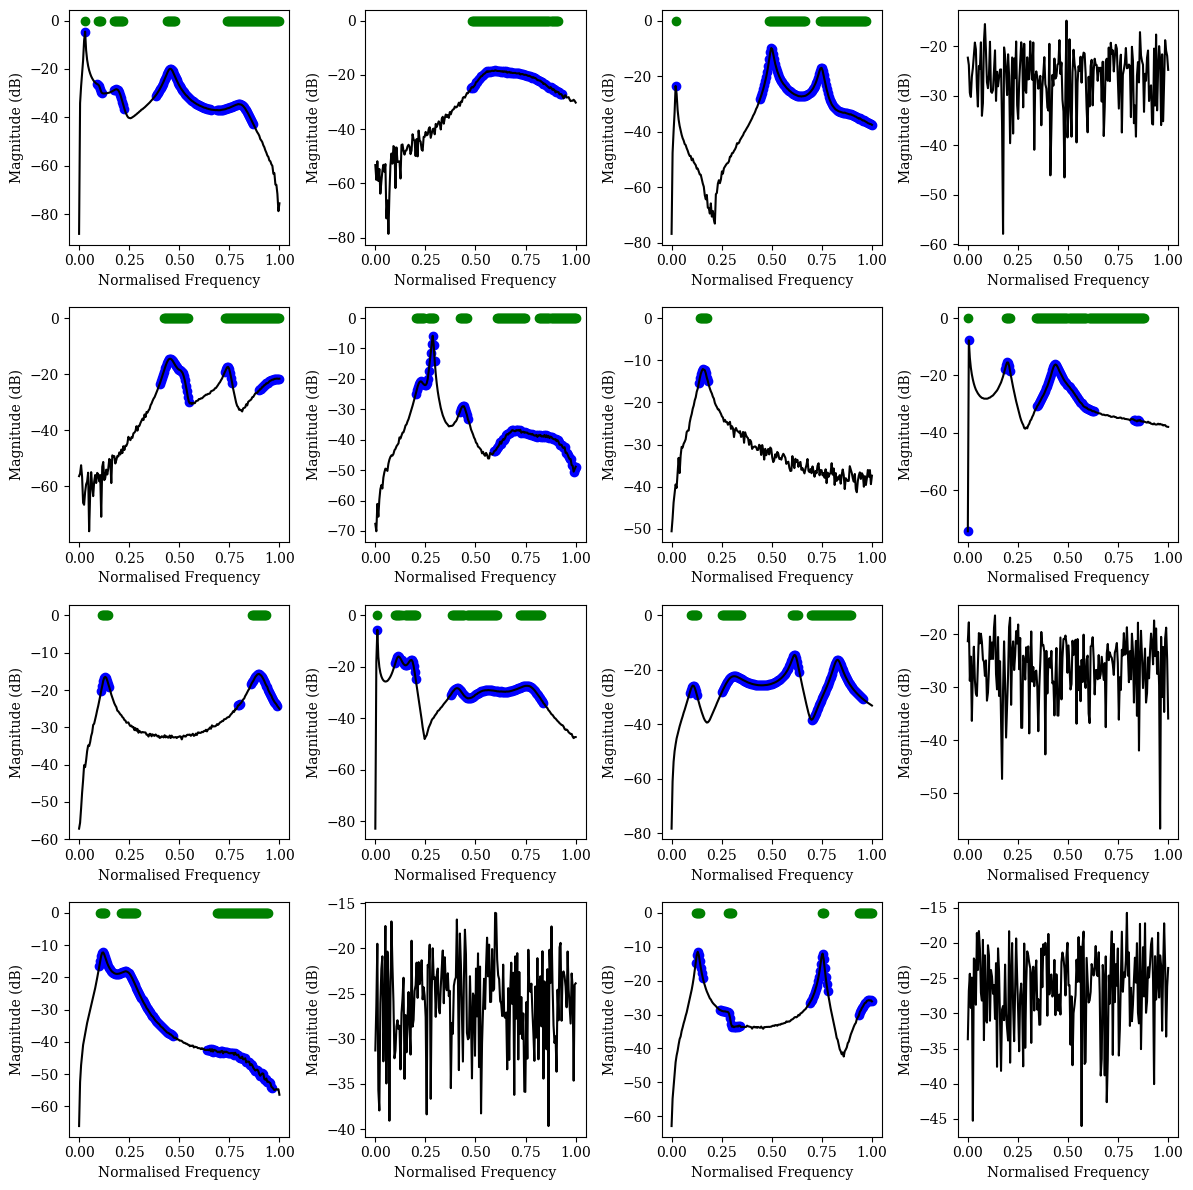

In [176]:
plot_predictions_extended(extended_model_norm, num_w_points=200, normalise=modal.normalise_rms, neg_an=True, multiclass=False, nrows=4, ncols=4)

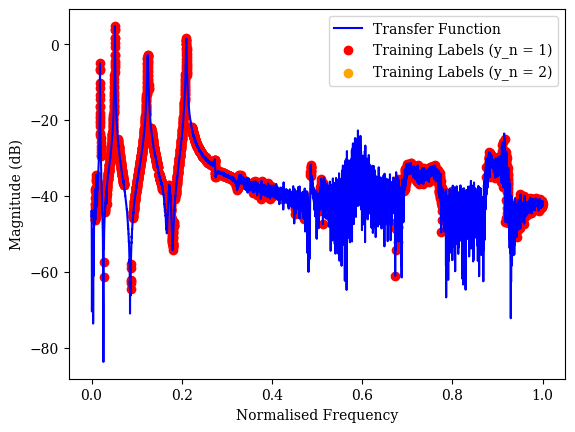

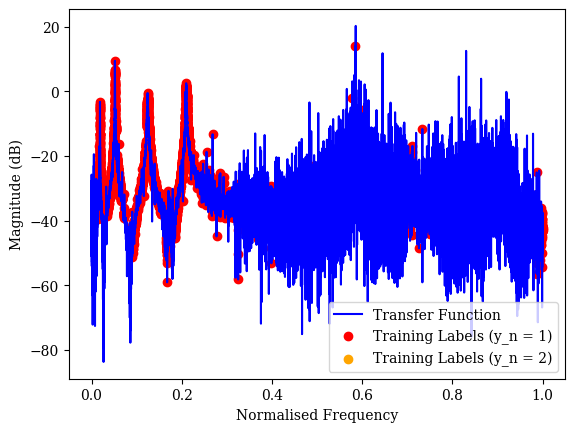

In [182]:
lab_predictions_extended(extended_model_norm, lab_tf, extended_lab_tf, multiclass=False, normalise=modal.normalise_rms)
lab_predictions_extended(extended_model_norm, lab_tf_2, extended_lab_tf_2, multiclass=False, normalise=modal.normalise_rms)

### Seeing if this impacts the multiclass model

In [98]:
def calculate_precision_and_recall(outputs, targets):
    # Convert the outputs to class predictions (index of max value along the last dimension)
    _, predicted = torch.max(outputs, dim=-1)
    
    # Flatten the predictions and targets to 1D tensors
    predicted_flat = predicted.view(-1)
    targets_flat = targets.view(-1)
    
    true_positives = (predicted_flat == targets_flat).sum().item()
    false_positives = ((predicted_flat == 1) & (targets_flat == 0)).sum().item()
    false_negatives = ((predicted_flat == 0) & (targets_flat == 1)).sum().item()
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return precision, recall

In [166]:
def train_model_multiclass(model, X, y, valX, valy, name, num_epochs=150):
    X = torch.from_numpy(X).to(torch.float32)
    y = torch.from_numpy(y).to(torch.long)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.long)

    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

    val_dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True, num_workers=4)

    # Define a binary cross-entropy loss function and an optimizer
    # pos_weight > 1 aims to increase recall
    # criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([4.0]))  # Binary cross-entropy loss with logits
    # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 20.0]))  
    # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 15.0])) 
    criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 8.0])) 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    result_dict = {
        'training_loss': [],
        'validation_loss': [],
        'training_precision': [],
        'training_recall': [],
        'validation_precision': [],
        'validation_recall': [],
        'epochs': []
    }

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        total_precision = 0.0
        total_recall = 0.0
        total_samples = 0

        total_val_loss = 0.0
        total_val_precision = 0.0
        total_val_recall = 0.0
        total_val_samples = 0

        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.view(-1)
            loss = criterion(outputs.view(-1, 3), targets)
            
            # output = outputs.permute(0, 2, 1)
            # loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
            total_loss += loss.item() * len(inputs)
            total_precision += batch_precision * len(inputs)
            total_recall += batch_recall * len(inputs)
            total_samples += len(inputs)

        model.eval() # !!!
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                # outputs = outputs.view(-1, 1)
                # targets = targets.view(-1, 1)
                targets = targets.view(-1)
                loss = criterion(outputs.view(-1, 3), targets)
                total_val_loss += loss.item() * len(inputs)
                batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
                total_val_precision += batch_precision * len(inputs)
                total_val_recall += batch_recall * len(inputs)
                total_val_samples += len(inputs)

        average_loss = total_loss / total_samples
        average_precision = total_precision / total_samples
        average_recall = total_recall / total_samples
        # average_accuracy = total_accuracy / total_samples
        average_val_loss = total_val_loss / total_val_samples
        average_val_precision = total_val_precision / total_val_samples
        average_val_recall = total_val_recall / total_val_samples

        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Accuracy: {average_accuracy}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Precision: {average_precision}, Recall: {average_recall}')
        print(f'Validation Precision: {average_val_precision}, Validation Recall: {average_val_recall}')

        result_dict['training_loss'].append(average_loss)
        # result_dict['validation_loss'].append(average_val_loss)
        result_dict['training_precision'].append(average_precision)
        result_dict['training_recall'].append(average_recall)
        result_dict['validation_precision'].append(average_val_precision)
        result_dict['validation_recall'].append(average_val_recall)
        result_dict['epochs'].append(epoch+1)


    torch.save(model, f'{name}.pth')
    return result_dict

In [102]:
Xmult, ymult, ws, __ = generate_dat_extended(num_data=32*450, num_w_points=200, neg_an=True, multiclass=True)  # sigma_max = 0.15, max_modes = 7 (defaults)
valXmult, valymult, _, __ = generate_dat_extended(num_data=32*50, num_w_points=200, neg_an=True, multiclass=True)

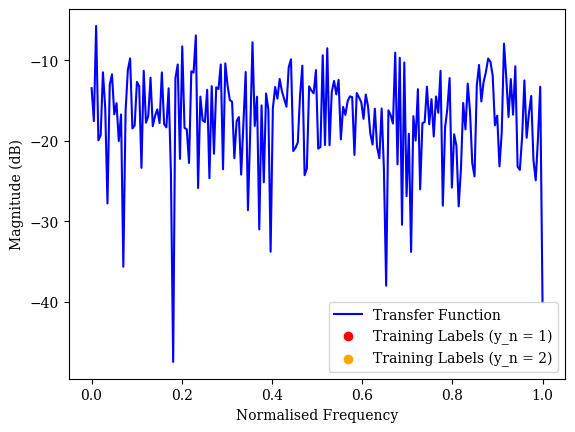

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [162]:
# Visualise the generated training data
idx = np.random.randint(0, Xmult.shape[0])
modal.plot_tf(Xmult[idx,:,:2], ymult[idx], todb=True)

In [167]:
multiclass_model = BiLSTM(input_size=4, hidden_size=100, num_layers=3, num_classes=3)
multiclass_res = train_model_multiclass(multiclass_model, Xmult, ymult, valXmult, valymult, name='extended_model_multiclass(15.01)', num_epochs=50)

  2%|▏         | 1/50 [02:25<1:59:09, 145.91s/it]

Epoch [1/50], Loss: 0.7802396059036255, Precision: 0.869827725114669, Recall: 0.9509258442607498
Validation Precision: 0.9064451853224376, Validation Recall: 0.9719230496622903


  4%|▍         | 2/50 [04:53<1:57:44, 147.17s/it]

Epoch [2/50], Loss: 0.689131250778834, Precision: 0.9166608159137877, Recall: 0.9583449620527664
Validation Precision: 0.9245539097688862, Validation Recall: 0.9759084875974586


  6%|▌         | 3/50 [07:32<1:59:21, 152.37s/it]

Epoch [3/50], Loss: 0.6522949996921751, Precision: 0.9295331609923771, Recall: 0.9610145170450086
Validation Precision: 0.9063832222172704, Validation Recall: 0.9813317032842269


  8%|▊         | 4/50 [10:12<1:59:09, 155.43s/it]

Epoch [4/50], Loss: 0.6328740440474616, Precision: 0.9345060406977387, Recall: 0.9622437355980688
Validation Precision: 0.9473203005488324, Validation Recall: 0.9766442088154667


 10%|█         | 5/50 [12:42<1:55:09, 153.55s/it]

Epoch [5/50], Loss: 0.6053979153103298, Precision: 0.9435657575114884, Recall: 0.9640702299838113
Validation Precision: 0.9538373479311225, Validation Recall: 0.9786667735870062


 12%|█▏        | 6/50 [15:11<1:51:20, 151.84s/it]

Epoch [6/50], Loss: 0.5935594807730781, Precision: 0.9436353001545414, Recall: 0.964785865374204
Validation Precision: 0.95882748993707, Validation Recall: 0.9789250624662145


 14%|█▍        | 7/50 [17:45<1:49:18, 152.51s/it]

Epoch [7/50], Loss: 0.5832131770584318, Precision: 0.9471962793275596, Recall: 0.9654804920861852
Validation Precision: 0.9602536674551009, Validation Recall: 0.9797796991040003


 16%|█▌        | 8/50 [20:17<1:46:46, 152.53s/it]

Epoch [8/50], Loss: 0.5702912088235219, Precision: 0.9507544052720299, Recall: 0.9663897548337274
Validation Precision: 0.9569970953818913, Validation Recall: 0.9810848967196477


 18%|█▊        | 9/50 [22:49<1:43:56, 152.11s/it]

Epoch [9/50], Loss: 0.561587067047755, Precision: 0.9519331352100676, Recall: 0.9666336275630197
Validation Precision: 0.9607085695107961, Validation Recall: 0.981145818507879


 20%|██        | 10/50 [25:21<1:41:22, 152.07s/it]

Epoch [10/50], Loss: 0.5522633100880517, Precision: 0.9542405030708898, Recall: 0.9673069294486584
Validation Precision: 0.9617014922881091, Validation Recall: 0.9832263477046105


 22%|██▏       | 11/50 [27:54<1:39:02, 152.37s/it]

Epoch [11/50], Loss: 0.5448051942719354, Precision: 0.956034526072361, Recall: 0.9675900600670212
Validation Precision: 0.9635568453580166, Validation Recall: 0.9827951685963927


 24%|██▍       | 12/50 [30:24<1:36:12, 151.91s/it]

Epoch [12/50], Loss: 0.539144684738583, Precision: 0.9577597101314232, Recall: 0.967700225805243
Validation Precision: 0.9734854531723589, Validation Recall: 0.9791779225616237


 26%|██▌       | 13/50 [32:54<1:33:12, 151.16s/it]

Epoch [13/50], Loss: 0.530546233786477, Precision: 0.9587951519936976, Recall: 0.9681979247355647
Validation Precision: 0.9545224678152183, Validation Recall: 0.986012727745065


 28%|██▊       | 14/50 [35:25<1:30:42, 151.18s/it]

Epoch [14/50], Loss: 0.5253424253728655, Precision: 0.9599684719936162, Recall: 0.9685632681271766
Validation Precision: 0.9649196025972185, Validation Recall: 0.9837586167069468


 30%|███       | 15/50 [37:54<1:27:47, 150.51s/it]

Epoch [15/50], Loss: 0.52069530652629, Precision: 0.9597549695978641, Recall: 0.9685673920775071
Validation Precision: 0.9625298453801269, Validation Recall: 0.985795472032824


 32%|███▏      | 16/50 [40:22<1:24:53, 149.81s/it]

Epoch [16/50], Loss: 0.5146303426557117, Precision: 0.9614114876548939, Recall: 0.9689484683028242
Validation Precision: 0.9628670689105205, Validation Recall: 0.9856702726333728


 34%|███▍      | 17/50 [42:53<1:22:30, 150.03s/it]

Epoch [17/50], Loss: 0.5081691633330451, Precision: 0.9625089883498169, Recall: 0.9693775438900093
Validation Precision: 0.9562235633053026, Validation Recall: 0.9867836223405141


 36%|███▌      | 18/50 [45:22<1:19:53, 149.79s/it]

Epoch [18/50], Loss: 0.505146702726682, Precision: 0.962428293278209, Recall: 0.9692413509154015
Validation Precision: 0.9637431676537244, Validation Recall: 0.9860318583175192


 38%|███▊      | 19/50 [47:48<1:16:45, 148.55s/it]

Epoch [19/50], Loss: 0.5000652832455105, Precision: 0.9636498872270645, Recall: 0.9695783703112334
Validation Precision: 0.9637047764259207, Validation Recall: 0.9865884194509708


 40%|████      | 20/50 [50:22<1:15:05, 150.17s/it]

Epoch [20/50], Loss: 0.49301579786671534, Precision: 0.9652089064866489, Recall: 0.9698485047117901
Validation Precision: 0.9694085312899214, Validation Recall: 0.984866219326764


 42%|████▏     | 21/50 [52:58<1:13:28, 152.02s/it]

Epoch [21/50], Loss: 0.4886206254694197, Precision: 0.9649259788368363, Recall: 0.9700047921433851
Validation Precision: 0.9731628723547067, Validation Recall: 0.9842970265282018


 44%|████▍     | 22/50 [55:23<1:09:58, 149.93s/it]

Epoch [22/50], Loss: 0.48690742009215887, Precision: 0.9650002577113074, Recall: 0.9699294809702914
Validation Precision: 0.9638737615164836, Validation Recall: 0.9860721174660463


 46%|████▌     | 23/50 [57:49<1:06:59, 148.87s/it]

Epoch [23/50], Loss: 0.4818798645999697, Precision: 0.9655342828077254, Recall: 0.9701433572423419
Validation Precision: 0.957038793153469, Validation Recall: 0.9877081840525156


 48%|████▊     | 24/50 [1:00:14<1:03:54, 147.49s/it]

Epoch [24/50], Loss: 0.4802889890140957, Precision: 0.9658987847300452, Recall: 0.9702449915865852
Validation Precision: 0.9677438806185039, Validation Recall: 0.9865052297881758


 50%|█████     | 25/50 [1:02:36<1:00:48, 145.93s/it]

Epoch [25/50], Loss: 0.47305700964397857, Precision: 0.9662192382812281, Recall: 0.970732487703537
Validation Precision: 0.9704225859946081, Validation Recall: 0.985217018549465


 52%|█████▏    | 26/50 [1:04:59<58:04, 145.18s/it]  

Epoch [26/50], Loss: 0.4690147485997942, Precision: 0.9663129965770219, Recall: 0.9708210417306811
Validation Precision: 0.9657671764148691, Validation Recall: 0.9864498415045572


 54%|█████▍    | 27/50 [1:07:27<55:54, 145.86s/it]

Epoch [27/50], Loss: 0.4663205275932948, Precision: 0.9662931876354043, Recall: 0.9707900575988588
Validation Precision: 0.9690125022897932, Validation Recall: 0.9859149723696191


 56%|█████▌    | 28/50 [1:09:57<53:55, 147.06s/it]

Epoch [28/50], Loss: 0.4645679533481598, Precision: 0.9671687870078142, Recall: 0.9707125996049346
Validation Precision: 0.9698793319788171, Validation Recall: 0.9860557223546307


 58%|█████▊    | 29/50 [1:12:26<51:45, 147.87s/it]

Epoch [29/50], Loss: 0.4581550388203727, Precision: 0.967159447048149, Recall: 0.9709323886816968
Validation Precision: 0.9698935774170145, Validation Recall: 0.9869488278768919


 60%|██████    | 30/50 [1:14:56<49:25, 148.29s/it]

Epoch [30/50], Loss: 0.45507408142089845, Precision: 0.9671281501738448, Recall: 0.9712034464977805
Validation Precision: 0.9668128301208792, Validation Recall: 0.9864810655599899


 62%|██████▏   | 31/50 [1:17:26<47:10, 148.98s/it]

Epoch [31/50], Loss: 0.4492468800809648, Precision: 0.9682282328645879, Recall: 0.971206676713958
Validation Precision: 0.9679322540843032, Validation Recall: 0.9866880006188654


 64%|██████▍   | 32/50 [1:19:54<44:33, 148.53s/it]

Epoch [32/50], Loss: 0.44787445631292133, Precision: 0.9679066368317242, Recall: 0.9711694514060802
Validation Precision: 0.9737284605260883, Validation Recall: 0.9857429109851813


 66%|██████▌   | 33/50 [1:22:20<41:51, 147.74s/it]

Epoch [33/50], Loss: 0.4425603228807449, Precision: 0.9675887552756086, Recall: 0.971345325944171
Validation Precision: 0.9720462431161024, Validation Recall: 0.985132394166407


 68%|██████▊   | 34/50 [1:24:46<39:18, 147.39s/it]

Epoch [34/50], Loss: 0.4397101017501619, Precision: 0.968134125458626, Recall: 0.9714983571488434
Validation Precision: 0.9675491645112559, Validation Recall: 0.9870905418487197


 70%|███████   | 35/50 [1:27:11<36:40, 146.69s/it]

Epoch [35/50], Loss: 0.4312759957710902, Precision: 0.968529413717117, Recall: 0.9718822258080532
Validation Precision: 0.9705510682031689, Validation Recall: 0.9862517023545964


 72%|███████▏  | 36/50 [1:29:41<34:24, 147.46s/it]

Epoch [36/50], Loss: 0.4325303084982766, Precision: 0.9677587266183633, Recall: 0.9716915584263814
Validation Precision: 0.970876257659925, Validation Recall: 0.9857678660851943


 74%|███████▍  | 37/50 [1:32:10<32:04, 148.04s/it]

Epoch [37/50], Loss: 0.4290986542569266, Precision: 0.9684146845065598, Recall: 0.9717208998418647
Validation Precision: 0.966263426518597, Validation Recall: 0.9870822303205241


 76%|███████▌  | 38/50 [1:34:42<29:50, 149.18s/it]

Epoch [38/50], Loss: 0.42561014784706963, Precision: 0.9683805592519105, Recall: 0.9721188346906938
Validation Precision: 0.9715077015531811, Validation Recall: 0.9856748917087227


 78%|███████▊  | 39/50 [1:37:13<27:28, 149.90s/it]

Epoch [39/50], Loss: 0.430374084909757, Precision: 0.9676946458902176, Recall: 0.971754477440087
Validation Precision: 0.9702386166453055, Validation Recall: 0.9855740955508615


 80%|████████  | 40/50 [1:39:39<24:47, 148.71s/it]

Epoch [40/50], Loss: 0.4191660647922092, Precision: 0.9681440417981428, Recall: 0.972118139452842
Validation Precision: 0.9711971264243257, Validation Recall: 0.9861590399431975


 82%|████████▏ | 41/50 [1:42:08<22:17, 148.61s/it]

Epoch [41/50], Loss: 0.4093498106797536, Precision: 0.9689325632318283, Recall: 0.972376265836648
Validation Precision: 0.969277127363369, Validation Recall: 0.9870050427953225


 84%|████████▍ | 42/50 [1:44:39<19:56, 149.53s/it]

Epoch [42/50], Loss: 0.40754199895593857, Precision: 0.9698340342096096, Recall: 0.9725068242286955
Validation Precision: 0.9721559862371143, Validation Recall: 0.9858068859073187


 86%|████████▌ | 43/50 [1:47:08<17:25, 149.40s/it]

Epoch [43/50], Loss: 0.40758978022469416, Precision: 0.9678960173462419, Recall: 0.9721395978546349
Validation Precision: 0.9629986989752568, Validation Recall: 0.9870550532622241


 88%|████████▊ | 44/50 [1:49:39<14:57, 149.64s/it]

Epoch [44/50], Loss: 0.4028523624605603, Precision: 0.9690350184797676, Recall: 0.97245038091702
Validation Precision: 0.9713432100166552, Validation Recall: 0.9854917675137398


 90%|█████████ | 45/50 [1:52:08<12:27, 149.59s/it]

Epoch [45/50], Loss: 0.40341491560141246, Precision: 0.9693307698944497, Recall: 0.9724410268190884
Validation Precision: 0.9679454443376732, Validation Recall: 0.9864159471643725


 92%|█████████▏| 46/50 [1:54:39<09:59, 149.85s/it]

Epoch [46/50], Loss: 0.39747498942746057, Precision: 0.9688269711540411, Recall: 0.972406247707645
Validation Precision: 0.968445168057006, Validation Recall: 0.9869899874048355


 94%|█████████▍| 47/50 [1:57:09<07:30, 150.11s/it]

Epoch [47/50], Loss: 0.39189431263340846, Precision: 0.9692156739883439, Recall: 0.9725498266571125
Validation Precision: 0.9653276823922523, Validation Recall: 0.9868635757254964


 96%|█████████▌| 48/50 [1:59:43<05:02, 151.02s/it]

Epoch [48/50], Loss: 0.39856927712758383, Precision: 0.9687767819304327, Recall: 0.9722404672066672
Validation Precision: 0.9698178709976962, Validation Recall: 0.98582694885099


 98%|█████████▊| 49/50 [2:02:13<02:30, 150.72s/it]

Epoch [49/50], Loss: 0.3856557381153107, Precision: 0.9703140179139047, Recall: 0.9728966101838942
Validation Precision: 0.9693774150061101, Validation Recall: 0.9869831177609426


100%|██████████| 50/50 [2:04:42<00:00, 149.65s/it]

Epoch [50/50], Loss: 0.38201232771078747, Precision: 0.9699032303086342, Recall: 0.973024984099707
Validation Precision: 0.9677760621950712, Validation Recall: 0.9862254853529295


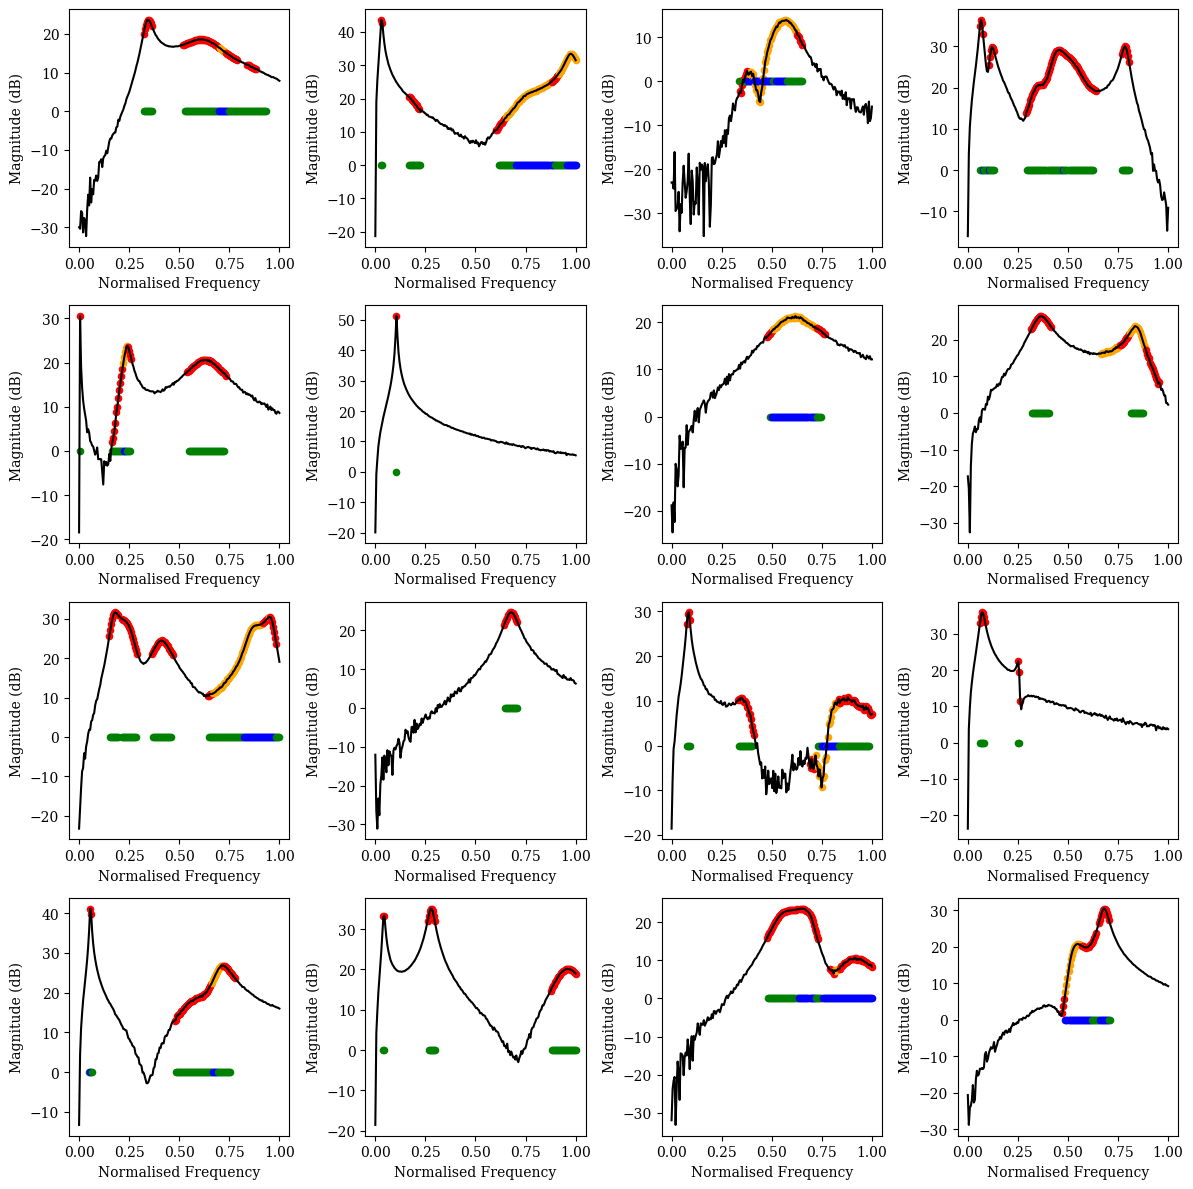

In [231]:
plot_predictions_extended(multiclass_model, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4)

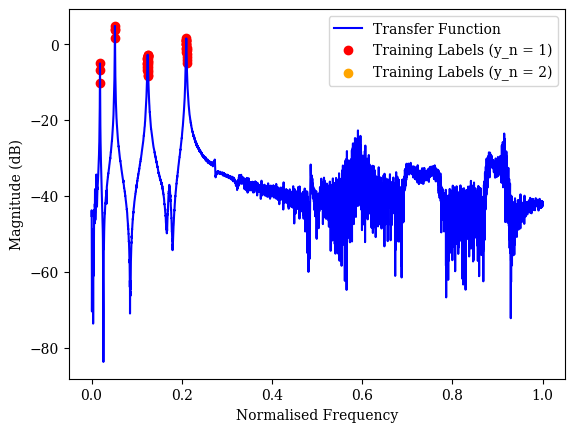

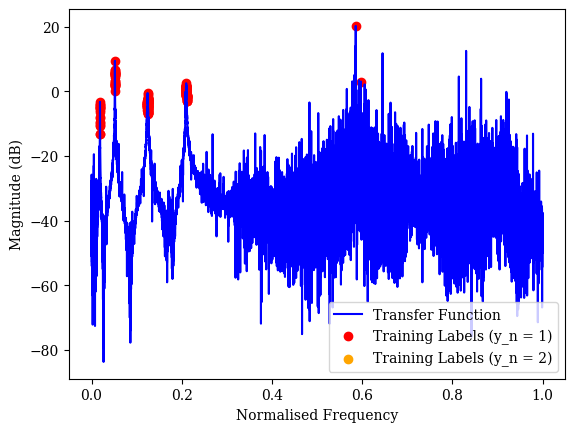

In [199]:
lab_predictions_extended(multiclass_model, lab_tf, extended_lab_tf, multiclass=True, normalise=None)
lab_predictions_extended(multiclass_model, lab_tf_2, extended_lab_tf_2, multiclass=True, normalise=None)


## 17/01

#### Generating plots for the TMR

In [210]:
rnn_model = torch.load('./Models/rnn_v2.pth')

In [216]:
def compare_models(model1, model2):
    valX, valy, _, __ = modal.generate_data(32*1, 200, neg_an=False)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.float32)

    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model1.eval()
    model2.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs1 = model1(val_inputs)
            val_outputs2 = model2(val_inputs)

    modal.plot_predictions(val_inputs, val_outputs1, val_targets)
    modal.plot_predictions(val_inputs, val_outputs2, val_targets)

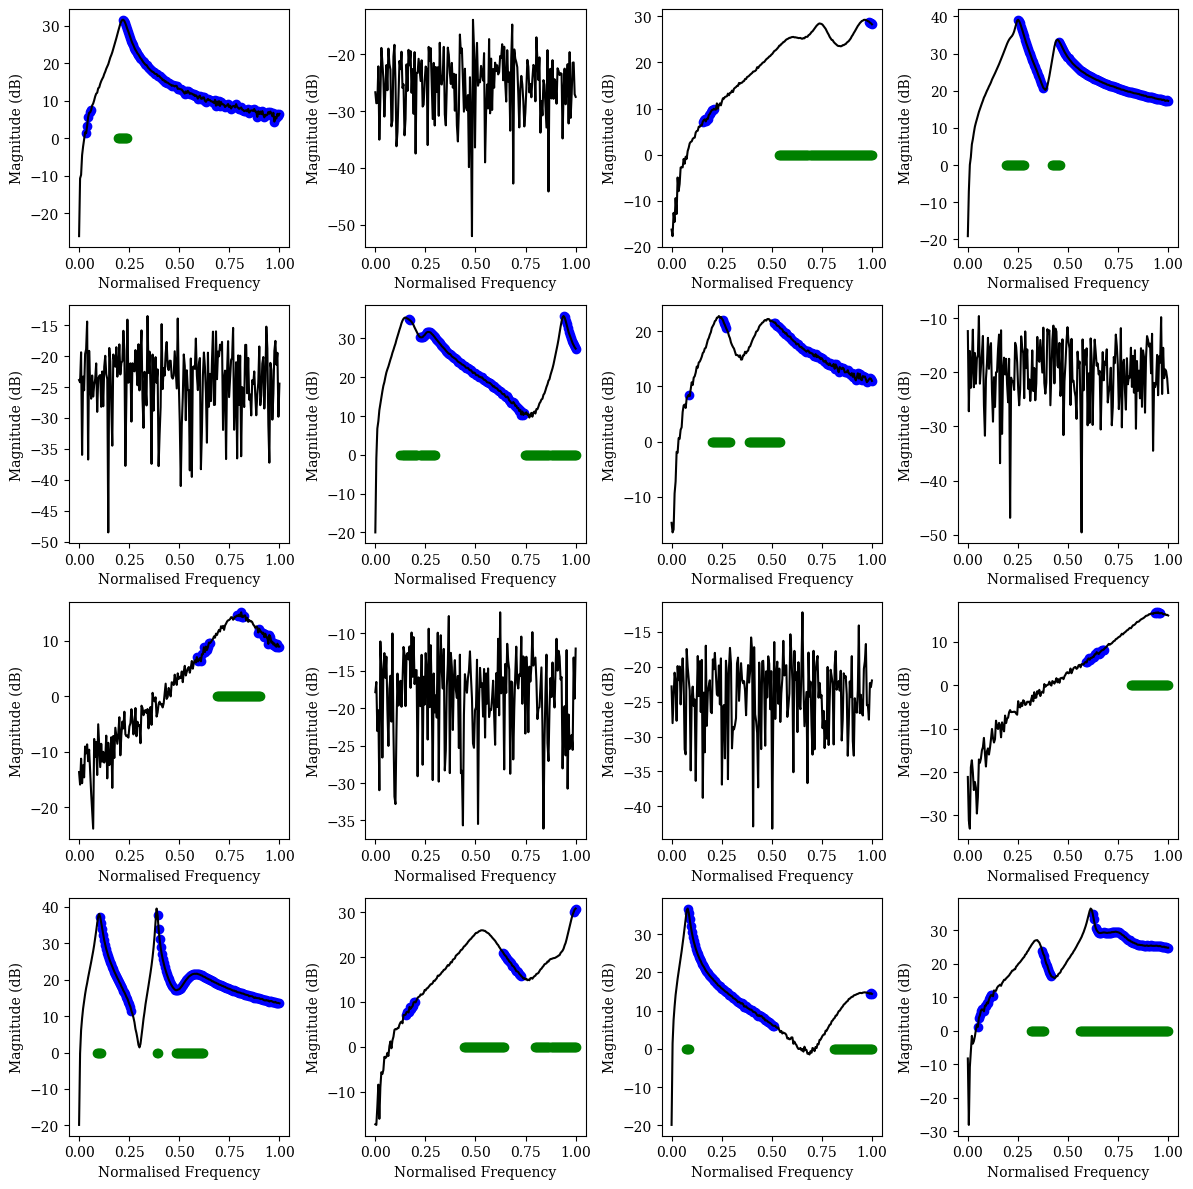

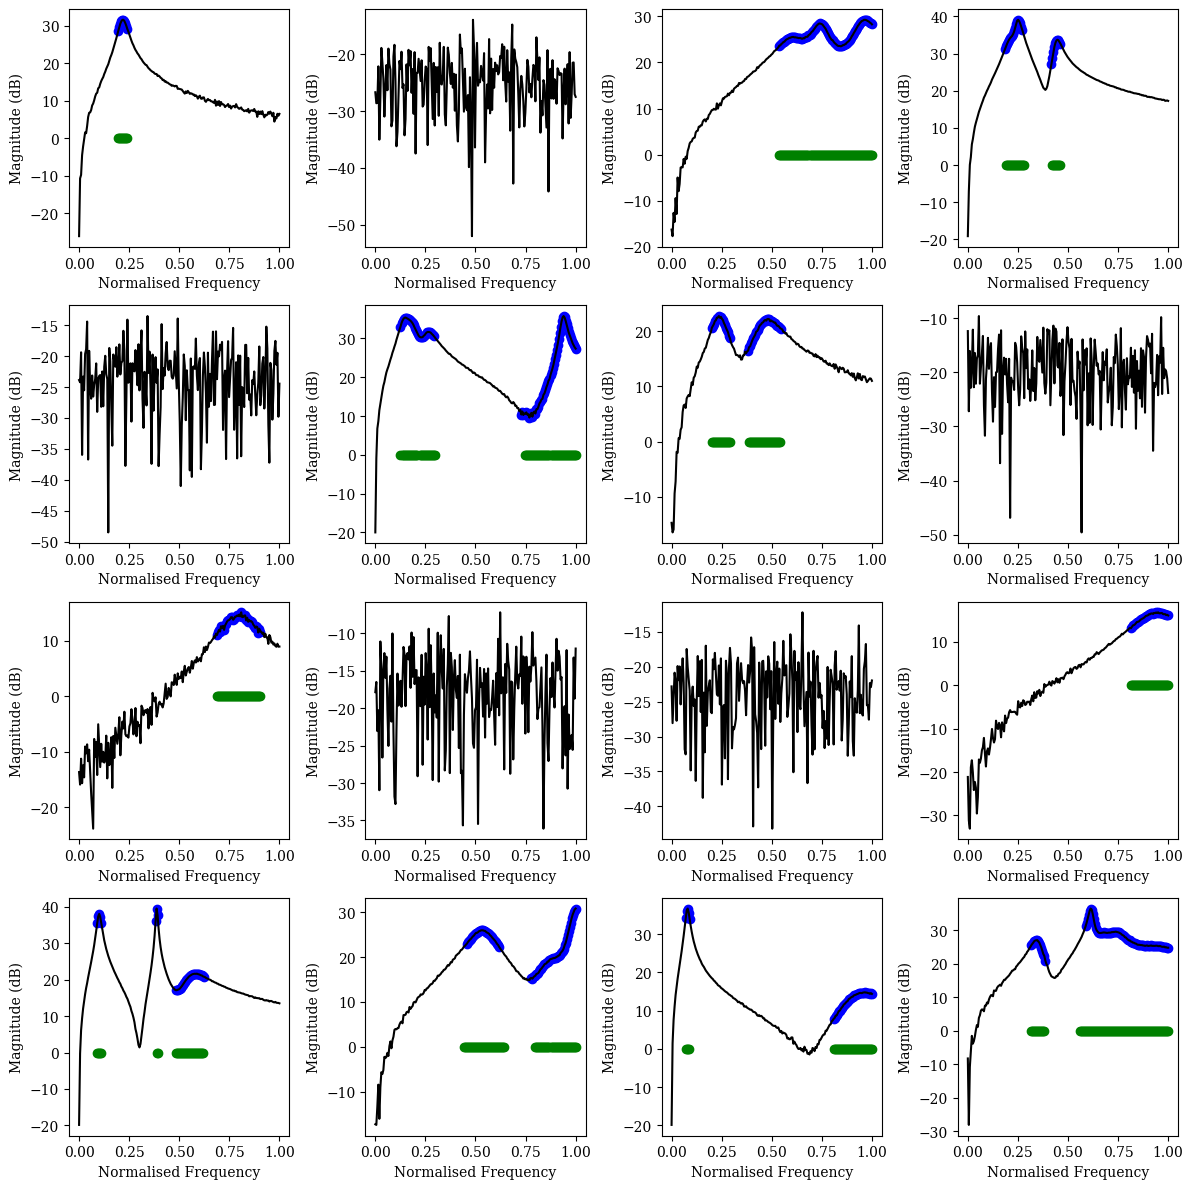

In [219]:
compare_models(rnn_model, neg_an_model_longer)

### Further training the multiclass model

In [232]:
multiclass_res2 = train_model_multiclass(multiclass_model, Xmult, ymult, valXmult, valymult, name='extended_model_multiclass(17.01)_150epochs', num_epochs=100)

  1%|          | 1/100 [02:34<4:15:02, 154.57s/it]

Epoch [1/100], Loss: 0.3842432957887649, Precision: 0.9695183427845379, Recall: 0.9728412525450811
Validation Precision: 0.9702201433804912, Validation Recall: 0.9860583966500444


  2%|▏         | 2/100 [05:08<4:11:39, 154.08s/it]

Epoch [2/100], Loss: 0.37781108015113407, Precision: 0.9701238546794922, Recall: 0.9730153252705008
Validation Precision: 0.9663188865764769, Validation Recall: 0.9857092118615283


  3%|▎         | 3/100 [07:39<4:06:42, 152.60s/it]

Epoch [3/100], Loss: 0.3715650553173489, Precision: 0.9706504107277739, Recall: 0.9732400537537954
Validation Precision: 0.9648631456146903, Validation Recall: 0.9870000358766977


  4%|▍         | 4/100 [10:10<4:03:28, 152.17s/it]

Epoch [4/100], Loss: 0.37129229565461475, Precision: 0.9701146752419872, Recall: 0.9732249346431451
Validation Precision: 0.9627792225719576, Validation Recall: 0.9875574927916283


  5%|▌         | 5/100 [12:43<4:01:04, 152.26s/it]

Epoch [5/100], Loss: 0.36709790183438196, Precision: 0.9699599872649259, Recall: 0.9734187956130632
Validation Precision: 0.9658738250061475, Validation Recall: 0.9862867120401707


  6%|▌         | 6/100 [15:14<3:58:00, 151.92s/it]

Epoch [6/100], Loss: 0.3722748009032673, Precision: 0.9697058285512457, Recall: 0.9731786037757503
Validation Precision: 0.9650770497358989, Validation Recall: 0.9862307157549632


  7%|▋         | 7/100 [17:47<3:56:00, 152.26s/it]

Epoch [7/100], Loss: 0.3643275631798638, Precision: 0.9706462696136005, Recall: 0.9734088778563892
Validation Precision: 0.9710441054676537, Validation Recall: 0.9858807604732256


  8%|▊         | 8/100 [20:15<3:51:36, 151.05s/it]

Epoch [8/100], Loss: 0.3597356082333459, Precision: 0.9708937360854, Recall: 0.9733688991769778
Validation Precision: 0.9716618272995082, Validation Recall: 0.9852881319740929


  9%|▉         | 9/100 [22:49<3:50:31, 152.00s/it]

Epoch [9/100], Loss: 0.358214175634914, Precision: 0.9706417461086106, Recall: 0.9732851189342916
Validation Precision: 0.9718990884916724, Validation Recall: 0.986233026551757


 10%|█         | 10/100 [25:23<3:48:51, 152.57s/it]

Epoch [10/100], Loss: 0.352286931210094, Precision: 0.9716054135098929, Recall: 0.9737471902908004
Validation Precision: 0.9731823955671866, Validation Recall: 0.9847262586527015


 11%|█         | 11/100 [27:57<3:47:05, 153.09s/it]

Epoch [11/100], Loss: 0.35138681312402087, Precision: 0.9712947690398201, Recall: 0.9735977466242942
Validation Precision: 0.9684416492457929, Validation Recall: 0.9866829951944753


 12%|█▏        | 12/100 [30:34<3:45:55, 154.03s/it]

Epoch [12/100], Loss: 0.35112952000565, Precision: 0.9715316145442772, Recall: 0.9736644973796744
Validation Precision: 0.9691824389174206, Validation Recall: 0.9861313367980086


 13%|█▎        | 13/100 [33:11<3:44:56, 155.13s/it]

Epoch [13/100], Loss: 0.3445376922355758, Precision: 0.9721589258687523, Recall: 0.9740447585142912
Validation Precision: 0.9618491000730646, Validation Recall: 0.9870816017282514


 14%|█▍        | 14/100 [35:44<3:41:22, 154.44s/it]

Epoch [14/100], Loss: 0.3415881543689304, Precision: 0.9716976168527636, Recall: 0.9740354877670608
Validation Precision: 0.9738837067435506, Validation Recall: 0.9850996726504995


 15%|█▌        | 15/100 [38:20<3:39:25, 154.89s/it]

Epoch [15/100], Loss: 0.33969769795735677, Precision: 0.9718683445343049, Recall: 0.9740132513978388
Validation Precision: 0.9725287933111361, Validation Recall: 0.9859505843224088


 16%|█▌        | 16/100 [40:52<3:35:31, 153.95s/it]

Epoch [16/100], Loss: 0.3404995404349433, Precision: 0.9718323721550284, Recall: 0.9738127770427187
Validation Precision: 0.9750842168839111, Validation Recall: 0.9853712481286587


 17%|█▋        | 17/100 [43:24<3:32:01, 153.27s/it]

Epoch [17/100], Loss: 0.3348454757531484, Precision: 0.9722109201644161, Recall: 0.9739476583202104
Validation Precision: 0.9666042623731811, Validation Recall: 0.9868773195250491


 18%|█▊        | 18/100 [45:55<3:28:54, 152.86s/it]

Epoch [18/100], Loss: 0.3387492948770523, Precision: 0.971546699836839, Recall: 0.97408128487139
Validation Precision: 0.9692817280813606, Validation Recall: 0.9864967193637071


 19%|█▉        | 19/100 [48:28<3:26:02, 152.62s/it]

Epoch [19/100], Loss: 0.3404467135005527, Precision: 0.971456257816289, Recall: 0.9739383000179083
Validation Precision: 0.9707046903008889, Validation Recall: 0.9854542326616965


 20%|██        | 20/100 [50:57<3:22:16, 151.70s/it]

Epoch [20/100], Loss: 0.3312910425994131, Precision: 0.9717965910587621, Recall: 0.9741923482049858
Validation Precision: 0.965949189847352, Validation Recall: 0.9870690849787925


 21%|██        | 21/100 [53:28<3:19:31, 151.54s/it]

Epoch [21/100], Loss: 0.3325774555073844, Precision: 0.9712983214847423, Recall: 0.9740208219476388
Validation Precision: 0.9714632852941943, Validation Recall: 0.9848359070511541


 22%|██▏       | 22/100 [55:56<3:15:37, 150.48s/it]

Epoch [22/100], Loss: 0.3374032724234793, Precision: 0.9717555321671497, Recall: 0.9741696169746978
Validation Precision: 0.9678908729824007, Validation Recall: 0.986432380282898


 23%|██▎       | 23/100 [58:25<3:12:34, 150.06s/it]

Epoch [23/100], Loss: 0.32393239965041476, Precision: 0.9728040198367953, Recall: 0.9744407935216425
Validation Precision: 0.9692691322268552, Validation Recall: 0.9856557750768823


 24%|██▍       | 24/100 [1:00:58<3:10:59, 150.79s/it]

Epoch [24/100], Loss: 0.3214056630267037, Precision: 0.97320643392427, Recall: 0.9746017965096299
Validation Precision: 0.9697116302602615, Validation Recall: 0.9860191785370384


 25%|██▌       | 25/100 [1:03:25<3:07:12, 149.76s/it]

Epoch [25/100], Loss: 0.3168113355504142, Precision: 0.9732094413667948, Recall: 0.974617914017029
Validation Precision: 0.9705645581629787, Validation Recall: 0.9865928866799686


 26%|██▌       | 26/100 [1:05:55<3:04:45, 149.81s/it]

Epoch [26/100], Loss: 0.31927208171950444, Precision: 0.9729323244798831, Recall: 0.9745385872972959
Validation Precision: 0.9687555110168979, Validation Recall: 0.9856104934821004


 27%|██▋       | 27/100 [1:08:26<3:02:50, 150.28s/it]

Epoch [27/100], Loss: 0.3208078234725528, Precision: 0.9731254140684014, Recall: 0.9744179553119124
Validation Precision: 0.9679195795616488, Validation Recall: 0.9862543471333503


 28%|██▊       | 28/100 [1:11:02<3:02:12, 151.85s/it]

Epoch [28/100], Loss: 0.3246284861034817, Precision: 0.9724407709929196, Recall: 0.9744146410372754
Validation Precision: 0.9697870911869576, Validation Recall: 0.9860645911299245


 29%|██▉       | 29/100 [1:13:33<2:59:31, 151.71s/it]

Epoch [29/100], Loss: 0.323469340801239, Precision: 0.9727405354527437, Recall: 0.9742960076258625
Validation Precision: 0.9725428829502626, Validation Recall: 0.9849133462082726


 30%|███       | 30/100 [1:16:04<2:56:37, 151.39s/it]

Epoch [30/100], Loss: 0.31530740271011987, Precision: 0.9734468792896913, Recall: 0.9746804580182052
Validation Precision: 0.9741647130887927, Validation Recall: 0.9848950386390644


 31%|███       | 31/100 [1:18:33<2:53:18, 150.70s/it]

Epoch [31/100], Loss: 0.3143324288725853, Precision: 0.9733326271203765, Recall: 0.9746437097738184
Validation Precision: 0.9708629430778721, Validation Recall: 0.9856072082343974


 32%|███▏      | 32/100 [1:21:04<2:50:56, 150.83s/it]

Epoch [32/100], Loss: 0.3129378811849488, Precision: 0.9732762244723676, Recall: 0.9747914422766011
Validation Precision: 0.9706354193576497, Validation Recall: 0.985909336216793


 33%|███▎      | 33/100 [1:23:36<2:48:44, 151.12s/it]

Epoch [33/100], Loss: 0.3081595481104321, Precision: 0.9739907659256697, Recall: 0.9747020024821541
Validation Precision: 0.9711847582733608, Validation Recall: 0.9853410050257136


 34%|███▍      | 34/100 [1:26:09<2:46:54, 151.73s/it]

Epoch [34/100], Loss: 0.31121843367815016, Precision: 0.973322015229883, Recall: 0.9748270563362106
Validation Precision: 0.9727335234916068, Validation Recall: 0.9858593685371585


 35%|███▌      | 35/100 [1:28:41<2:44:17, 151.66s/it]

Epoch [35/100], Loss: 0.299290606909328, Precision: 0.9744199406449537, Recall: 0.9749823236710574
Validation Precision: 0.9703662066555051, Validation Recall: 0.9859285833686877


 36%|███▌      | 36/100 [1:31:13<2:42:06, 151.98s/it]

Epoch [36/100], Loss: 0.321394996477498, Precision: 0.9720762849994791, Recall: 0.9742691824753948
Validation Precision: 0.9723801964663398, Validation Recall: 0.9851403048953329


 37%|███▋      | 37/100 [1:33:46<2:39:53, 152.28s/it]

Epoch [37/100], Loss: 0.30668110910389157, Precision: 0.9734340429481791, Recall: 0.9746917062144957
Validation Precision: 0.9744004917902965, Validation Recall: 0.9854124177311807


 38%|███▊      | 38/100 [1:36:19<2:37:25, 152.34s/it]

Epoch [38/100], Loss: 0.29765429619285794, Precision: 0.9747650320986985, Recall: 0.9749656071392989
Validation Precision: 0.9707061792260727, Validation Recall: 0.9862831641560574


 39%|███▉      | 39/100 [1:38:53<2:35:18, 152.76s/it]

Epoch [39/100], Loss: 0.2945044446322653, Precision: 0.9747231284775829, Recall: 0.9752730388551745
Validation Precision: 0.9685479137530539, Validation Recall: 0.9861994805294149


 40%|████      | 40/100 [1:41:27<2:33:16, 153.28s/it]

Epoch [40/100], Loss: 0.29602837867207, Precision: 0.9743545577346601, Recall: 0.9750871235250145
Validation Precision: 0.9664197612732696, Validation Recall: 0.9864210887750379


 41%|████      | 41/100 [1:44:01<2:30:47, 153.34s/it]

Epoch [41/100], Loss: 0.3015731661187278, Precision: 0.9739465571680651, Recall: 0.9750217247661511
Validation Precision: 0.965171166862697, Validation Recall: 0.9860627807188703


 42%|████▏     | 42/100 [1:46:33<2:27:59, 153.10s/it]

Epoch [42/100], Loss: 0.29925738970438637, Precision: 0.9746007217768069, Recall: 0.9749480139949032
Validation Precision: 0.9717689195851464, Validation Recall: 0.9851421895094467


 43%|████▎     | 43/100 [1:49:04<2:24:45, 152.38s/it]

Epoch [43/100], Loss: 0.3003893225722843, Precision: 0.9747887461389144, Recall: 0.9753094552110676
Validation Precision: 0.9721638510623203, Validation Recall: 0.9854253791608245


 44%|████▍     | 44/100 [1:51:33<2:21:17, 151.38s/it]

Epoch [44/100], Loss: 0.29205869615077973, Precision: 0.9751093046545498, Recall: 0.9753498904812316
Validation Precision: 0.9701178721077096, Validation Recall: 0.9853890896795693


 45%|████▌     | 45/100 [1:54:03<2:18:28, 151.06s/it]

Epoch [45/100], Loss: 0.29323622905545765, Precision: 0.9749480959624682, Recall: 0.9751784200517046
Validation Precision: 0.9717275094204031, Validation Recall: 0.9863168389072433


 46%|████▌     | 46/100 [1:56:37<2:16:44, 151.94s/it]

Epoch [46/100], Loss: 0.2994020562039481, Precision: 0.9740236925519673, Recall: 0.9750899161069873
Validation Precision: 0.9702171682711448, Validation Recall: 0.9859075747892558


 47%|████▋     | 47/100 [1:59:11<2:14:36, 152.39s/it]

Epoch [47/100], Loss: 0.2828337826331456, Precision: 0.9757812399591141, Recall: 0.9755421753302123
Validation Precision: 0.9728255224228729, Validation Recall: 0.9859761203858745


 48%|████▊     | 48/100 [2:01:43<2:12:05, 152.41s/it]

Epoch [48/100], Loss: 0.2861228615376684, Precision: 0.9755588819593397, Recall: 0.975619073793886
Validation Precision: 0.9705189107930885, Validation Recall: 0.9853015790951895


 49%|████▉     | 49/100 [2:04:16<2:09:36, 152.49s/it]

Epoch [49/100], Loss: 0.2931487153304948, Precision: 0.9746947305214706, Recall: 0.9751956810356972
Validation Precision: 0.9675412172625176, Validation Recall: 0.9863606002384183


 50%|█████     | 50/100 [2:06:47<2:06:44, 152.10s/it]

Epoch [50/100], Loss: 0.2909646553794543, Precision: 0.9749030543527725, Recall: 0.9754129744838362
Validation Precision: 0.9706157467906301, Validation Recall: 0.985959896323451


 51%|█████     | 51/100 [2:09:18<2:03:58, 151.81s/it]

Epoch [51/100], Loss: 0.28745328456163405, Precision: 0.9753301245489907, Recall: 0.9753584149600205
Validation Precision: 0.9757312476983473, Validation Recall: 0.9849616136148414


 52%|█████▏    | 52/100 [2:11:51<2:01:38, 152.06s/it]

Epoch [52/100], Loss: 0.281804964211252, Precision: 0.976059268721634, Recall: 0.975618439049311
Validation Precision: 0.9700457975031977, Validation Recall: 0.9853229225500556


 53%|█████▎    | 53/100 [2:14:21<1:58:42, 151.54s/it]

Epoch [53/100], Loss: 0.27716332458787496, Precision: 0.976020862538077, Recall: 0.9758429018535328
Validation Precision: 0.9718473310061989, Validation Recall: 0.9855646523136131


 54%|█████▍    | 54/100 [2:16:53<1:56:14, 151.63s/it]

Epoch [54/100], Loss: 0.28248673462205465, Precision: 0.976066777709974, Recall: 0.9756228688678528
Validation Precision: 0.9721811413539663, Validation Recall: 0.9854471789933871


 55%|█████▌    | 55/100 [2:19:25<1:53:46, 151.70s/it]

Epoch [55/100], Loss: 0.2746861540277799, Precision: 0.9767197540154644, Recall: 0.975948314671266
Validation Precision: 0.9722010879573204, Validation Recall: 0.985270391375473


 56%|█████▌    | 56/100 [2:21:55<1:50:54, 151.24s/it]

Epoch [56/100], Loss: 0.28190036959118314, Precision: 0.9756854274248095, Recall: 0.9757693156870181
Validation Precision: 0.9693279719653664, Validation Recall: 0.9856594523357063


 57%|█████▋    | 57/100 [2:24:30<1:49:07, 152.27s/it]

Epoch [57/100], Loss: 0.2802899992465973, Precision: 0.9760833210944274, Recall: 0.9756533254020386
Validation Precision: 0.9713907108490932, Validation Recall: 0.9851940891275436


 58%|█████▊    | 58/100 [2:27:12<1:48:42, 155.31s/it]

Epoch [58/100], Loss: 0.2840151020884514, Precision: 0.9754428511690366, Recall: 0.9754614035054363
Validation Precision: 0.9703022406153674, Validation Recall: 0.9853830920735837


 59%|█████▉    | 59/100 [2:29:54<1:47:28, 157.29s/it]

Epoch [59/100], Loss: 0.288977433707979, Precision: 0.9753608287825095, Recall: 0.9754100882962163
Validation Precision: 0.9732929185867053, Validation Recall: 0.9851739348559994


 60%|██████    | 60/100 [2:32:27<1:44:03, 156.08s/it]

Epoch [60/100], Loss: 0.2774879698289765, Precision: 0.9763401151476682, Recall: 0.9756551188669403
Validation Precision: 0.9724947268981572, Validation Recall: 0.9851291984412255


 61%|██████    | 61/100 [2:34:58<1:40:29, 154.61s/it]

Epoch [61/100], Loss: 0.2719439359505971, Precision: 0.9767493190735473, Recall: 0.9760546408310738
Validation Precision: 0.96429113777528, Validation Recall: 0.9869569064314463


 62%|██████▏   | 62/100 [2:37:28<1:37:03, 153.26s/it]

Epoch [62/100], Loss: 0.28100703567266466, Precision: 0.9758093951298002, Recall: 0.9759698745468595
Validation Precision: 0.9667225688475269, Validation Recall: 0.9852556612833632


 63%|██████▎   | 63/100 [2:40:00<1:34:10, 152.72s/it]

Epoch [63/100], Loss: 0.2835401879747709, Precision: 0.9754009176508588, Recall: 0.9753871724542619
Validation Precision: 0.9699110384135662, Validation Recall: 0.9858653768839202


 64%|██████▍   | 64/100 [2:42:29<1:30:57, 151.60s/it]

Epoch [64/100], Loss: 0.27257433543602627, Precision: 0.9767961317800244, Recall: 0.9759870534271358
Validation Precision: 0.9753771633610205, Validation Recall: 0.9849981477947477


 65%|██████▌   | 65/100 [2:44:59<1:28:08, 151.11s/it]

Epoch [65/100], Loss: 0.2720215952065256, Precision: 0.9766736388024817, Recall: 0.976081667431592
Validation Precision: 0.9728322580979263, Validation Recall: 0.9848699197794852


 66%|██████▌   | 66/100 [2:47:30<1:25:34, 151.00s/it]

Epoch [66/100], Loss: 0.2733912703726027, Precision: 0.9767908782063849, Recall: 0.9760116065171346
Validation Precision: 0.9695163968399779, Validation Recall: 0.9849273757252726


 67%|██████▋   | 67/100 [2:50:05<1:23:43, 152.23s/it]

Epoch [67/100], Loss: 0.27197049074702795, Precision: 0.9770836515811707, Recall: 0.9760813128101103
Validation Precision: 0.9722127082044412, Validation Recall: 0.9849549025012775


 68%|██████▊   | 68/100 [2:52:37<1:21:12, 152.28s/it]

Epoch [68/100], Loss: 0.26585048629177943, Precision: 0.977497173018384, Recall: 0.9763404664511245
Validation Precision: 0.9672951671243004, Validation Recall: 0.9866895802473102


 69%|██████▉   | 69/100 [2:55:09<1:18:34, 152.08s/it]

Epoch [69/100], Loss: 0.27662816405296325, Precision: 0.9764086110641356, Recall: 0.9758848625436829
Validation Precision: 0.9741620145217748, Validation Recall: 0.9846385473783447


 70%|███████   | 70/100 [2:57:36<1:15:23, 150.77s/it]

Epoch [70/100], Loss: 0.2684376464618577, Precision: 0.9771583870140629, Recall: 0.9761966561400418
Validation Precision: 0.9708576441069404, Validation Recall: 0.9845469061561853


 71%|███████   | 71/100 [3:00:04<1:12:24, 149.80s/it]

Epoch [71/100], Loss: 0.2826474236117469, Precision: 0.9758099361784579, Recall: 0.9757643915727326
Validation Precision: 0.9681295951094281, Validation Recall: 0.9856692124466249


 72%|███████▏  | 72/100 [3:02:35<1:10:05, 150.21s/it]

Epoch [72/100], Loss: 0.2653074966867765, Precision: 0.9777058149598926, Recall: 0.9761690432034887
Validation Precision: 0.9752401367997756, Validation Recall: 0.9846353992967386


 73%|███████▎  | 73/100 [3:05:08<1:07:59, 151.10s/it]

Epoch [73/100], Loss: 0.2581156489915318, Precision: 0.9783599371688071, Recall: 0.9762545273105895
Validation Precision: 0.9684681055075682, Validation Recall: 0.986330556761175


 74%|███████▍  | 74/100 [3:07:40<1:05:34, 151.31s/it]

Epoch [74/100], Loss: 0.274538258281019, Precision: 0.9764854174092247, Recall: 0.9758359274843003
Validation Precision: 0.9718789215383107, Validation Recall: 0.9856074722693657


 75%|███████▌  | 75/100 [3:10:11<1:02:59, 151.17s/it]

Epoch [75/100], Loss: 0.25936732365025417, Precision: 0.978022313796838, Recall: 0.9762878231793564
Validation Precision: 0.9732274742882097, Validation Recall: 0.9851391898219554


 76%|███████▌  | 76/100 [3:12:42<1:00:25, 151.08s/it]

Epoch [76/100], Loss: 0.2684009502331416, Precision: 0.9771626438022958, Recall: 0.9761353941499694
Validation Precision: 0.9743318037262536, Validation Recall: 0.9846869963542797


 77%|███████▋  | 77/100 [3:15:13<57:53, 151.04s/it]  

Epoch [77/100], Loss: 0.2647829639249378, Precision: 0.9776390829358019, Recall: 0.9761594174924144
Validation Precision: 0.9752869781219512, Validation Recall: 0.9841747878342963


 78%|███████▊  | 78/100 [3:17:42<55:08, 150.39s/it]

Epoch [78/100], Loss: 0.25529947535859215, Precision: 0.9786347410961878, Recall: 0.9767919125815603
Validation Precision: 0.9676119768734995, Validation Recall: 0.9852584024230121


 79%|███████▉  | 79/100 [3:20:11<52:31, 150.05s/it]

Epoch [79/100], Loss: 0.2584436392121845, Precision: 0.9785358533560661, Recall: 0.9765989074930166
Validation Precision: 0.9741337931098929, Validation Recall: 0.9846313449794536


 80%|████████  | 80/100 [3:22:39<49:47, 149.39s/it]

Epoch [80/100], Loss: 0.28074020826154283, Precision: 0.9758037715554565, Recall: 0.9758579048246795
Validation Precision: 0.9738167196521879, Validation Recall: 0.9848212172709662


 81%|████████  | 81/100 [3:25:09<47:23, 149.64s/it]

Epoch [81/100], Loss: 0.2637510291404194, Precision: 0.9775917076143703, Recall: 0.9762579017395311
Validation Precision: 0.973457691491779, Validation Recall: 0.9842920217150403


 82%|████████▏ | 82/100 [3:27:40<45:02, 150.16s/it]

Epoch [82/100], Loss: 0.2638833105895254, Precision: 0.9773756754981707, Recall: 0.9763050040872355
Validation Precision: 0.9692013149209902, Validation Recall: 0.9855308708567069


 83%|████████▎ | 83/100 [3:30:11<42:37, 150.42s/it]

Epoch [83/100], Loss: 0.25998979767163594, Precision: 0.9777553561251252, Recall: 0.976377868190423
Validation Precision: 0.9730142355255021, Validation Recall: 0.9843126312155287


 84%|████████▍ | 84/100 [3:32:43<40:10, 150.67s/it]

Epoch [84/100], Loss: 0.25689972864256966, Precision: 0.9783899034786552, Recall: 0.9764637442281978
Validation Precision: 0.9721858488454675, Validation Recall: 0.9849008311539892


 85%|████████▌ | 85/100 [3:35:14<37:42, 150.82s/it]

Epoch [85/100], Loss: 0.2590285388959779, Precision: 0.9777328140261673, Recall: 0.976493209412483
Validation Precision: 0.9721360982112844, Validation Recall: 0.9847445776328904


 86%|████████▌ | 86/100 [3:37:45<35:14, 151.05s/it]

Epoch [86/100], Loss: 0.2554044126802021, Precision: 0.9783896095747147, Recall: 0.976531155913075
Validation Precision: 0.973039996410821, Validation Recall: 0.9847324773435808


 87%|████████▋ | 87/100 [3:40:19<32:53, 151.81s/it]

Epoch [87/100], Loss: 0.25212909009721546, Precision: 0.9787394130985562, Recall: 0.9768328513359407
Validation Precision: 0.9736763418884276, Validation Recall: 0.9847370784652925


 88%|████████▊ | 88/100 [3:42:51<30:21, 151.82s/it]

Epoch [88/100], Loss: 0.25001318279239865, Precision: 0.9789413535036776, Recall: 0.9767555034532913
Validation Precision: 0.9699724846804719, Validation Recall: 0.9855593853865564


 89%|████████▉ | 89/100 [3:45:22<27:48, 151.72s/it]

Epoch [89/100], Loss: 0.25994834535651734, Precision: 0.9778910594370572, Recall: 0.976457330438799
Validation Precision: 0.973417656978198, Validation Recall: 0.9853921809693479


 90%|█████████ | 90/100 [3:47:52<25:12, 151.24s/it]

Epoch [90/100], Loss: 0.26375081976254783, Precision: 0.9774896754389655, Recall: 0.9761640158327002
Validation Precision: 0.9751809434616275, Validation Recall: 0.9841275688866934


 91%|█████████ | 91/100 [3:50:20<22:31, 150.17s/it]

Epoch [91/100], Loss: 0.2535348066356447, Precision: 0.9783784661738372, Recall: 0.9764862555405137
Validation Precision: 0.9700835356445069, Validation Recall: 0.9854532963784421


 92%|█████████▏| 92/100 [3:52:50<20:01, 150.20s/it]

Epoch [92/100], Loss: 0.2594013171063529, Precision: 0.9780742614518219, Recall: 0.9763284009740157
Validation Precision: 0.9744409068520291, Validation Recall: 0.9851300425926892


 93%|█████████▎| 93/100 [3:55:21<17:32, 150.38s/it]

Epoch [93/100], Loss: 0.25188027130232915, Precision: 0.9785953361595513, Recall: 0.9766874695748954
Validation Precision: 0.9748290932382256, Validation Recall: 0.9845025261838348


 94%|█████████▍| 94/100 [3:57:52<15:03, 150.66s/it]

Epoch [94/100], Loss: 0.24979517483048969, Precision: 0.9789525816456345, Recall: 0.976829773793397
Validation Precision: 0.9666347342255406, Validation Recall: 0.9857175673745912


 95%|█████████▌| 95/100 [4:00:23<12:32, 150.51s/it]

Epoch [95/100], Loss: 0.2589553065432443, Precision: 0.9783420169844904, Recall: 0.9766192530053578
Validation Precision: 0.9639523125717241, Validation Recall: 0.9832774430961072


 96%|█████████▌| 96/100 [4:02:54<10:02, 150.70s/it]

Epoch [96/100], Loss: 0.28693281415436, Precision: 0.9752902772727816, Recall: 0.975707678457533
Validation Precision: 0.9702371564890313, Validation Recall: 0.9849660367664455


 97%|█████████▋| 97/100 [4:05:25<07:32, 151.00s/it]

Epoch [97/100], Loss: 0.2503850859734747, Precision: 0.9787062030904022, Recall: 0.9768804753076107
Validation Precision: 0.9764925985724244, Validation Recall: 0.9837157988294395


 98%|█████████▊| 98/100 [4:07:59<05:03, 151.83s/it]

Epoch [98/100], Loss: 0.24636242306894726, Precision: 0.9794350256551061, Recall: 0.9766807361880901
Validation Precision: 0.9683264960943709, Validation Recall: 0.9859386242578068


 99%|█████████▉| 99/100 [4:10:31<02:31, 151.68s/it]

Epoch [99/100], Loss: 0.24230071236689885, Precision: 0.9797557545995152, Recall: 0.9768834265239423
Validation Precision: 0.9750718268703362, Validation Recall: 0.9847157318636569


100%|██████████| 100/100 [4:12:59<00:00, 151.79s/it]

Epoch [100/100], Loss: 0.24127384967274135, Precision: 0.9798300571533638, Recall: 0.9771353796447937
Validation Precision: 0.9727381502159844, Validation Recall: 0.9846190409536757


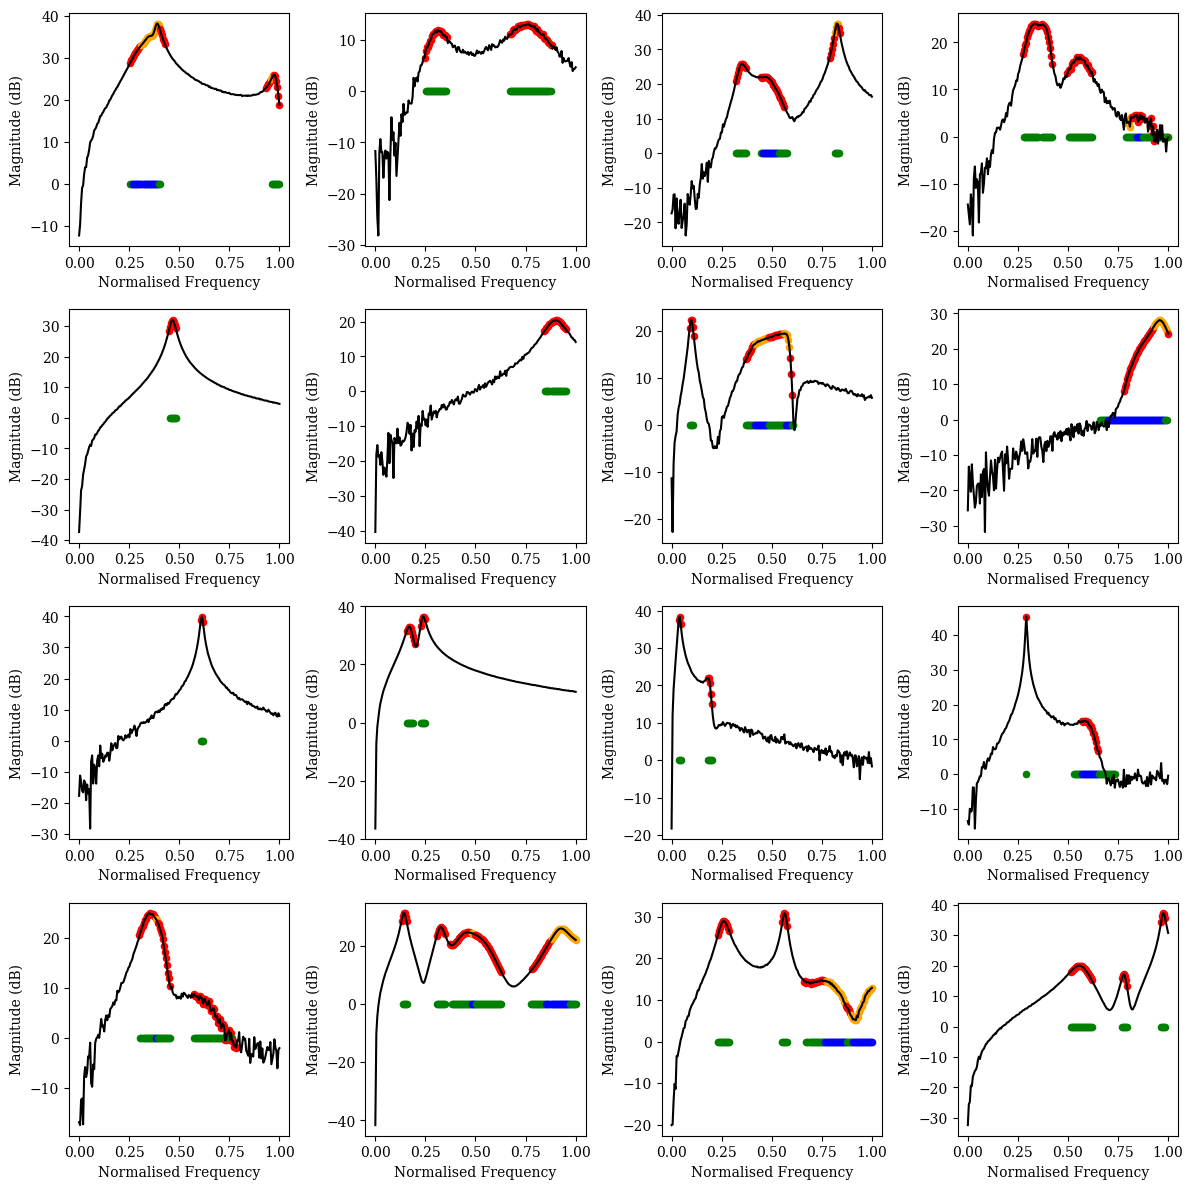

In [238]:
plot_predictions_extended(multiclass_model, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4)

#### Training the multiclass model even more ! (new training data)

In [239]:
Xmult2, ymult2, ws, __ = generate_dat_extended(num_data=32*450, num_w_points=200, neg_an=True, multiclass=True)  # sigma_max = 0.15, max_modes = 7 (defaults)

In [250]:
Xmult_new = np.concatenate((Xmult, Xmult2), axis=0)
ymult_new = np.concatenate((ymult, ymult2), axis=0)

In [254]:
multiclass_res3 = train_model_multiclass(multiclass_model, Xmult_new, ymult_new, valXmult, valymult, name='extended_model_multiclass(18.01)_200epochs', num_epochs=50)

  2%|▏         | 1/50 [04:45<3:52:57, 285.26s/it]

Epoch [1/50], Loss: 0.4351351644926601, Precision: 0.9705796566480094, Recall: 0.9726280403695007
Validation Precision: 0.9713826309506307, Validation Recall: 0.987437546867358


  4%|▍         | 2/50 [09:34<3:50:16, 287.84s/it]

Epoch [2/50], Loss: 0.41336561871899496, Precision: 0.9716955002240617, Recall: 0.9730138807928941
Validation Precision: 0.9699915663486861, Validation Recall: 0.9881755135847936


  6%|▌         | 3/50 [14:22<3:45:25, 287.77s/it]

Epoch [3/50], Loss: 0.4039070484704442, Precision: 0.9722398694157778, Recall: 0.9730270863943817
Validation Precision: 0.9717539992507568, Validation Recall: 0.9878060895300415


  8%|▊         | 4/50 [19:12<3:41:17, 288.65s/it]

Epoch [4/50], Loss: 0.3961773932642407, Precision: 0.9721764919163783, Recall: 0.9731538679597246
Validation Precision: 0.9726199101929951, Validation Recall: 0.9878324878477397


 10%|█         | 5/50 [24:01<3:36:27, 288.61s/it]

Epoch [5/50], Loss: 0.3933126477400462, Precision: 0.9721340341422092, Recall: 0.9731656238972369
Validation Precision: 0.9718867530650741, Validation Recall: 0.9874057392768099


 12%|█▏        | 6/50 [28:52<3:32:15, 289.43s/it]

Epoch [6/50], Loss: 0.38234893234239686, Precision: 0.9727910785491632, Recall: 0.9734337872371154
Validation Precision: 0.9681995334697355, Validation Recall: 0.9880037780137346


 14%|█▍        | 7/50 [33:40<3:27:11, 289.10s/it]

Epoch [7/50], Loss: 0.37744472371207344, Precision: 0.9724266897628533, Recall: 0.973473210760971
Validation Precision: 0.970273805069651, Validation Recall: 0.9887456702189377


 16%|█▌        | 8/50 [38:30<3:22:39, 289.50s/it]

Epoch [8/50], Loss: 0.37554943713876937, Precision: 0.972619683181955, Recall: 0.9734271064756996
Validation Precision: 0.9739523080473913, Validation Recall: 0.987430000412345


 18%|█▊        | 9/50 [43:20<3:17:46, 289.42s/it]

Epoch [9/50], Loss: 0.37001596965723565, Precision: 0.972745605243267, Recall: 0.9737773628065117
Validation Precision: 0.9751563311328133, Validation Recall: 0.9870853084944131


 20%|██        | 10/50 [48:06<3:12:20, 288.52s/it]

Epoch [10/50], Loss: 0.36341727957129477, Precision: 0.9732718391728106, Recall: 0.9738319082331783
Validation Precision: 0.976170692364193, Validation Recall: 0.9874142463227582


 22%|██▏       | 11/50 [52:55<3:07:33, 288.55s/it]

Epoch [11/50], Loss: 0.35926244346631897, Precision: 0.9731398234851508, Recall: 0.9738525635373407
Validation Precision: 0.9690255965694525, Validation Recall: 0.9882532853362789


 24%|██▍       | 12/50 [57:43<3:02:45, 288.57s/it]

Epoch [12/50], Loss: 0.3561665474043952, Precision: 0.97362574013212, Recall: 0.9739470869321967
Validation Precision: 0.971134399940997, Validation Recall: 0.9884024988636295


 26%|██▌       | 13/50 [1:02:31<2:57:49, 288.36s/it]

Epoch [13/50], Loss: 0.3523071902162499, Precision: 0.9734275394781904, Recall: 0.9740902317625068
Validation Precision: 0.9702404174858517, Validation Recall: 0.9881459887273064


 28%|██▊       | 14/50 [1:07:22<2:53:23, 288.98s/it]

Epoch [14/50], Loss: 0.34885448997219404, Precision: 0.9733664598782275, Recall: 0.9742031381816066
Validation Precision: 0.9741889761016307, Validation Recall: 0.9868314568465811


 30%|███       | 15/50 [1:12:09<2:48:16, 288.47s/it]

Epoch [15/50], Loss: 0.34822901593314276, Precision: 0.9733343789084955, Recall: 0.9740566553823578
Validation Precision: 0.9738912271191436, Validation Recall: 0.9866455300414652


 32%|███▏      | 16/50 [1:16:57<2:43:20, 288.24s/it]

Epoch [16/50], Loss: 0.3447909301188257, Precision: 0.9736730273746249, Recall: 0.974249007268544
Validation Precision: 0.9724640899318799, Validation Recall: 0.9875649961642502


 34%|███▍      | 17/50 [1:21:47<2:38:53, 288.91s/it]

Epoch [17/50], Loss: 0.3422619376083215, Precision: 0.9736501140158463, Recall: 0.9743090631364014
Validation Precision: 0.9711656514971255, Validation Recall: 0.9881613827473081


 36%|███▌      | 18/50 [1:26:36<2:34:09, 289.03s/it]

Epoch [18/50], Loss: 0.33885062110092906, Precision: 0.97412777918477, Recall: 0.9742436691371941
Validation Precision: 0.9748152329232269, Validation Recall: 0.9871476383228122


 38%|███▊      | 19/50 [1:31:24<2:29:09, 288.68s/it]

Epoch [19/50], Loss: 0.3347609364655283, Precision: 0.9740056099709836, Recall: 0.9743535947082631
Validation Precision: 0.9734338495943479, Validation Recall: 0.9873312806102542


 40%|████      | 20/50 [1:36:13<2:24:22, 288.76s/it]

Epoch [20/50], Loss: 0.33568373509579236, Precision: 0.973604913904269, Recall: 0.9743018060575328
Validation Precision: 0.972518417738809, Validation Recall: 0.9875980366723606


 42%|████▏     | 21/50 [1:40:59<2:19:09, 287.91s/it]

Epoch [21/50], Loss: 0.3322499835160044, Precision: 0.9740659466317536, Recall: 0.9745322422949576
Validation Precision: 0.9643362836267567, Validation Recall: 0.9875456090601924


 44%|████▍     | 22/50 [1:45:45<2:14:02, 287.23s/it]

Epoch [22/50], Loss: 0.332386111650202, Precision: 0.9739040261041353, Recall: 0.9744173034340103
Validation Precision: 0.9726777242167828, Validation Recall: 0.9874379894076128


 46%|████▌     | 23/50 [1:50:32<2:09:15, 287.25s/it]

Epoch [23/50], Loss: 0.3278483758866787, Precision: 0.9740475988632056, Recall: 0.9744340064847058
Validation Precision: 0.972501479589672, Validation Recall: 0.9879540655586331


 48%|████▊     | 24/50 [1:55:17<2:04:12, 286.65s/it]

Epoch [24/50], Loss: 0.3271644483009974, Precision: 0.9740589664878389, Recall: 0.9745215980998639
Validation Precision: 0.9731850165990876, Validation Recall: 0.9881327451737303


 50%|█████     | 25/50 [2:00:02<1:59:07, 285.91s/it]

Epoch [25/50], Loss: 0.3260362927781211, Precision: 0.9740829791841782, Recall: 0.974469120833964
Validation Precision: 0.969488034969702, Validation Recall: 0.9872948134603464


 52%|█████▏    | 26/50 [2:04:46<1:54:12, 285.54s/it]

Epoch [26/50], Loss: 0.32582668342524107, Precision: 0.9740978725557838, Recall: 0.9744061926541611
Validation Precision: 0.9707024053728651, Validation Recall: 0.9875270970831039


 54%|█████▍    | 27/50 [2:09:29<1:49:08, 284.71s/it]

Epoch [27/50], Loss: 0.3208699501885308, Precision: 0.9746370205226096, Recall: 0.9746437164622977
Validation Precision: 0.9729644188689318, Validation Recall: 0.9878265269151199


 56%|█████▌    | 28/50 [2:14:16<1:44:36, 285.31s/it]

Epoch [28/50], Loss: 0.31615166152517, Precision: 0.9745912698485462, Recall: 0.9749037892338376
Validation Precision: 0.9732958684828634, Validation Recall: 0.987691956627728


 58%|█████▊    | 29/50 [2:18:59<1:39:37, 284.63s/it]

Epoch [29/50], Loss: 0.3175591104063723, Precision: 0.9750505891990159, Recall: 0.9747765700883412
Validation Precision: 0.9732174337442541, Validation Recall: 0.9870123331526411


 60%|██████    | 30/50 [2:23:42<1:34:46, 284.34s/it]

Epoch [30/50], Loss: 0.3196005943748686, Precision: 0.974330228871969, Recall: 0.9747013088934583
Validation Precision: 0.9737752530657996, Validation Recall: 0.9878782180254708


 62%|██████▏   | 31/50 [2:28:31<1:30:26, 285.60s/it]

Epoch [31/50], Loss: 0.31372861011160746, Precision: 0.974710843007735, Recall: 0.9747779681944525
Validation Precision: 0.974758203674575, Validation Recall: 0.9876341012873783


 64%|██████▍   | 32/50 [2:33:15<1:25:33, 285.20s/it]

Epoch [32/50], Loss: 0.31294033885002137, Precision: 0.9749255200419983, Recall: 0.974997504942156
Validation Precision: 0.96924128495013, Validation Recall: 0.9883519902643407


 66%|██████▌   | 33/50 [2:38:00<1:20:45, 285.00s/it]

Epoch [33/50], Loss: 0.3127100845840242, Precision: 0.975026274156829, Recall: 0.97492646860568
Validation Precision: 0.9750059458989841, Validation Recall: 0.9873753347481931


 68%|██████▊   | 34/50 [2:42:47<1:16:08, 285.51s/it]

Epoch [34/50], Loss: 0.3116250691645675, Precision: 0.9747789381251857, Recall: 0.9749428748180037
Validation Precision: 0.9736695024328977, Validation Recall: 0.9874484149007776


 70%|███████   | 35/50 [2:47:35<1:11:34, 286.32s/it]

Epoch [35/50], Loss: 0.31387270685699253, Precision: 0.974421546434765, Recall: 0.9750276342288702
Validation Precision: 0.9689466147636377, Validation Recall: 0.9869772853526978


 72%|███████▏  | 36/50 [2:52:24<1:06:59, 287.11s/it]

Epoch [36/50], Loss: 0.3122255902323458, Precision: 0.9745646072749513, Recall: 0.9750905738791946
Validation Precision: 0.9741123249389494, Validation Recall: 0.9873835807437576


 74%|███████▍  | 37/50 [2:57:14<1:02:24, 288.02s/it]

Epoch [37/50], Loss: 0.3075881889793608, Precision: 0.9751700020155737, Recall: 0.9749618710782652
Validation Precision: 0.970662087335739, Validation Recall: 0.9882589883297446


 76%|███████▌  | 38/50 [3:02:02<57:36, 288.01s/it]  

Epoch [38/50], Loss: 0.31524095316727957, Precision: 0.9742821294598669, Recall: 0.974823079885647
Validation Precision: 0.9741292361599142, Validation Recall: 0.9876660425039868


 78%|███████▊  | 39/50 [3:06:51<52:51, 288.34s/it]

Epoch [39/50], Loss: 0.3012955345875687, Precision: 0.9757798103387695, Recall: 0.9753874071184996
Validation Precision: 0.9755898347562559, Validation Recall: 0.9867832856244746


 80%|████████  | 40/50 [3:11:40<48:05, 288.59s/it]

Epoch [40/50], Loss: 0.3040496107604769, Precision: 0.9753911413998446, Recall: 0.9751966256926599
Validation Precision: 0.9713753840224199, Validation Recall: 0.9877192608396883


 82%|████████▏ | 41/50 [3:16:28<43:15, 288.33s/it]

Epoch [41/50], Loss: 0.30662080051170454, Precision: 0.9751075354948872, Recall: 0.9751353910513907
Validation Precision: 0.9724069918236359, Validation Recall: 0.9888331987034428


 84%|████████▍ | 42/50 [3:21:17<38:27, 288.47s/it]

Epoch [42/50], Loss: 0.30163015556004313, Precision: 0.9756218627597942, Recall: 0.9752421153419405
Validation Precision: 0.975128253835291, Validation Recall: 0.9871337319269822


 86%|████████▌ | 43/50 [3:26:02<33:32, 287.46s/it]

Epoch [43/50], Loss: 0.29765411360396277, Precision: 0.976078243476787, Recall: 0.9753182536150162
Validation Precision: 0.9698778714340348, Validation Recall: 0.9880968450834007


 88%|████████▊ | 44/50 [3:30:49<28:44, 287.34s/it]

Epoch [44/50], Loss: 0.298490021791723, Precision: 0.9760466139123013, Recall: 0.9754871776882926
Validation Precision: 0.9734612615522177, Validation Recall: 0.9876875909118923


 90%|█████████ | 45/50 [3:35:40<24:02, 288.57s/it]

Epoch [45/50], Loss: 0.30194282798303496, Precision: 0.9758609279141381, Recall: 0.9753218680761393
Validation Precision: 0.9714954978642909, Validation Recall: 0.9886039783612971


 92%|█████████▏| 46/50 [3:40:30<19:15, 288.87s/it]

Epoch [46/50], Loss: 0.2951679918666681, Precision: 0.9763560754634247, Recall: 0.9754742696143965
Validation Precision: 0.9737161814940478, Validation Recall: 0.9867224162635891


 94%|█████████▍| 47/50 [3:45:21<14:28, 289.56s/it]

Epoch [47/50], Loss: 0.30074068672127197, Precision: 0.9757202833978288, Recall: 0.9753933548328192
Validation Precision: 0.974422027824059, Validation Recall: 0.9862904319780681


 96%|█████████▌| 48/50 [3:50:13<09:40, 290.32s/it]

Epoch [48/50], Loss: 0.2898775550391939, Precision: 0.9764401983536356, Recall: 0.9756854423329092
Validation Precision: 0.9747957110007179, Validation Recall: 0.98760794854544


 98%|█████████▊| 49/50 [3:55:04<04:50, 290.60s/it]

Epoch [49/50], Loss: 0.2885100212362077, Precision: 0.9765197233033172, Recall: 0.9755086925555954
Validation Precision: 0.9711733120284033, Validation Recall: 0.9877004747131142


100%|██████████| 50/50 [3:59:57<00:00, 287.94s/it]

Epoch [50/50], Loss: 0.29436619573169287, Precision: 0.9759524696025241, Recall: 0.9754123820895014
Validation Precision: 0.9716491602397749, Validation Recall: 0.9880492585993613


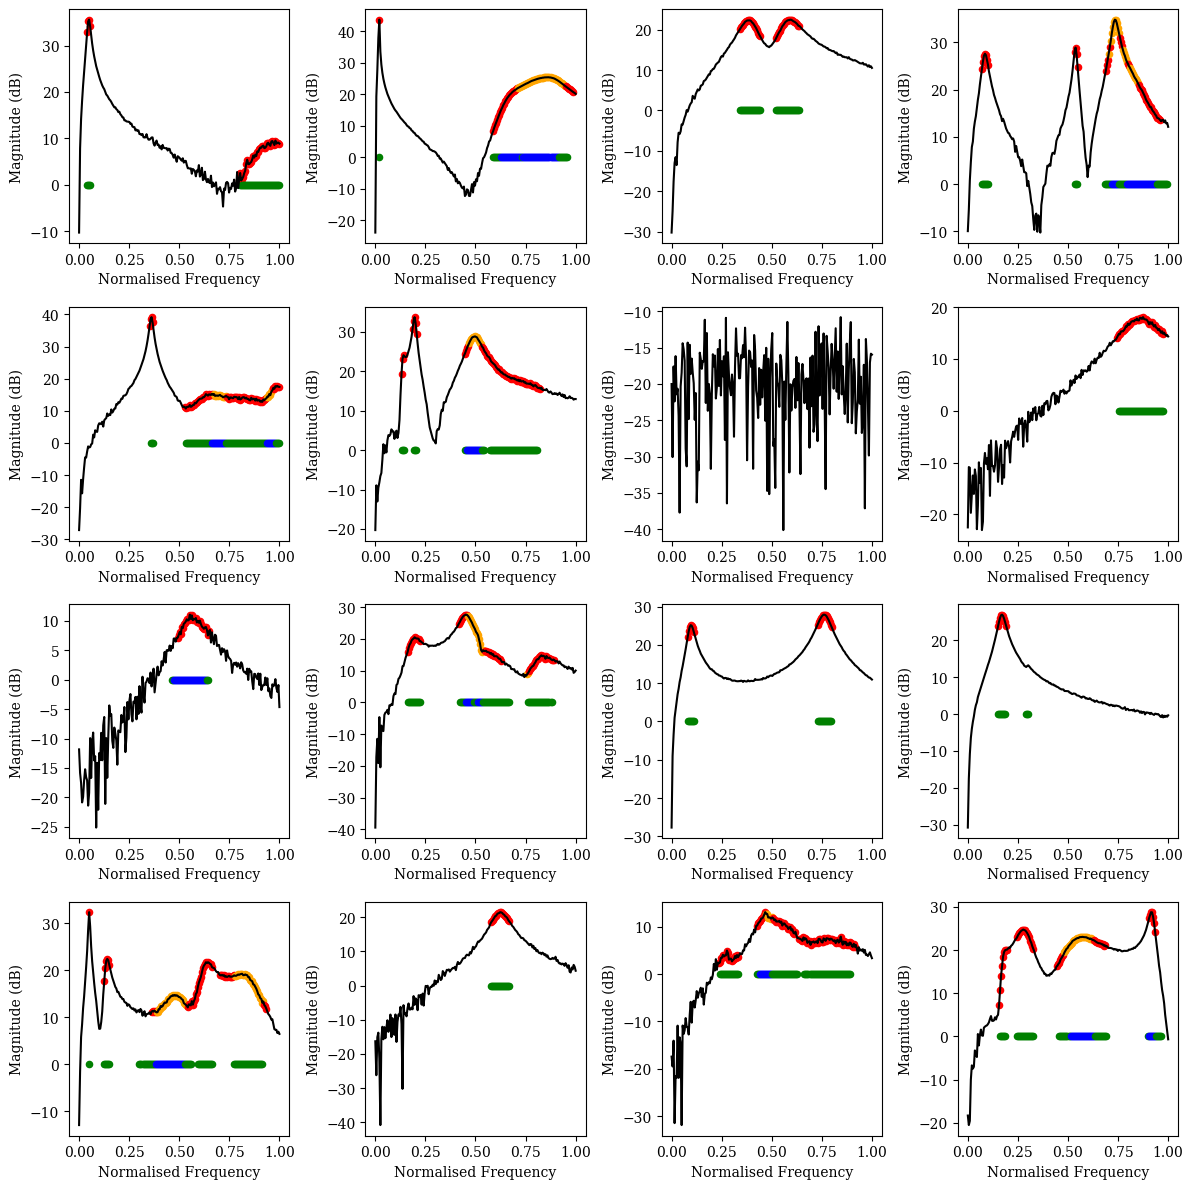

In [258]:
plot_predictions_extended(multiclass_model, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4)